In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV1'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dftlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

## Data transformation

In [9]:
signals = dftlib.all_I_Q_to_DFT(signals)

### Training and Test data partitioning

In [10]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [12]:
model = neural_networks.freehand_v1(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        80        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 16)        16400     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0     

### Train the model

In [13]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/146 [..............................] - ETA: 29:11 - loss: 2.3979

  2/146 [..............................] - ETA: 8s - loss: 2.3975   

  3/146 [..............................] - ETA: 8s - loss: 2.3971

  4/146 [..............................] - ETA: 8s - loss: 2.3966

  5/146 [>.............................] - ETA: 8s - loss: 2.3960

  6/146 [>.............................] - ETA: 7s - loss: 2.3952

  7/146 [>.............................] - ETA: 7s - loss: 2.3944

  8/146 [>.............................] - ETA: 7s - loss: 2.3934

  9/146 [>.............................] - ETA: 7s - loss: 2.3922

 10/146 [=>............................] - ETA: 7s - loss: 2.3906

 11/146 [=>............................] - ETA: 7s - loss: 2.3890

 12/146 [=>............................] - ETA: 7s - loss: 2.3870

 13/146 [=>............................] - ETA: 7s - loss: 2.3849

 14/146 [=>............................] - ETA: 7s - loss: 2.3826

 15/146 [==>...........................] - ETA: 7s - loss: 2.3800

 16/146 [==>...........................] - ETA: 7s - loss: 2.3773

 17/146 [==>...........................] - ETA: 7s - loss: 2.3743

 18/146 [==>...........................] - ETA: 7s - loss: 2.3712

 19/146 [==>...........................] - ETA: 7s - loss: 2.3678

 20/146 [===>..........................] - ETA: 7s - loss: 2.3643

 21/146 [===>..........................] - ETA: 7s - loss: 2.3606

 22/146 [===>..........................] - ETA: 6s - loss: 2.3568

 23/146 [===>..........................] - ETA: 6s - loss: 2.3529

 24/146 [===>..........................] - ETA: 6s - loss: 2.3488

 25/146 [====>.........................] - ETA: 6s - loss: 2.3446

 26/146 [====>.........................] - ETA: 6s - loss: 2.3404

 27/146 [====>.........................] - ETA: 6s - loss: 2.3361

 28/146 [====>.........................] - ETA: 6s - loss: 2.3318

 29/146 [====>.........................] - ETA: 6s - loss: 2.3274

 30/146 [=====>........................] - ETA: 6s - loss: 2.3231

 31/146 [=====>........................] - ETA: 6s - loss: 2.3187

 32/146 [=====>........................] - ETA: 6s - loss: 2.3143

 33/146 [=====>........................] - ETA: 6s - loss: 2.3100

 34/146 [=====>........................] - ETA: 6s - loss: 2.3056

 35/146 [======>.......................] - ETA: 6s - loss: 2.3013

 36/146 [======>.......................] - ETA: 6s - loss: 2.2970

 37/146 [======>.......................] - ETA: 6s - loss: 2.2928

 38/146 [======>.......................] - ETA: 6s - loss: 2.2886

 39/146 [=======>......................] - ETA: 6s - loss: 2.2846

 40/146 [=======>......................] - ETA: 5s - loss: 2.2805

 41/146 [=======>......................] - ETA: 5s - loss: 2.2765

 42/146 [=======>......................] - ETA: 5s - loss: 2.2726

 43/146 [=======>......................] - ETA: 5s - loss: 2.2687

 44/146 [========>.....................] - ETA: 5s - loss: 2.2649

 45/146 [========>.....................] - ETA: 5s - loss: 2.2610

 46/146 [========>.....................] - ETA: 5s - loss: 2.2573

 47/146 [========>.....................] - ETA: 5s - loss: 2.2536

 48/146 [========>.....................] - ETA: 5s - loss: 2.2499

 49/146 [=========>....................] - ETA: 5s - loss: 2.2463

 50/146 [=========>....................] - ETA: 5s - loss: 2.2427

 51/146 [=========>....................] - ETA: 5s - loss: 2.2392

 52/146 [=========>....................] - ETA: 5s - loss: 2.2358

 53/146 [=========>....................] - ETA: 5s - loss: 2.2324

 54/146 [==========>...................] - ETA: 5s - loss: 2.2291

 55/146 [==========>...................] - ETA: 5s - loss: 2.2258

 56/146 [==========>...................] - ETA: 5s - loss: 2.2226

 57/146 [==========>...................] - ETA: 5s - loss: 2.2194

 58/146 [==========>...................] - ETA: 4s - loss: 2.2163

 59/146 [===========>..................] - ETA: 4s - loss: 2.2132

 60/146 [===========>..................] - ETA: 4s - loss: 2.2101

 61/146 [===========>..................] - ETA: 4s - loss: 2.2072

 62/146 [===========>..................] - ETA: 4s - loss: 2.2042

 63/146 [===========>..................] - ETA: 4s - loss: 2.2013

 64/146 [============>.................] - ETA: 4s - loss: 2.1985

 65/146 [============>.................] - ETA: 4s - loss: 2.1957

 66/146 [============>.................] - ETA: 4s - loss: 2.1929

 67/146 [============>.................] - ETA: 4s - loss: 2.1902

 68/146 [============>.................] - ETA: 4s - loss: 2.1876

 69/146 [=============>................] - ETA: 4s - loss: 2.1850

 70/146 [=============>................] - ETA: 4s - loss: 2.1824

 71/146 [=============>................] - ETA: 4s - loss: 2.1798

 72/146 [=============>................] - ETA: 4s - loss: 2.1773

 73/146 [==============>...............] - ETA: 4s - loss: 2.1748

 74/146 [==============>...............] - ETA: 4s - loss: 2.1724

 75/146 [==============>...............] - ETA: 3s - loss: 2.1699

 76/146 [==============>...............] - ETA: 3s - loss: 2.1676

 77/146 [==============>...............] - ETA: 3s - loss: 2.1652

 78/146 [===============>..............] - ETA: 3s - loss: 2.1629

 79/146 [===============>..............] - ETA: 3s - loss: 2.1606

 80/146 [===============>..............] - ETA: 3s - loss: 2.1584

 81/146 [===============>..............] - ETA: 3s - loss: 2.1561

 82/146 [===============>..............] - ETA: 3s - loss: 2.1539

 83/146 [================>.............] - ETA: 3s - loss: 2.1518

 84/146 [================>.............] - ETA: 3s - loss: 2.1496

 85/146 [================>.............] - ETA: 3s - loss: 2.1475

 86/146 [================>.............] - ETA: 3s - loss: 2.1454

 87/146 [================>.............] - ETA: 3s - loss: 2.1433

 88/146 [=================>............] - ETA: 3s - loss: 2.1413

 89/146 [=================>............] - ETA: 3s - loss: 2.1393

 90/146 [=================>............] - ETA: 3s - loss: 2.1373

 91/146 [=================>............] - ETA: 3s - loss: 2.1353

 92/146 [=================>............] - ETA: 3s - loss: 2.1334

 93/146 [==================>...........] - ETA: 2s - loss: 2.1315

 94/146 [==================>...........] - ETA: 2s - loss: 2.1296

 95/146 [==================>...........] - ETA: 2s - loss: 2.1277

 96/146 [==================>...........] - ETA: 2s - loss: 2.1258

 97/146 [==================>...........] - ETA: 2s - loss: 2.1240

 98/146 [===================>..........] - ETA: 2s - loss: 2.1222

 99/146 [===================>..........] - ETA: 2s - loss: 2.1204

100/146 [===================>..........] - ETA: 2s - loss: 2.1186

101/146 [===================>..........] - ETA: 2s - loss: 2.1169

102/146 [===================>..........] - ETA: 2s - loss: 2.1151

103/146 [====================>.........] - ETA: 2s - loss: 2.1134

104/146 [====================>.........] - ETA: 2s - loss: 2.1117

105/146 [====================>.........] - ETA: 2s - loss: 2.1100

106/146 [====================>.........] - ETA: 2s - loss: 2.1084

107/146 [====================>.........] - ETA: 2s - loss: 2.1068

108/146 [=====================>........] - ETA: 2s - loss: 2.1051

109/146 [=====================>........] - ETA: 2s - loss: 2.1035

110/146 [=====================>........] - ETA: 2s - loss: 2.1019

111/146 [=====================>........] - ETA: 1s - loss: 2.1004

112/146 [======================>.......] - ETA: 1s - loss: 2.0988

113/146 [======================>.......] - ETA: 1s - loss: 2.0973

114/146 [======================>.......] - ETA: 1s - loss: 2.0958

115/146 [======================>.......] - ETA: 1s - loss: 2.0942

116/146 [======================>.......] - ETA: 1s - loss: 2.0928

117/146 [=======================>......] - ETA: 1s - loss: 2.0913

118/146 [=======================>......] - ETA: 1s - loss: 2.0898

119/146 [=======================>......] - ETA: 1s - loss: 2.0883

120/146 [=======================>......] - ETA: 1s - loss: 2.0869

121/146 [=======================>......] - ETA: 1s - loss: 2.0855

122/146 [========================>.....] - ETA: 1s - loss: 2.0841

123/146 [========================>.....] - ETA: 1s - loss: 2.0827

124/146 [========================>.....] - ETA: 1s - loss: 2.0813

125/146 [========================>.....] - ETA: 1s - loss: 2.0799

126/146 [========================>.....] - ETA: 1s - loss: 2.0785

127/146 [=========================>....] - ETA: 1s - loss: 2.0772

128/146 [=========================>....] - ETA: 1s - loss: 2.0759

129/146 [=========================>....] - ETA: 0s - loss: 2.0745

130/146 [=========================>....] - ETA: 0s - loss: 2.0732

131/146 [=========================>....] - ETA: 0s - loss: 2.0719

132/146 [==========================>...] - ETA: 0s - loss: 2.0706

133/146 [==========================>...] - ETA: 0s - loss: 2.0693

134/146 [==========================>...] - ETA: 0s - loss: 2.0681

135/146 [==========================>...] - ETA: 0s - loss: 2.0668

136/146 [==========================>...] - ETA: 0s - loss: 2.0656

137/146 [===========================>..] - ETA: 0s - loss: 2.0643

138/146 [===========================>..] - ETA: 0s - loss: 2.0631

139/146 [===========================>..] - ETA: 0s - loss: 2.0619

140/146 [===========================>..] - ETA: 0s - loss: 2.0607

141/146 [===========================>..] - ETA: 0s - loss: 2.0594

142/146 [============================>.] - ETA: 0s - loss: 2.0583

143/146 [============================>.] - ETA: 0s - loss: 2.0571

144/146 [============================>.] - ETA: 0s - loss: 2.0559

145/146 [============================>.] - ETA: 0s - loss: 2.0547

146/146 [==============================] - ETA: 0s - loss: 2.0536

146/146 [==============================] - 21s 64ms/step - loss: 2.0525 - val_loss: 1.8643


Epoch 2/100
  1/146 [..............................] - ETA: 8s - loss: 1.8527

  2/146 [..............................] - ETA: 8s - loss: 1.8462

  3/146 [..............................] - ETA: 8s - loss: 1.8490

  4/146 [..............................] - ETA: 8s - loss: 1.8479

  5/146 [>.............................] - ETA: 7s - loss: 1.8441

  6/146 [>.............................] - ETA: 7s - loss: 1.8417

  7/146 [>.............................] - ETA: 7s - loss: 1.8387

  8/146 [>.............................] - ETA: 7s - loss: 1.8362

  9/146 [>.............................] - ETA: 7s - loss: 1.8341

 10/146 [=>............................] - ETA: 7s - loss: 1.8318

 11/146 [=>............................] - ETA: 7s - loss: 1.8293

 12/146 [=>............................] - ETA: 7s - loss: 1.8272

 13/146 [=>............................] - ETA: 7s - loss: 1.8249

 14/146 [=>............................] - ETA: 7s - loss: 1.8225

 15/146 [==>...........................] - ETA: 7s - loss: 1.8205

 16/146 [==>...........................] - ETA: 7s - loss: 1.8185

 17/146 [==>...........................] - ETA: 7s - loss: 1.8165

 18/146 [==>...........................] - ETA: 7s - loss: 1.8148

 19/146 [==>...........................] - ETA: 7s - loss: 1.8131

 20/146 [===>..........................] - ETA: 7s - loss: 1.8115



 21/146 [===>..........................] - ETA: 7s - loss: 1.8101

 22/146 [===>..........................] - ETA: 7s - loss: 1.8088

 23/146 [===>..........................] - ETA: 6s - loss: 1.8075

 24/146 [===>..........................] - ETA: 6s - loss: 1.8063

 25/146 [====>.........................] - ETA: 6s - loss: 1.8051

 26/146 [====>.........................] - ETA: 6s - loss: 1.8040

 27/146 [====>.........................] - ETA: 6s - loss: 1.8029

 28/146 [====>.........................] - ETA: 6s - loss: 1.8018

 29/146 [====>.........................] - ETA: 6s - loss: 1.8008

 30/146 [=====>........................] - ETA: 6s - loss: 1.7997

 31/146 [=====>........................] - ETA: 6s - loss: 1.7987

 32/146 [=====>........................] - ETA: 6s - loss: 1.7978

 33/146 [=====>........................] - ETA: 6s - loss: 1.7969

 34/146 [=====>........................] - ETA: 6s - loss: 1.7960

 35/146 [======>.......................] - ETA: 6s - loss: 1.7951

 36/146 [======>.......................] - ETA: 6s - loss: 1.7943

 37/146 [======>.......................] - ETA: 6s - loss: 1.7935

 38/146 [======>.......................] - ETA: 6s - loss: 1.7927

 39/146 [=======>......................] - ETA: 6s - loss: 1.7920

 40/146 [=======>......................] - ETA: 5s - loss: 1.7912

 41/146 [=======>......................] - ETA: 5s - loss: 1.7905

 42/146 [=======>......................] - ETA: 5s - loss: 1.7898

 43/146 [=======>......................] - ETA: 5s - loss: 1.7891

 44/146 [========>.....................] - ETA: 5s - loss: 1.7884

 45/146 [========>.....................] - ETA: 5s - loss: 1.7878

 46/146 [========>.....................] - ETA: 5s - loss: 1.7872

 47/146 [========>.....................] - ETA: 5s - loss: 1.7866

 48/146 [========>.....................] - ETA: 5s - loss: 1.7860

 49/146 [=========>....................] - ETA: 5s - loss: 1.7854

 50/146 [=========>....................] - ETA: 5s - loss: 1.7848

 51/146 [=========>....................] - ETA: 5s - loss: 1.7843

 52/146 [=========>....................] - ETA: 5s - loss: 1.7838

 53/146 [=========>....................] - ETA: 5s - loss: 1.7832

 54/146 [==========>...................] - ETA: 5s - loss: 1.7827

 55/146 [==========>...................] - ETA: 5s - loss: 1.7821

 56/146 [==========>...................] - ETA: 5s - loss: 1.7816

 57/146 [==========>...................] - ETA: 5s - loss: 1.7811

 58/146 [==========>...................] - ETA: 4s - loss: 1.7806

 59/146 [===========>..................] - ETA: 4s - loss: 1.7802

 60/146 [===========>..................] - ETA: 4s - loss: 1.7797

 61/146 [===========>..................] - ETA: 4s - loss: 1.7792

 62/146 [===========>..................] - ETA: 4s - loss: 1.7787

 63/146 [===========>..................] - ETA: 4s - loss: 1.7783

 64/146 [============>.................] - ETA: 4s - loss: 1.7778

 65/146 [============>.................] - ETA: 4s - loss: 1.7774

 66/146 [============>.................] - ETA: 4s - loss: 1.7769

 67/146 [============>.................] - ETA: 4s - loss: 1.7765

 68/146 [============>.................] - ETA: 4s - loss: 1.7760

 69/146 [=============>................] - ETA: 4s - loss: 1.7756

 70/146 [=============>................] - ETA: 4s - loss: 1.7751

 71/146 [=============>................] - ETA: 4s - loss: 1.7747

 72/146 [=============>................] - ETA: 4s - loss: 1.7743

 73/146 [==============>...............] - ETA: 4s - loss: 1.7739

 74/146 [==============>...............] - ETA: 4s - loss: 1.7734

 75/146 [==============>...............] - ETA: 4s - loss: 1.7730

 76/146 [==============>...............] - ETA: 3s - loss: 1.7726

 77/146 [==============>...............] - ETA: 3s - loss: 1.7722

 78/146 [===============>..............] - ETA: 3s - loss: 1.7718

 79/146 [===============>..............] - ETA: 3s - loss: 1.7714

 80/146 [===============>..............] - ETA: 3s - loss: 1.7710

 81/146 [===============>..............] - ETA: 3s - loss: 1.7706

 82/146 [===============>..............] - ETA: 3s - loss: 1.7702

 83/146 [================>.............] - ETA: 3s - loss: 1.7699

 84/146 [================>.............] - ETA: 3s - loss: 1.7695

 85/146 [================>.............] - ETA: 3s - loss: 1.7691

 86/146 [================>.............] - ETA: 3s - loss: 1.7687

 87/146 [================>.............] - ETA: 3s - loss: 1.7684

 88/146 [=================>............] - ETA: 3s - loss: 1.7680

 89/146 [=================>............] - ETA: 3s - loss: 1.7677

 90/146 [=================>............] - ETA: 3s - loss: 1.7673

 91/146 [=================>............] - ETA: 3s - loss: 1.7670

 92/146 [=================>............] - ETA: 3s - loss: 1.7666

 93/146 [==================>...........] - ETA: 2s - loss: 1.7663

 94/146 [==================>...........] - ETA: 2s - loss: 1.7659

 95/146 [==================>...........] - ETA: 2s - loss: 1.7656

 96/146 [==================>...........] - ETA: 2s - loss: 1.7653

 97/146 [==================>...........] - ETA: 2s - loss: 1.7649

 98/146 [===================>..........] - ETA: 2s - loss: 1.7646

 99/146 [===================>..........] - ETA: 2s - loss: 1.7643

100/146 [===================>..........] - ETA: 2s - loss: 1.7640

101/146 [===================>..........] - ETA: 2s - loss: 1.7636

102/146 [===================>..........] - ETA: 2s - loss: 1.7633

103/146 [====================>.........] - ETA: 2s - loss: 1.7630

104/146 [====================>.........] - ETA: 2s - loss: 1.7627

105/146 [====================>.........] - ETA: 2s - loss: 1.7624

106/146 [====================>.........] - ETA: 2s - loss: 1.7620

107/146 [====================>.........] - ETA: 2s - loss: 1.7617

108/146 [=====================>........] - ETA: 2s - loss: 1.7614

109/146 [=====================>........] - ETA: 2s - loss: 1.7611

110/146 [=====================>........] - ETA: 2s - loss: 1.7607

111/146 [=====================>........] - ETA: 1s - loss: 1.7604

112/146 [======================>.......] - ETA: 1s - loss: 1.7601

113/146 [======================>.......] - ETA: 1s - loss: 1.7598

114/146 [======================>.......] - ETA: 1s - loss: 1.7595

115/146 [======================>.......] - ETA: 1s - loss: 1.7591

116/146 [======================>.......] - ETA: 1s - loss: 1.7588

117/146 [=======================>......] - ETA: 1s - loss: 1.7585

118/146 [=======================>......] - ETA: 1s - loss: 1.7582

119/146 [=======================>......] - ETA: 1s - loss: 1.7579

120/146 [=======================>......] - ETA: 1s - loss: 1.7576

121/146 [=======================>......] - ETA: 1s - loss: 1.7572

122/146 [========================>.....] - ETA: 1s - loss: 1.7569

123/146 [========================>.....] - ETA: 1s - loss: 1.7566

124/146 [========================>.....] - ETA: 1s - loss: 1.7563

125/146 [========================>.....] - ETA: 1s - loss: 1.7560

126/146 [========================>.....] - ETA: 1s - loss: 1.7557

127/146 [=========================>....] - ETA: 1s - loss: 1.7554

128/146 [=========================>....] - ETA: 1s - loss: 1.7551

129/146 [=========================>....] - ETA: 0s - loss: 1.7548

130/146 [=========================>....] - ETA: 0s - loss: 1.7545

131/146 [=========================>....] - ETA: 0s - loss: 1.7542

132/146 [==========================>...] - ETA: 0s - loss: 1.7539

133/146 [==========================>...] - ETA: 0s - loss: 1.7536

134/146 [==========================>...] - ETA: 0s - loss: 1.7533

135/146 [==========================>...] - ETA: 0s - loss: 1.7530

136/146 [==========================>...] - ETA: 0s - loss: 1.7527

137/146 [===========================>..] - ETA: 0s - loss: 1.7524

138/146 [===========================>..] - ETA: 0s - loss: 1.7522

139/146 [===========================>..] - ETA: 0s - loss: 1.7519

140/146 [===========================>..] - ETA: 0s - loss: 1.7516

141/146 [===========================>..] - ETA: 0s - loss: 1.7513

142/146 [============================>.] - ETA: 0s - loss: 1.7510

143/146 [============================>.] - ETA: 0s - loss: 1.7507

144/146 [============================>.] - ETA: 0s - loss: 1.7504

145/146 [============================>.] - ETA: 0s - loss: 1.7502

146/146 [==============================] - 9s 59ms/step - loss: 1.7496 - val_loss: 3.3078


Epoch 3/100
  1/146 [..............................] - ETA: 7s - loss: 3.3306

  2/146 [..............................] - ETA: 8s - loss: 2.9826

  3/146 [..............................] - ETA: 8s - loss: 2.8060

  4/146 [..............................] - ETA: 7s - loss: 2.7049

  5/146 [>.............................] - ETA: 7s - loss: 2.6299

  6/146 [>.............................] - ETA: 7s - loss: 2.5674

  7/146 [>.............................] - ETA: 7s - loss: 2.5146

  8/146 [>.............................] - ETA: 7s - loss: 2.4704

  9/146 [>.............................] - ETA: 7s - loss: 2.4335

 10/146 [=>............................] - ETA: 7s - loss: 2.4012

 11/146 [=>............................] - ETA: 7s - loss: 2.3725

 12/146 [=>............................] - ETA: 7s - loss: 2.3466

 13/146 [=>............................] - ETA: 7s - loss: 2.3229

 14/146 [=>............................] - ETA: 7s - loss: 2.3015

 15/146 [==>...........................] - ETA: 7s - loss: 2.2819

 16/146 [==>...........................] - ETA: 7s - loss: 2.2641

 17/146 [==>...........................] - ETA: 7s - loss: 2.2479

 18/146 [==>...........................] - ETA: 7s - loss: 2.2329

 19/146 [==>...........................] - ETA: 7s - loss: 2.2187

 20/146 [===>..........................] - ETA: 7s - loss: 2.2055

 21/146 [===>..........................] - ETA: 7s - loss: 2.1930

 22/146 [===>..........................] - ETA: 6s - loss: 2.1812

 23/146 [===>..........................] - ETA: 6s - loss: 2.1701

 24/146 [===>..........................] - ETA: 6s - loss: 2.1597

 25/146 [====>.........................] - ETA: 6s - loss: 2.1499

 26/146 [====>.........................] - ETA: 6s - loss: 2.1406

 27/146 [====>.........................] - ETA: 6s - loss: 2.1318

 28/146 [====>.........................] - ETA: 6s - loss: 2.1234

 29/146 [====>.........................] - ETA: 6s - loss: 2.1155

 30/146 [=====>........................] - ETA: 6s - loss: 2.1079

 31/146 [=====>........................] - ETA: 6s - loss: 2.1006

 32/146 [=====>........................] - ETA: 6s - loss: 2.0937

 33/146 [=====>........................] - ETA: 6s - loss: 2.0871

 34/146 [=====>........................] - ETA: 6s - loss: 2.0807

 35/146 [======>.......................] - ETA: 6s - loss: 2.0746

 36/146 [======>.......................] - ETA: 6s - loss: 2.0687

 37/146 [======>.......................] - ETA: 6s - loss: 2.0630

 38/146 [======>.......................] - ETA: 6s - loss: 2.0576

 39/146 [=======>......................] - ETA: 6s - loss: 2.0523

 40/146 [=======>......................] - ETA: 5s - loss: 2.0472

 41/146 [=======>......................] - ETA: 5s - loss: 2.0423

 42/146 [=======>......................] - ETA: 5s - loss: 2.0376

 43/146 [=======>......................] - ETA: 5s - loss: 2.0330

 44/146 [========>.....................] - ETA: 5s - loss: 2.0285

 45/146 [========>.....................] - ETA: 5s - loss: 2.0242

 46/146 [========>.....................] - ETA: 5s - loss: 2.0201

 47/146 [========>.....................] - ETA: 5s - loss: 2.0160

 48/146 [========>.....................] - ETA: 5s - loss: 2.0120

 49/146 [=========>....................] - ETA: 5s - loss: 2.0082

 50/146 [=========>....................] - ETA: 5s - loss: 2.0044

 51/146 [=========>....................] - ETA: 5s - loss: 2.0008

 52/146 [=========>....................] - ETA: 5s - loss: 1.9972

 53/146 [=========>....................] - ETA: 5s - loss: 1.9938

 54/146 [==========>...................] - ETA: 5s - loss: 1.9904

 55/146 [==========>...................] - ETA: 5s - loss: 1.9871

 56/146 [==========>...................] - ETA: 5s - loss: 1.9839

 57/146 [==========>...................] - ETA: 5s - loss: 1.9807

 58/146 [==========>...................] - ETA: 4s - loss: 1.9776

 59/146 [===========>..................] - ETA: 4s - loss: 1.9747

 60/146 [===========>..................] - ETA: 4s - loss: 1.9717

 61/146 [===========>..................] - ETA: 4s - loss: 1.9689

 62/146 [===========>..................] - ETA: 4s - loss: 1.9660

 63/146 [===========>..................] - ETA: 4s - loss: 1.9633

 64/146 [============>.................] - ETA: 4s - loss: 1.9606

 65/146 [============>.................] - ETA: 4s - loss: 1.9580

 66/146 [============>.................] - ETA: 4s - loss: 1.9555

 67/146 [============>.................] - ETA: 4s - loss: 1.9530

 68/146 [============>.................] - ETA: 4s - loss: 1.9505

 69/146 [=============>................] - ETA: 4s - loss: 1.9481

 70/146 [=============>................] - ETA: 4s - loss: 1.9457

 71/146 [=============>................] - ETA: 4s - loss: 1.9434

 72/146 [=============>................] - ETA: 4s - loss: 1.9411

 73/146 [==============>...............] - ETA: 4s - loss: 1.9389

 74/146 [==============>...............] - ETA: 4s - loss: 1.9367

 75/146 [==============>...............] - ETA: 4s - loss: 1.9346

 76/146 [==============>...............] - ETA: 3s - loss: 1.9324

 77/146 [==============>...............] - ETA: 3s - loss: 1.9304

 78/146 [===============>..............] - ETA: 3s - loss: 1.9283

 79/146 [===============>..............] - ETA: 3s - loss: 1.9263

 80/146 [===============>..............] - ETA: 3s - loss: 1.9243

 81/146 [===============>..............] - ETA: 3s - loss: 1.9224

 82/146 [===============>..............] - ETA: 3s - loss: 1.9205

 83/146 [================>.............] - ETA: 3s - loss: 1.9186

 84/146 [================>.............] - ETA: 3s - loss: 1.9168

 85/146 [================>.............] - ETA: 3s - loss: 1.9149

 86/146 [================>.............] - ETA: 3s - loss: 1.9131

 87/146 [================>.............] - ETA: 3s - loss: 1.9114

 88/146 [=================>............] - ETA: 3s - loss: 1.9096

 89/146 [=================>............] - ETA: 3s - loss: 1.9079

 90/146 [=================>............] - ETA: 3s - loss: 1.9062

 91/146 [=================>............] - ETA: 3s - loss: 1.9046

 92/146 [=================>............] - ETA: 3s - loss: 1.9030

 93/146 [==================>...........] - ETA: 2s - loss: 1.9013

 94/146 [==================>...........] - ETA: 2s - loss: 1.8997

 95/146 [==================>...........] - ETA: 2s - loss: 1.8982

 96/146 [==================>...........] - ETA: 2s - loss: 1.8966

 97/146 [==================>...........] - ETA: 2s - loss: 1.8951

 98/146 [===================>..........] - ETA: 2s - loss: 1.8936

 99/146 [===================>..........] - ETA: 2s - loss: 1.8921

100/146 [===================>..........] - ETA: 2s - loss: 1.8906

101/146 [===================>..........] - ETA: 2s - loss: 1.8892

102/146 [===================>..........] - ETA: 2s - loss: 1.8877

103/146 [====================>.........] - ETA: 2s - loss: 1.8863

104/146 [====================>.........] - ETA: 2s - loss: 1.8849

105/146 [====================>.........] - ETA: 2s - loss: 1.8835

106/146 [====================>.........] - ETA: 2s - loss: 1.8822

107/146 [====================>.........] - ETA: 2s - loss: 1.8808

108/146 [=====================>........] - ETA: 2s - loss: 1.8795

109/146 [=====================>........] - ETA: 2s - loss: 1.8782

110/146 [=====================>........] - ETA: 2s - loss: 1.8769

111/146 [=====================>........] - ETA: 1s - loss: 1.8756

112/146 [======================>.......] - ETA: 1s - loss: 1.8743

113/146 [======================>.......] - ETA: 1s - loss: 1.8730

114/146 [======================>.......] - ETA: 1s - loss: 1.8718

115/146 [======================>.......] - ETA: 1s - loss: 1.8706

116/146 [======================>.......] - ETA: 1s - loss: 1.8694

117/146 [=======================>......] - ETA: 1s - loss: 1.8682

118/146 [=======================>......] - ETA: 1s - loss: 1.8670

119/146 [=======================>......] - ETA: 1s - loss: 1.8658

120/146 [=======================>......] - ETA: 1s - loss: 1.8646

121/146 [=======================>......] - ETA: 1s - loss: 1.8635

122/146 [========================>.....] - ETA: 1s - loss: 1.8624

123/146 [========================>.....] - ETA: 1s - loss: 1.8612

124/146 [========================>.....] - ETA: 1s - loss: 1.8601

125/146 [========================>.....] - ETA: 1s - loss: 1.8590

126/146 [========================>.....] - ETA: 1s - loss: 1.8579

127/146 [=========================>....] - ETA: 1s - loss: 1.8569

128/146 [=========================>....] - ETA: 1s - loss: 1.8558

129/146 [=========================>....] - ETA: 0s - loss: 1.8547

130/146 [=========================>....] - ETA: 0s - loss: 1.8537

131/146 [=========================>....] - ETA: 0s - loss: 1.8527

132/146 [==========================>...] - ETA: 0s - loss: 1.8516

133/146 [==========================>...] - ETA: 0s - loss: 1.8506

134/146 [==========================>...] - ETA: 0s - loss: 1.8496

135/146 [==========================>...] - ETA: 0s - loss: 1.8486

136/146 [==========================>...] - ETA: 0s - loss: 1.8476

137/146 [===========================>..] - ETA: 0s - loss: 1.8466

138/146 [===========================>..] - ETA: 0s - loss: 1.8457

139/146 [===========================>..] - ETA: 0s - loss: 1.8447

140/146 [===========================>..] - ETA: 0s - loss: 1.8438

141/146 [===========================>..] - ETA: 0s - loss: 1.8428

142/146 [============================>.] - ETA: 0s - loss: 1.8419

143/146 [============================>.] - ETA: 0s - loss: 1.8410

144/146 [============================>.] - ETA: 0s - loss: 1.8400

145/146 [============================>.] - ETA: 0s - loss: 1.8391

146/146 [==============================] - 9s 59ms/step - loss: 1.8373 - val_loss: 1.7399


Epoch 4/100
  1/146 [..............................] - ETA: 8s - loss: 1.7394

  2/146 [..............................] - ETA: 8s - loss: 1.7510

  3/146 [..............................] - ETA: 8s - loss: 1.7485

  4/146 [..............................] - ETA: 8s - loss: 1.7446

  5/146 [>.............................] - ETA: 7s - loss: 1.7395

  6/146 [>.............................] - ETA: 7s - loss: 1.7340

  7/146 [>.............................] - ETA: 7s - loss: 1.7293

  8/146 [>.............................] - ETA: 7s - loss: 1.7262

  9/146 [>.............................] - ETA: 7s - loss: 1.7229

 10/146 [=>............................] - ETA: 7s - loss: 1.7195

 11/146 [=>............................] - ETA: 7s - loss: 1.7159

 12/146 [=>............................] - ETA: 7s - loss: 1.7127

 13/146 [=>............................] - ETA: 7s - loss: 1.7095

 14/146 [=>............................] - ETA: 7s - loss: 1.7066

 15/146 [==>...........................] - ETA: 7s - loss: 1.7038

 16/146 [==>...........................] - ETA: 7s - loss: 1.7009

 17/146 [==>...........................] - ETA: 7s - loss: 1.6983

 18/146 [==>...........................] - ETA: 7s - loss: 1.6958

 19/146 [==>...........................] - ETA: 7s - loss: 1.6934

 20/146 [===>..........................] - ETA: 7s - loss: 1.6911

 21/146 [===>..........................] - ETA: 7s - loss: 1.6889

 22/146 [===>..........................] - ETA: 7s - loss: 1.6869

 23/146 [===>..........................] - ETA: 6s - loss: 1.6851

 24/146 [===>..........................] - ETA: 6s - loss: 1.6834

 25/146 [====>.........................] - ETA: 6s - loss: 1.6818

 26/146 [====>.........................] - ETA: 6s - loss: 1.6802

 27/146 [====>.........................] - ETA: 6s - loss: 1.6787

 28/146 [====>.........................] - ETA: 6s - loss: 1.6774

 29/146 [====>.........................] - ETA: 6s - loss: 1.6760

 30/146 [=====>........................] - ETA: 6s - loss: 1.6747

 31/146 [=====>........................] - ETA: 6s - loss: 1.6734

 32/146 [=====>........................] - ETA: 6s - loss: 1.6721

 33/146 [=====>........................] - ETA: 6s - loss: 1.6709

 34/146 [=====>........................] - ETA: 6s - loss: 1.6697

 35/146 [======>.......................] - ETA: 6s - loss: 1.6685

 36/146 [======>.......................] - ETA: 6s - loss: 1.6674

 37/146 [======>.......................] - ETA: 6s - loss: 1.6663

 38/146 [======>.......................] - ETA: 6s - loss: 1.6653

 39/146 [=======>......................] - ETA: 6s - loss: 1.6642

 40/146 [=======>......................] - ETA: 5s - loss: 1.6632

 41/146 [=======>......................] - ETA: 5s - loss: 1.6622

 42/146 [=======>......................] - ETA: 5s - loss: 1.6613

 43/146 [=======>......................] - ETA: 5s - loss: 1.6604

 44/146 [========>.....................] - ETA: 5s - loss: 1.6596

 45/146 [========>.....................] - ETA: 5s - loss: 1.6587

 46/146 [========>.....................] - ETA: 5s - loss: 1.6579

 47/146 [========>.....................] - ETA: 5s - loss: 1.6571

 48/146 [========>.....................] - ETA: 5s - loss: 1.6563

 49/146 [=========>....................] - ETA: 5s - loss: 1.6555

 50/146 [=========>....................] - ETA: 5s - loss: 1.6548

 51/146 [=========>....................] - ETA: 5s - loss: 1.6541

 52/146 [=========>....................] - ETA: 5s - loss: 1.6533

 53/146 [=========>....................] - ETA: 5s - loss: 1.6526

 54/146 [==========>...................] - ETA: 5s - loss: 1.6519

 55/146 [==========>...................] - ETA: 5s - loss: 1.6513

 56/146 [==========>...................] - ETA: 5s - loss: 1.6506

 57/146 [==========>...................] - ETA: 5s - loss: 1.6499

 58/146 [==========>...................] - ETA: 4s - loss: 1.6492

 59/146 [===========>..................] - ETA: 4s - loss: 1.6486

 60/146 [===========>..................] - ETA: 4s - loss: 1.6480

 61/146 [===========>..................] - ETA: 4s - loss: 1.6474

 62/146 [===========>..................] - ETA: 4s - loss: 1.6468

 63/146 [===========>..................] - ETA: 4s - loss: 1.6462

 64/146 [============>.................] - ETA: 4s - loss: 1.6456

 65/146 [============>.................] - ETA: 4s - loss: 1.6450

 66/146 [============>.................] - ETA: 4s - loss: 1.6444

 67/146 [============>.................] - ETA: 4s - loss: 1.6439

 68/146 [============>.................] - ETA: 4s - loss: 1.6433

 69/146 [=============>................] - ETA: 4s - loss: 1.6427

 70/146 [=============>................] - ETA: 4s - loss: 1.6421

 71/146 [=============>................] - ETA: 4s - loss: 1.6416

 72/146 [=============>................] - ETA: 4s - loss: 1.6410

 73/146 [==============>...............] - ETA: 4s - loss: 1.6404

 74/146 [==============>...............] - ETA: 4s - loss: 1.6399

 75/146 [==============>...............] - ETA: 4s - loss: 1.6393

 76/146 [==============>...............] - ETA: 3s - loss: 1.6388

 77/146 [==============>...............] - ETA: 3s - loss: 1.6383

 78/146 [===============>..............] - ETA: 3s - loss: 1.6377

 79/146 [===============>..............] - ETA: 3s - loss: 1.6372

 80/146 [===============>..............] - ETA: 3s - loss: 1.6367

 81/146 [===============>..............] - ETA: 3s - loss: 1.6362

 82/146 [===============>..............] - ETA: 3s - loss: 1.6357

 83/146 [================>.............] - ETA: 3s - loss: 1.6352

 84/146 [================>.............] - ETA: 3s - loss: 1.6347

 85/146 [================>.............] - ETA: 3s - loss: 1.6342

 86/146 [================>.............] - ETA: 3s - loss: 1.6337

 87/146 [================>.............] - ETA: 3s - loss: 1.6332

 88/146 [=================>............] - ETA: 3s - loss: 1.6327

 89/146 [=================>............] - ETA: 3s - loss: 1.6323

 90/146 [=================>............] - ETA: 3s - loss: 1.6318

 91/146 [=================>............] - ETA: 3s - loss: 1.6314

 92/146 [=================>............] - ETA: 3s - loss: 1.6309

 93/146 [==================>...........] - ETA: 2s - loss: 1.6305

 94/146 [==================>...........] - ETA: 2s - loss: 1.6301

 95/146 [==================>...........] - ETA: 2s - loss: 1.6296

 96/146 [==================>...........] - ETA: 2s - loss: 1.6292

 97/146 [==================>...........] - ETA: 2s - loss: 1.6288

 98/146 [===================>..........] - ETA: 2s - loss: 1.6284

 99/146 [===================>..........] - ETA: 2s - loss: 1.6280

100/146 [===================>..........] - ETA: 2s - loss: 1.6276

101/146 [===================>..........] - ETA: 2s - loss: 1.6272

102/146 [===================>..........] - ETA: 2s - loss: 1.6268

103/146 [====================>.........] - ETA: 2s - loss: 1.6264

104/146 [====================>.........] - ETA: 2s - loss: 1.6260

105/146 [====================>.........] - ETA: 2s - loss: 1.6256

106/146 [====================>.........] - ETA: 2s - loss: 1.6252

107/146 [====================>.........] - ETA: 2s - loss: 1.6249

108/146 [=====================>........] - ETA: 2s - loss: 1.6245

109/146 [=====================>........] - ETA: 2s - loss: 1.6241

110/146 [=====================>........] - ETA: 2s - loss: 1.6238

111/146 [=====================>........] - ETA: 1s - loss: 1.6234

112/146 [======================>.......] - ETA: 1s - loss: 1.6230

113/146 [======================>.......] - ETA: 1s - loss: 1.6227

114/146 [======================>.......] - ETA: 1s - loss: 1.6223

115/146 [======================>.......] - ETA: 1s - loss: 1.6220

116/146 [======================>.......] - ETA: 1s - loss: 1.6216

117/146 [=======================>......] - ETA: 1s - loss: 1.6213

118/146 [=======================>......] - ETA: 1s - loss: 1.6210

119/146 [=======================>......] - ETA: 1s - loss: 1.6206

120/146 [=======================>......] - ETA: 1s - loss: 1.6203

121/146 [=======================>......] - ETA: 1s - loss: 1.6200

122/146 [========================>.....] - ETA: 1s - loss: 1.6197

123/146 [========================>.....] - ETA: 1s - loss: 1.6193

124/146 [========================>.....] - ETA: 1s - loss: 1.6190

125/146 [========================>.....] - ETA: 1s - loss: 1.6187

126/146 [========================>.....] - ETA: 1s - loss: 1.6184

127/146 [=========================>....] - ETA: 1s - loss: 1.6181

128/146 [=========================>....] - ETA: 1s - loss: 1.6178

129/146 [=========================>....] - ETA: 0s - loss: 1.6174

130/146 [=========================>....] - ETA: 0s - loss: 1.6171

131/146 [=========================>....] - ETA: 0s - loss: 1.6168

132/146 [==========================>...] - ETA: 0s - loss: 1.6165

133/146 [==========================>...] - ETA: 0s - loss: 1.6162

134/146 [==========================>...] - ETA: 0s - loss: 1.6159

135/146 [==========================>...] - ETA: 0s - loss: 1.6156

136/146 [==========================>...] - ETA: 0s - loss: 1.6153

137/146 [===========================>..] - ETA: 0s - loss: 1.6150

138/146 [===========================>..] - ETA: 0s - loss: 1.6147

139/146 [===========================>..] - ETA: 0s - loss: 1.6144

140/146 [===========================>..] - ETA: 0s - loss: 1.6141

141/146 [===========================>..] - ETA: 0s - loss: 1.6138

142/146 [============================>.] - ETA: 0s - loss: 1.6135

143/146 [============================>.] - ETA: 0s - loss: 1.6132

144/146 [============================>.] - ETA: 0s - loss: 1.6129

145/146 [============================>.] - ETA: 0s - loss: 1.6127

146/146 [==============================] - 9s 59ms/step - loss: 1.6121 - val_loss: 1.5445


Epoch 5/100
  1/146 [..............................] - ETA: 8s - loss: 1.5914

  2/146 [..............................] - ETA: 8s - loss: 1.5745

  3/146 [..............................] - ETA: 8s - loss: 1.5657

  4/146 [..............................] - ETA: 8s - loss: 1.5600

  5/146 [>.............................] - ETA: 7s - loss: 1.5566

  6/146 [>.............................] - ETA: 7s - loss: 1.5539

  7/146 [>.............................] - ETA: 7s - loss: 1.5511

  8/146 [>.............................] - ETA: 7s - loss: 1.5493

  9/146 [>.............................] - ETA: 7s - loss: 1.5479

 10/146 [=>............................] - ETA: 7s - loss: 1.5467

 11/146 [=>............................] - ETA: 7s - loss: 1.5454

 12/146 [=>............................] - ETA: 7s - loss: 1.5443

 13/146 [=>............................] - ETA: 7s - loss: 1.5432

 14/146 [=>............................] - ETA: 7s - loss: 1.5422

 15/146 [==>...........................] - ETA: 7s - loss: 1.5413

 16/146 [==>...........................] - ETA: 7s - loss: 1.5404

 17/146 [==>...........................] - ETA: 7s - loss: 1.5397

 18/146 [==>...........................] - ETA: 7s - loss: 1.5392

 19/146 [==>...........................] - ETA: 7s - loss: 1.5388

 20/146 [===>..........................] - ETA: 7s - loss: 1.5384

 21/146 [===>..........................] - ETA: 7s - loss: 1.5382

 22/146 [===>..........................] - ETA: 7s - loss: 1.5382

 23/146 [===>..........................] - ETA: 6s - loss: 1.5383

 24/146 [===>..........................] - ETA: 6s - loss: 1.5382

 25/146 [====>.........................] - ETA: 6s - loss: 1.5382

 26/146 [====>.........................] - ETA: 6s - loss: 1.5381

 27/146 [====>.........................] - ETA: 6s - loss: 1.5381

 28/146 [====>.........................] - ETA: 6s - loss: 1.5381

 29/146 [====>.........................] - ETA: 6s - loss: 1.5382

 30/146 [=====>........................] - ETA: 6s - loss: 1.5382

 31/146 [=====>........................] - ETA: 6s - loss: 1.5383

 32/146 [=====>........................] - ETA: 6s - loss: 1.5383

 33/146 [=====>........................] - ETA: 6s - loss: 1.5382

 34/146 [=====>........................] - ETA: 6s - loss: 1.5382

 35/146 [======>.......................] - ETA: 6s - loss: 1.5381

 36/146 [======>.......................] - ETA: 6s - loss: 1.5381

 37/146 [======>.......................] - ETA: 6s - loss: 1.5380

 38/146 [======>.......................] - ETA: 6s - loss: 1.5379

 39/146 [=======>......................] - ETA: 6s - loss: 1.5378

 40/146 [=======>......................] - ETA: 6s - loss: 1.5378

 41/146 [=======>......................] - ETA: 5s - loss: 1.5377

 42/146 [=======>......................] - ETA: 5s - loss: 1.5376

 43/146 [=======>......................] - ETA: 5s - loss: 1.5374

 44/146 [========>.....................] - ETA: 5s - loss: 1.5373

 45/146 [========>.....................] - ETA: 5s - loss: 1.5372

 46/146 [========>.....................] - ETA: 5s - loss: 1.5371

 47/146 [========>.....................] - ETA: 5s - loss: 1.5370

 48/146 [========>.....................] - ETA: 5s - loss: 1.5368

 49/146 [=========>....................] - ETA: 5s - loss: 1.5367

 50/146 [=========>....................] - ETA: 5s - loss: 1.5366

 51/146 [=========>....................] - ETA: 5s - loss: 1.5365

 52/146 [=========>....................] - ETA: 5s - loss: 1.5363

 53/146 [=========>....................] - ETA: 5s - loss: 1.5362

 54/146 [==========>...................] - ETA: 5s - loss: 1.5360

 55/146 [==========>...................] - ETA: 5s - loss: 1.5359

 56/146 [==========>...................] - ETA: 5s - loss: 1.5358

 57/146 [==========>...................] - ETA: 5s - loss: 1.5356

 58/146 [==========>...................] - ETA: 4s - loss: 1.5355

 59/146 [===========>..................] - ETA: 4s - loss: 1.5353

 60/146 [===========>..................] - ETA: 4s - loss: 1.5352

 61/146 [===========>..................] - ETA: 4s - loss: 1.5350

 62/146 [===========>..................] - ETA: 4s - loss: 1.5349

 63/146 [===========>..................] - ETA: 4s - loss: 1.5347

 64/146 [============>.................] - ETA: 4s - loss: 1.5345

 65/146 [============>.................] - ETA: 4s - loss: 1.5344

 66/146 [============>.................] - ETA: 4s - loss: 1.5342

 67/146 [============>.................] - ETA: 4s - loss: 1.5341

 68/146 [============>.................] - ETA: 4s - loss: 1.5339

 69/146 [=============>................] - ETA: 4s - loss: 1.5338

 70/146 [=============>................] - ETA: 4s - loss: 1.5336

 71/146 [=============>................] - ETA: 4s - loss: 1.5335

 72/146 [=============>................] - ETA: 4s - loss: 1.5333

 73/146 [==============>...............] - ETA: 4s - loss: 1.5332

 74/146 [==============>...............] - ETA: 4s - loss: 1.5330

 75/146 [==============>...............] - ETA: 4s - loss: 1.5328

 76/146 [==============>...............] - ETA: 3s - loss: 1.5327

 77/146 [==============>...............] - ETA: 3s - loss: 1.5325

 78/146 [===============>..............] - ETA: 3s - loss: 1.5323

 79/146 [===============>..............] - ETA: 3s - loss: 1.5322

 80/146 [===============>..............] - ETA: 3s - loss: 1.5320

 81/146 [===============>..............] - ETA: 3s - loss: 1.5319

 82/146 [===============>..............] - ETA: 3s - loss: 1.5317

 83/146 [================>.............] - ETA: 3s - loss: 1.5315

 84/146 [================>.............] - ETA: 3s - loss: 1.5313

 85/146 [================>.............] - ETA: 3s - loss: 1.5312

 86/146 [================>.............] - ETA: 3s - loss: 1.5310

 87/146 [================>.............] - ETA: 3s - loss: 1.5308

 88/146 [=================>............] - ETA: 3s - loss: 1.5307

 89/146 [=================>............] - ETA: 3s - loss: 1.5305

 90/146 [=================>............] - ETA: 3s - loss: 1.5303

 91/146 [=================>............] - ETA: 3s - loss: 1.5302

 92/146 [=================>............] - ETA: 3s - loss: 1.5300

 93/146 [==================>...........] - ETA: 3s - loss: 1.5299

 94/146 [==================>...........] - ETA: 2s - loss: 1.5297

 95/146 [==================>...........] - ETA: 2s - loss: 1.5295

 96/146 [==================>...........] - ETA: 2s - loss: 1.5294

 97/146 [==================>...........] - ETA: 2s - loss: 1.5292

 98/146 [===================>..........] - ETA: 2s - loss: 1.5291

 99/146 [===================>..........] - ETA: 2s - loss: 1.5289

100/146 [===================>..........] - ETA: 2s - loss: 1.5288

101/146 [===================>..........] - ETA: 2s - loss: 1.5286

102/146 [===================>..........] - ETA: 2s - loss: 1.5284

103/146 [====================>.........] - ETA: 2s - loss: 1.5283

104/146 [====================>.........] - ETA: 2s - loss: 1.5281

105/146 [====================>.........] - ETA: 2s - loss: 1.5280

106/146 [====================>.........] - ETA: 2s - loss: 1.5278

107/146 [====================>.........] - ETA: 2s - loss: 1.5277

108/146 [=====================>........] - ETA: 2s - loss: 1.5275

109/146 [=====================>........] - ETA: 2s - loss: 1.5274

110/146 [=====================>........] - ETA: 2s - loss: 1.5272

111/146 [=====================>........] - ETA: 1s - loss: 1.5271

112/146 [======================>.......] - ETA: 1s - loss: 1.5270

113/146 [======================>.......] - ETA: 1s - loss: 1.5268

114/146 [======================>.......] - ETA: 1s - loss: 1.5267

115/146 [======================>.......] - ETA: 1s - loss: 1.5265

116/146 [======================>.......] - ETA: 1s - loss: 1.5264

117/146 [=======================>......] - ETA: 1s - loss: 1.5263

118/146 [=======================>......] - ETA: 1s - loss: 1.5261

119/146 [=======================>......] - ETA: 1s - loss: 1.5260

120/146 [=======================>......] - ETA: 1s - loss: 1.5258

121/146 [=======================>......] - ETA: 1s - loss: 1.5257

122/146 [========================>.....] - ETA: 1s - loss: 1.5256

123/146 [========================>.....] - ETA: 1s - loss: 1.5254

124/146 [========================>.....] - ETA: 1s - loss: 1.5253

125/146 [========================>.....] - ETA: 1s - loss: 1.5252

126/146 [========================>.....] - ETA: 1s - loss: 1.5250

127/146 [=========================>....] - ETA: 1s - loss: 1.5249

128/146 [=========================>....] - ETA: 1s - loss: 1.5248

129/146 [=========================>....] - ETA: 0s - loss: 1.5246

130/146 [=========================>....] - ETA: 0s - loss: 1.5245

131/146 [=========================>....] - ETA: 0s - loss: 1.5244

132/146 [==========================>...] - ETA: 0s - loss: 1.5242

133/146 [==========================>...] - ETA: 0s - loss: 1.5241

134/146 [==========================>...] - ETA: 0s - loss: 1.5240

135/146 [==========================>...] - ETA: 0s - loss: 1.5238

136/146 [==========================>...] - ETA: 0s - loss: 1.5237

137/146 [===========================>..] - ETA: 0s - loss: 1.5235

138/146 [===========================>..] - ETA: 0s - loss: 1.5234

139/146 [===========================>..] - ETA: 0s - loss: 1.5233

140/146 [===========================>..] - ETA: 0s - loss: 1.5231

141/146 [===========================>..] - ETA: 0s - loss: 1.5230

142/146 [============================>.] - ETA: 0s - loss: 1.5229

143/146 [============================>.] - ETA: 0s - loss: 1.5228

144/146 [============================>.] - ETA: 0s - loss: 1.5226

145/146 [============================>.] - ETA: 0s - loss: 1.5225

146/146 [==============================] - 9s 59ms/step - loss: 1.5223 - val_loss: 1.5775


Epoch 6/100
  1/146 [..............................] - ETA: 7s - loss: 1.5967

  2/146 [..............................] - ETA: 8s - loss: 1.5668

  3/146 [..............................] - ETA: 8s - loss: 1.5668

  4/146 [..............................] - ETA: 8s - loss: 1.5645

  5/146 [>.............................] - ETA: 8s - loss: 1.5669

  6/146 [>.............................] - ETA: 7s - loss: 1.5664

  7/146 [>.............................] - ETA: 7s - loss: 1.5653

  8/146 [>.............................] - ETA: 7s - loss: 1.5635

  9/146 [>.............................] - ETA: 7s - loss: 1.5631

 10/146 [=>............................] - ETA: 7s - loss: 1.5621

 11/146 [=>............................] - ETA: 7s - loss: 1.5610

 12/146 [=>............................] - ETA: 7s - loss: 1.5595

 13/146 [=>............................] - ETA: 7s - loss: 1.5580

 14/146 [=>............................] - ETA: 7s - loss: 1.5563

 15/146 [==>...........................] - ETA: 7s - loss: 1.5549

 16/146 [==>...........................] - ETA: 7s - loss: 1.5533

 17/146 [==>...........................] - ETA: 7s - loss: 1.5522

 18/146 [==>...........................] - ETA: 7s - loss: 1.5510

 19/146 [==>...........................] - ETA: 7s - loss: 1.5501

 20/146 [===>..........................] - ETA: 7s - loss: 1.5491

 21/146 [===>..........................] - ETA: 7s - loss: 1.5483

 22/146 [===>..........................] - ETA: 7s - loss: 1.5476

 23/146 [===>..........................] - ETA: 6s - loss: 1.5468

 24/146 [===>..........................] - ETA: 6s - loss: 1.5461

 25/146 [====>.........................] - ETA: 6s - loss: 1.5453

 26/146 [====>.........................] - ETA: 6s - loss: 1.5444

 27/146 [====>.........................] - ETA: 6s - loss: 1.5436

 28/146 [====>.........................] - ETA: 6s - loss: 1.5429

 29/146 [====>.........................] - ETA: 6s - loss: 1.5421

 30/146 [=====>........................] - ETA: 6s - loss: 1.5414

 31/146 [=====>........................] - ETA: 6s - loss: 1.5407

 32/146 [=====>........................] - ETA: 6s - loss: 1.5400

 33/146 [=====>........................] - ETA: 6s - loss: 1.5393

 34/146 [=====>........................] - ETA: 6s - loss: 1.5386

 35/146 [======>.......................] - ETA: 6s - loss: 1.5380

 36/146 [======>.......................] - ETA: 6s - loss: 1.5373

 37/146 [======>.......................] - ETA: 6s - loss: 1.5367

 38/146 [======>.......................] - ETA: 6s - loss: 1.5360

 39/146 [=======>......................] - ETA: 6s - loss: 1.5353

 40/146 [=======>......................] - ETA: 5s - loss: 1.5347

 41/146 [=======>......................] - ETA: 5s - loss: 1.5341

 42/146 [=======>......................] - ETA: 5s - loss: 1.5335

 43/146 [=======>......................] - ETA: 5s - loss: 1.5329

 44/146 [========>.....................] - ETA: 5s - loss: 1.5323

 45/146 [========>.....................] - ETA: 5s - loss: 1.5318

 46/146 [========>.....................] - ETA: 5s - loss: 1.5312

 47/146 [========>.....................] - ETA: 5s - loss: 1.5306

 48/146 [========>.....................] - ETA: 5s - loss: 1.5301

 49/146 [=========>....................] - ETA: 5s - loss: 1.5295

 50/146 [=========>....................] - ETA: 5s - loss: 1.5289

 51/146 [=========>....................] - ETA: 5s - loss: 1.5283

 52/146 [=========>....................] - ETA: 5s - loss: 1.5277

 53/146 [=========>....................] - ETA: 5s - loss: 1.5272

 54/146 [==========>...................] - ETA: 5s - loss: 1.5266

 55/146 [==========>...................] - ETA: 5s - loss: 1.5261

 56/146 [==========>...................] - ETA: 5s - loss: 1.5256

 57/146 [==========>...................] - ETA: 5s - loss: 1.5250

 58/146 [==========>...................] - ETA: 4s - loss: 1.5245

 59/146 [===========>..................] - ETA: 4s - loss: 1.5240

 60/146 [===========>..................] - ETA: 4s - loss: 1.5235

 61/146 [===========>..................] - ETA: 4s - loss: 1.5231

 62/146 [===========>..................] - ETA: 4s - loss: 1.5226

 63/146 [===========>..................] - ETA: 4s - loss: 1.5221

 64/146 [============>.................] - ETA: 4s - loss: 1.5216

 65/146 [============>.................] - ETA: 4s - loss: 1.5212

 66/146 [============>.................] - ETA: 4s - loss: 1.5207

 67/146 [============>.................] - ETA: 4s - loss: 1.5203

 68/146 [============>.................] - ETA: 4s - loss: 1.5198

 69/146 [=============>................] - ETA: 4s - loss: 1.5194

 70/146 [=============>................] - ETA: 4s - loss: 1.5190

 71/146 [=============>................] - ETA: 4s - loss: 1.5185

 72/146 [=============>................] - ETA: 4s - loss: 1.5181

 73/146 [==============>...............] - ETA: 4s - loss: 1.5176

 74/146 [==============>...............] - ETA: 4s - loss: 1.5172

 75/146 [==============>...............] - ETA: 4s - loss: 1.5167

 76/146 [==============>...............] - ETA: 3s - loss: 1.5163

 77/146 [==============>...............] - ETA: 3s - loss: 1.5159

 78/146 [===============>..............] - ETA: 3s - loss: 1.5155

 79/146 [===============>..............] - ETA: 3s - loss: 1.5151

 80/146 [===============>..............] - ETA: 3s - loss: 1.5148

 81/146 [===============>..............] - ETA: 3s - loss: 1.5144

 82/146 [===============>..............] - ETA: 3s - loss: 1.5140

 83/146 [================>.............] - ETA: 3s - loss: 1.5137

 84/146 [================>.............] - ETA: 3s - loss: 1.5133

 85/146 [================>.............] - ETA: 3s - loss: 1.5130

 86/146 [================>.............] - ETA: 3s - loss: 1.5126

 87/146 [================>.............] - ETA: 3s - loss: 1.5123

 88/146 [=================>............] - ETA: 3s - loss: 1.5120

 89/146 [=================>............] - ETA: 3s - loss: 1.5116

 90/146 [=================>............] - ETA: 3s - loss: 1.5113

 91/146 [=================>............] - ETA: 3s - loss: 1.5110

 92/146 [=================>............] - ETA: 3s - loss: 1.5107

 93/146 [==================>...........] - ETA: 3s - loss: 1.5104

 94/146 [==================>...........] - ETA: 2s - loss: 1.5101

 95/146 [==================>...........] - ETA: 2s - loss: 1.5098

 96/146 [==================>...........] - ETA: 2s - loss: 1.5094

 97/146 [==================>...........] - ETA: 2s - loss: 1.5092

 98/146 [===================>..........] - ETA: 2s - loss: 1.5089

 99/146 [===================>..........] - ETA: 2s - loss: 1.5086

100/146 [===================>..........] - ETA: 2s - loss: 1.5083

101/146 [===================>..........] - ETA: 2s - loss: 1.5080

102/146 [===================>..........] - ETA: 2s - loss: 1.5077

103/146 [====================>.........] - ETA: 2s - loss: 1.5075

104/146 [====================>.........] - ETA: 2s - loss: 1.5072

105/146 [====================>.........] - ETA: 2s - loss: 1.5069

106/146 [====================>.........] - ETA: 2s - loss: 1.5066

107/146 [====================>.........] - ETA: 2s - loss: 1.5064

108/146 [=====================>........] - ETA: 2s - loss: 1.5061

109/146 [=====================>........] - ETA: 2s - loss: 1.5059

110/146 [=====================>........] - ETA: 2s - loss: 1.5056

111/146 [=====================>........] - ETA: 1s - loss: 1.5054

112/146 [======================>.......] - ETA: 1s - loss: 1.5051

113/146 [======================>.......] - ETA: 1s - loss: 1.5049

114/146 [======================>.......] - ETA: 1s - loss: 1.5046

115/146 [======================>.......] - ETA: 1s - loss: 1.5044

116/146 [======================>.......] - ETA: 1s - loss: 1.5041

117/146 [=======================>......] - ETA: 1s - loss: 1.5039

118/146 [=======================>......] - ETA: 1s - loss: 1.5036

119/146 [=======================>......] - ETA: 1s - loss: 1.5034

120/146 [=======================>......] - ETA: 1s - loss: 1.5031

121/146 [=======================>......] - ETA: 1s - loss: 1.5029

122/146 [========================>.....] - ETA: 1s - loss: 1.5026

123/146 [========================>.....] - ETA: 1s - loss: 1.5024

124/146 [========================>.....] - ETA: 1s - loss: 1.5021

125/146 [========================>.....] - ETA: 1s - loss: 1.5019

126/146 [========================>.....] - ETA: 1s - loss: 1.5016

127/146 [=========================>....] - ETA: 1s - loss: 1.5014

128/146 [=========================>....] - ETA: 1s - loss: 1.5012

129/146 [=========================>....] - ETA: 0s - loss: 1.5009

130/146 [=========================>....] - ETA: 0s - loss: 1.5007

131/146 [=========================>....] - ETA: 0s - loss: 1.5005

132/146 [==========================>...] - ETA: 0s - loss: 1.5002

133/146 [==========================>...] - ETA: 0s - loss: 1.5000

134/146 [==========================>...] - ETA: 0s - loss: 1.4998

135/146 [==========================>...] - ETA: 0s - loss: 1.4996

136/146 [==========================>...] - ETA: 0s - loss: 1.4994

137/146 [===========================>..] - ETA: 0s - loss: 1.4991

138/146 [===========================>..] - ETA: 0s - loss: 1.4989

139/146 [===========================>..] - ETA: 0s - loss: 1.4987

140/146 [===========================>..] - ETA: 0s - loss: 1.4985

141/146 [===========================>..] - ETA: 0s - loss: 1.4983

142/146 [============================>.] - ETA: 0s - loss: 1.4981

143/146 [============================>.] - ETA: 0s - loss: 1.4979

144/146 [============================>.] - ETA: 0s - loss: 1.4978

145/146 [============================>.] - ETA: 0s - loss: 1.4976

146/146 [==============================] - 9s 59ms/step - loss: 1.4972 - val_loss: 1.4605


Epoch 7/100
  1/146 [..............................] - ETA: 8s - loss: 1.4241

  2/146 [..............................] - ETA: 8s - loss: 1.4397

  3/146 [..............................] - ETA: 8s - loss: 1.4575

  4/146 [..............................] - ETA: 8s - loss: 1.4653

  5/146 [>.............................] - ETA: 8s - loss: 1.4686

  6/146 [>.............................] - ETA: 7s - loss: 1.4691

  7/146 [>.............................] - ETA: 7s - loss: 1.4713

  8/146 [>.............................] - ETA: 7s - loss: 1.4729

  9/146 [>.............................] - ETA: 7s - loss: 1.4725

 10/146 [=>............................] - ETA: 7s - loss: 1.4726

 11/146 [=>............................] - ETA: 7s - loss: 1.4727

 12/146 [=>............................] - ETA: 7s - loss: 1.4724

 13/146 [=>............................] - ETA: 7s - loss: 1.4720

 14/146 [=>............................] - ETA: 7s - loss: 1.4717

 15/146 [==>...........................] - ETA: 7s - loss: 1.4712

 16/146 [==>...........................] - ETA: 7s - loss: 1.4705

 17/146 [==>...........................] - ETA: 7s - loss: 1.4700

 18/146 [==>...........................] - ETA: 7s - loss: 1.4696

 19/146 [==>...........................] - ETA: 7s - loss: 1.4692

 20/146 [===>..........................] - ETA: 7s - loss: 1.4689

 21/146 [===>..........................] - ETA: 7s - loss: 1.4686

 22/146 [===>..........................] - ETA: 7s - loss: 1.4683

 23/146 [===>..........................] - ETA: 6s - loss: 1.4679

 24/146 [===>..........................] - ETA: 6s - loss: 1.4676

 25/146 [====>.........................] - ETA: 6s - loss: 1.4674

 26/146 [====>.........................] - ETA: 6s - loss: 1.4671

 27/146 [====>.........................] - ETA: 6s - loss: 1.4667

 28/146 [====>.........................] - ETA: 6s - loss: 1.4664

 29/146 [====>.........................] - ETA: 6s - loss: 1.4660

 30/146 [=====>........................] - ETA: 6s - loss: 1.4657

 31/146 [=====>........................] - ETA: 6s - loss: 1.4655

 32/146 [=====>........................] - ETA: 6s - loss: 1.4652

 33/146 [=====>........................] - ETA: 6s - loss: 1.4650

 34/146 [=====>........................] - ETA: 6s - loss: 1.4647

 35/146 [======>.......................] - ETA: 6s - loss: 1.4643

 36/146 [======>.......................] - ETA: 6s - loss: 1.4639

 37/146 [======>.......................] - ETA: 6s - loss: 1.4636

 38/146 [======>.......................] - ETA: 6s - loss: 1.4632

 39/146 [=======>......................] - ETA: 6s - loss: 1.4628

 40/146 [=======>......................] - ETA: 6s - loss: 1.4625

 41/146 [=======>......................] - ETA: 5s - loss: 1.4621

 42/146 [=======>......................] - ETA: 5s - loss: 1.4618

 43/146 [=======>......................] - ETA: 5s - loss: 1.4614

 44/146 [========>.....................] - ETA: 5s - loss: 1.4611

 45/146 [========>.....................] - ETA: 5s - loss: 1.4607

 46/146 [========>.....................] - ETA: 5s - loss: 1.4604

 47/146 [========>.....................] - ETA: 5s - loss: 1.4601

 48/146 [========>.....................] - ETA: 5s - loss: 1.4598

 49/146 [=========>....................] - ETA: 5s - loss: 1.4596

 50/146 [=========>....................] - ETA: 5s - loss: 1.4593

 51/146 [=========>....................] - ETA: 5s - loss: 1.4590

 52/146 [=========>....................] - ETA: 5s - loss: 1.4587

 53/146 [=========>....................] - ETA: 5s - loss: 1.4584

 54/146 [==========>...................] - ETA: 5s - loss: 1.4581

 55/146 [==========>...................] - ETA: 5s - loss: 1.4578

 56/146 [==========>...................] - ETA: 5s - loss: 1.4576

 57/146 [==========>...................] - ETA: 5s - loss: 1.4573

 58/146 [==========>...................] - ETA: 4s - loss: 1.4571

 59/146 [===========>..................] - ETA: 4s - loss: 1.4568

 60/146 [===========>..................] - ETA: 4s - loss: 1.4566

 61/146 [===========>..................] - ETA: 4s - loss: 1.4563

 62/146 [===========>..................] - ETA: 4s - loss: 1.4561

 63/146 [===========>..................] - ETA: 4s - loss: 1.4559

 64/146 [============>.................] - ETA: 4s - loss: 1.4557

 65/146 [============>.................] - ETA: 4s - loss: 1.4555

 66/146 [============>.................] - ETA: 4s - loss: 1.4553

 67/146 [============>.................] - ETA: 4s - loss: 1.4551

 68/146 [============>.................] - ETA: 4s - loss: 1.4549

 69/146 [=============>................] - ETA: 4s - loss: 1.4547

 70/146 [=============>................] - ETA: 4s - loss: 1.4546

 71/146 [=============>................] - ETA: 4s - loss: 1.4544

 72/146 [=============>................] - ETA: 4s - loss: 1.4542

 73/146 [==============>...............] - ETA: 4s - loss: 1.4541

 74/146 [==============>...............] - ETA: 4s - loss: 1.4539

 75/146 [==============>...............] - ETA: 4s - loss: 1.4538

 76/146 [==============>...............] - ETA: 3s - loss: 1.4537

 77/146 [==============>...............] - ETA: 3s - loss: 1.4535

 78/146 [===============>..............] - ETA: 3s - loss: 1.4534

 79/146 [===============>..............] - ETA: 3s - loss: 1.4533

 80/146 [===============>..............] - ETA: 3s - loss: 1.4531

 81/146 [===============>..............] - ETA: 3s - loss: 1.4530

 82/146 [===============>..............] - ETA: 3s - loss: 1.4529

 83/146 [================>.............] - ETA: 3s - loss: 1.4527

 84/146 [================>.............] - ETA: 3s - loss: 1.4526

 85/146 [================>.............] - ETA: 3s - loss: 1.4525

 86/146 [================>.............] - ETA: 3s - loss: 1.4524

 87/146 [================>.............] - ETA: 3s - loss: 1.4522

 88/146 [=================>............] - ETA: 3s - loss: 1.4521

 89/146 [=================>............] - ETA: 3s - loss: 1.4520

 90/146 [=================>............] - ETA: 3s - loss: 1.4518

 91/146 [=================>............] - ETA: 3s - loss: 1.4517

 92/146 [=================>............] - ETA: 3s - loss: 1.4516

 93/146 [==================>...........] - ETA: 3s - loss: 1.4514

 94/146 [==================>...........] - ETA: 2s - loss: 1.4513

 95/146 [==================>...........] - ETA: 2s - loss: 1.4512

 96/146 [==================>...........] - ETA: 2s - loss: 1.4511

 97/146 [==================>...........] - ETA: 2s - loss: 1.4510

 98/146 [===================>..........] - ETA: 2s - loss: 1.4508

 99/146 [===================>..........] - ETA: 2s - loss: 1.4507

100/146 [===================>..........] - ETA: 2s - loss: 1.4506

101/146 [===================>..........] - ETA: 2s - loss: 1.4505

102/146 [===================>..........] - ETA: 2s - loss: 1.4504

103/146 [====================>.........] - ETA: 2s - loss: 1.4502

104/146 [====================>.........] - ETA: 2s - loss: 1.4501

105/146 [====================>.........] - ETA: 2s - loss: 1.4500

106/146 [====================>.........] - ETA: 2s - loss: 1.4499

107/146 [====================>.........] - ETA: 2s - loss: 1.4498

108/146 [=====================>........] - ETA: 2s - loss: 1.4497

109/146 [=====================>........] - ETA: 2s - loss: 1.4496

110/146 [=====================>........] - ETA: 2s - loss: 1.4494

111/146 [=====================>........] - ETA: 1s - loss: 1.4493

112/146 [======================>.......] - ETA: 1s - loss: 1.4492

113/146 [======================>.......] - ETA: 1s - loss: 1.4491

114/146 [======================>.......] - ETA: 1s - loss: 1.4490

115/146 [======================>.......] - ETA: 1s - loss: 1.4489

116/146 [======================>.......] - ETA: 1s - loss: 1.4488

117/146 [=======================>......] - ETA: 1s - loss: 1.4487

118/146 [=======================>......] - ETA: 1s - loss: 1.4486

119/146 [=======================>......] - ETA: 1s - loss: 1.4486

120/146 [=======================>......] - ETA: 1s - loss: 1.4485

121/146 [=======================>......] - ETA: 1s - loss: 1.4484

122/146 [========================>.....] - ETA: 1s - loss: 1.4483

123/146 [========================>.....] - ETA: 1s - loss: 1.4482

124/146 [========================>.....] - ETA: 1s - loss: 1.4481

125/146 [========================>.....] - ETA: 1s - loss: 1.4480

126/146 [========================>.....] - ETA: 1s - loss: 1.4480

127/146 [=========================>....] - ETA: 1s - loss: 1.4479

128/146 [=========================>....] - ETA: 1s - loss: 1.4478

129/146 [=========================>....] - ETA: 0s - loss: 1.4477

130/146 [=========================>....] - ETA: 0s - loss: 1.4476

131/146 [=========================>....] - ETA: 0s - loss: 1.4475

132/146 [==========================>...] - ETA: 0s - loss: 1.4474

133/146 [==========================>...] - ETA: 0s - loss: 1.4474

134/146 [==========================>...] - ETA: 0s - loss: 1.4473

135/146 [==========================>...] - ETA: 0s - loss: 1.4472

136/146 [==========================>...] - ETA: 0s - loss: 1.4471

137/146 [===========================>..] - ETA: 0s - loss: 1.4470

138/146 [===========================>..] - ETA: 0s - loss: 1.4469

139/146 [===========================>..] - ETA: 0s - loss: 1.4469

140/146 [===========================>..] - ETA: 0s - loss: 1.4468

141/146 [===========================>..] - ETA: 0s - loss: 1.4467

142/146 [============================>.] - ETA: 0s - loss: 1.4466

143/146 [============================>.] - ETA: 0s - loss: 1.4466

144/146 [============================>.] - ETA: 0s - loss: 1.4465



145/146 [============================>.] - ETA: 0s - loss: 1.4464

146/146 [==============================] - 9s 59ms/step - loss: 1.4463 - val_loss: 1.5421


Epoch 8/100
  1/146 [..............................] - ETA: 8s - loss: 1.5254

  2/146 [..............................] - ETA: 8s - loss: 1.5054

  3/146 [..............................] - ETA: 8s - loss: 1.5100

  4/146 [..............................] - ETA: 8s - loss: 1.5155

  5/146 [>.............................] - ETA: 8s - loss: 1.5187

  6/146 [>.............................] - ETA: 7s - loss: 1.5176

  7/146 [>.............................] - ETA: 7s - loss: 1.5177

  8/146 [>.............................] - ETA: 7s - loss: 1.5184

  9/146 [>.............................] - ETA: 7s - loss: 1.5188

 10/146 [=>............................] - ETA: 7s - loss: 1.5188

 11/146 [=>............................] - ETA: 7s - loss: 1.5180

 12/146 [=>............................] - ETA: 7s - loss: 1.5168

 13/146 [=>............................] - ETA: 7s - loss: 1.5153

 14/146 [=>............................] - ETA: 7s - loss: 1.5139

 15/146 [==>...........................] - ETA: 7s - loss: 1.5123

 16/146 [==>...........................] - ETA: 7s - loss: 1.5109

 17/146 [==>...........................] - ETA: 7s - loss: 1.5093

 18/146 [==>...........................] - ETA: 7s - loss: 1.5078

 19/146 [==>...........................] - ETA: 7s - loss: 1.5063

 20/146 [===>..........................] - ETA: 7s - loss: 1.5049

 21/146 [===>..........................] - ETA: 7s - loss: 1.5035

 22/146 [===>..........................] - ETA: 7s - loss: 1.5022

 23/146 [===>..........................] - ETA: 6s - loss: 1.5009

 24/146 [===>..........................] - ETA: 6s - loss: 1.4994

 25/146 [====>.........................] - ETA: 6s - loss: 1.4980

 26/146 [====>.........................] - ETA: 6s - loss: 1.4967

 27/146 [====>.........................] - ETA: 6s - loss: 1.4954

 28/146 [====>.........................] - ETA: 6s - loss: 1.4941

 29/146 [====>.........................] - ETA: 6s - loss: 1.4928

 30/146 [=====>........................] - ETA: 6s - loss: 1.4916

 31/146 [=====>........................] - ETA: 6s - loss: 1.4904

 32/146 [=====>........................] - ETA: 6s - loss: 1.4892

 33/146 [=====>........................] - ETA: 6s - loss: 1.4881

 34/146 [=====>........................] - ETA: 6s - loss: 1.4871

 35/146 [======>.......................] - ETA: 6s - loss: 1.4861

 36/146 [======>.......................] - ETA: 6s - loss: 1.4851

 37/146 [======>.......................] - ETA: 6s - loss: 1.4842

 38/146 [======>.......................] - ETA: 6s - loss: 1.4833

 39/146 [=======>......................] - ETA: 6s - loss: 1.4825

 40/146 [=======>......................] - ETA: 6s - loss: 1.4817

 41/146 [=======>......................] - ETA: 5s - loss: 1.4809

 42/146 [=======>......................] - ETA: 5s - loss: 1.4801

 43/146 [=======>......................] - ETA: 5s - loss: 1.4794

 44/146 [========>.....................] - ETA: 5s - loss: 1.4786

 45/146 [========>.....................] - ETA: 5s - loss: 1.4779

 46/146 [========>.....................] - ETA: 5s - loss: 1.4772

 47/146 [========>.....................] - ETA: 5s - loss: 1.4765

 48/146 [========>.....................] - ETA: 5s - loss: 1.4758

 49/146 [=========>....................] - ETA: 5s - loss: 1.4751

 50/146 [=========>....................] - ETA: 5s - loss: 1.4745

 51/146 [=========>....................] - ETA: 5s - loss: 1.4738

 52/146 [=========>....................] - ETA: 5s - loss: 1.4732

 53/146 [=========>....................] - ETA: 5s - loss: 1.4726

 54/146 [==========>...................] - ETA: 5s - loss: 1.4720

 55/146 [==========>...................] - ETA: 5s - loss: 1.4714

 56/146 [==========>...................] - ETA: 5s - loss: 1.4709

 57/146 [==========>...................] - ETA: 5s - loss: 1.4703

 58/146 [==========>...................] - ETA: 4s - loss: 1.4698

 59/146 [===========>..................] - ETA: 4s - loss: 1.4693

 60/146 [===========>..................] - ETA: 4s - loss: 1.4688

 61/146 [===========>..................] - ETA: 4s - loss: 1.4683

 62/146 [===========>..................] - ETA: 4s - loss: 1.4678

 63/146 [===========>..................] - ETA: 4s - loss: 1.4674

 64/146 [============>.................] - ETA: 4s - loss: 1.4669

 65/146 [============>.................] - ETA: 4s - loss: 1.4664

 66/146 [============>.................] - ETA: 4s - loss: 1.4660

 67/146 [============>.................] - ETA: 4s - loss: 1.4656

 68/146 [============>.................] - ETA: 4s - loss: 1.4651

 69/146 [=============>................] - ETA: 4s - loss: 1.4647

 70/146 [=============>................] - ETA: 4s - loss: 1.4643

 71/146 [=============>................] - ETA: 4s - loss: 1.4639

 72/146 [=============>................] - ETA: 4s - loss: 1.4635

 73/146 [==============>...............] - ETA: 4s - loss: 1.4632

 74/146 [==============>...............] - ETA: 4s - loss: 1.4628

 75/146 [==============>...............] - ETA: 4s - loss: 1.4624

 76/146 [==============>...............] - ETA: 3s - loss: 1.4621

 77/146 [==============>...............] - ETA: 3s - loss: 1.4617

 78/146 [===============>..............] - ETA: 3s - loss: 1.4614

 79/146 [===============>..............] - ETA: 3s - loss: 1.4610

 80/146 [===============>..............] - ETA: 3s - loss: 1.4607

 81/146 [===============>..............] - ETA: 3s - loss: 1.4604

 82/146 [===============>..............] - ETA: 3s - loss: 1.4601

 83/146 [================>.............] - ETA: 3s - loss: 1.4598

 84/146 [================>.............] - ETA: 3s - loss: 1.4595

 85/146 [================>.............] - ETA: 3s - loss: 1.4592

 86/146 [================>.............] - ETA: 3s - loss: 1.4589

 87/146 [================>.............] - ETA: 3s - loss: 1.4586

 88/146 [=================>............] - ETA: 3s - loss: 1.4584

 89/146 [=================>............] - ETA: 3s - loss: 1.4581

 90/146 [=================>............] - ETA: 3s - loss: 1.4578

 91/146 [=================>............] - ETA: 3s - loss: 1.4576

 92/146 [=================>............] - ETA: 3s - loss: 1.4573

 93/146 [==================>...........] - ETA: 3s - loss: 1.4571

 94/146 [==================>...........] - ETA: 2s - loss: 1.4568

 95/146 [==================>...........] - ETA: 2s - loss: 1.4565

 96/146 [==================>...........] - ETA: 2s - loss: 1.4563

 97/146 [==================>...........] - ETA: 2s - loss: 1.4560

 98/146 [===================>..........] - ETA: 2s - loss: 1.4558

 99/146 [===================>..........] - ETA: 2s - loss: 1.4555

100/146 [===================>..........] - ETA: 2s - loss: 1.4552

101/146 [===================>..........] - ETA: 2s - loss: 1.4550

102/146 [===================>..........] - ETA: 2s - loss: 1.4547

103/146 [====================>.........] - ETA: 2s - loss: 1.4545

104/146 [====================>.........] - ETA: 2s - loss: 1.4542

105/146 [====================>.........] - ETA: 2s - loss: 1.4540

106/146 [====================>.........] - ETA: 2s - loss: 1.4538

107/146 [====================>.........] - ETA: 2s - loss: 1.4535

108/146 [=====================>........] - ETA: 2s - loss: 1.4533

109/146 [=====================>........] - ETA: 2s - loss: 1.4531

110/146 [=====================>........] - ETA: 2s - loss: 1.4528

111/146 [=====================>........] - ETA: 1s - loss: 1.4526

112/146 [======================>.......] - ETA: 1s - loss: 1.4524

113/146 [======================>.......] - ETA: 1s - loss: 1.4521

114/146 [======================>.......] - ETA: 1s - loss: 1.4519

115/146 [======================>.......] - ETA: 1s - loss: 1.4517

116/146 [======================>.......] - ETA: 1s - loss: 1.4515

117/146 [=======================>......] - ETA: 1s - loss: 1.4513

118/146 [=======================>......] - ETA: 1s - loss: 1.4511

119/146 [=======================>......] - ETA: 1s - loss: 1.4508

120/146 [=======================>......] - ETA: 1s - loss: 1.4506

121/146 [=======================>......] - ETA: 1s - loss: 1.4504

122/146 [========================>.....] - ETA: 1s - loss: 1.4502

123/146 [========================>.....] - ETA: 1s - loss: 1.4500

124/146 [========================>.....] - ETA: 1s - loss: 1.4498

125/146 [========================>.....] - ETA: 1s - loss: 1.4496

126/146 [========================>.....] - ETA: 1s - loss: 1.4494

127/146 [=========================>....] - ETA: 1s - loss: 1.4492

128/146 [=========================>....] - ETA: 1s - loss: 1.4490

129/146 [=========================>....] - ETA: 0s - loss: 1.4488

130/146 [=========================>....] - ETA: 0s - loss: 1.4486

131/146 [=========================>....] - ETA: 0s - loss: 1.4484

132/146 [==========================>...] - ETA: 0s - loss: 1.4482

133/146 [==========================>...] - ETA: 0s - loss: 1.4481

134/146 [==========================>...] - ETA: 0s - loss: 1.4479

135/146 [==========================>...] - ETA: 0s - loss: 1.4477

136/146 [==========================>...] - ETA: 0s - loss: 1.4475

137/146 [===========================>..] - ETA: 0s - loss: 1.4473

138/146 [===========================>..] - ETA: 0s - loss: 1.4472

139/146 [===========================>..] - ETA: 0s - loss: 1.4470

140/146 [===========================>..] - ETA: 0s - loss: 1.4468

141/146 [===========================>..] - ETA: 0s - loss: 1.4466

142/146 [============================>.] - ETA: 0s - loss: 1.4464

143/146 [============================>.] - ETA: 0s - loss: 1.4463

144/146 [============================>.] - ETA: 0s - loss: 1.4461

145/146 [============================>.] - ETA: 0s - loss: 1.4459

146/146 [==============================] - 9s 59ms/step - loss: 1.4456 - val_loss: 1.4092


Epoch 9/100
  1/146 [..............................] - ETA: 7s - loss: 1.4330

  2/146 [..............................] - ETA: 8s - loss: 1.4316

  3/146 [..............................] - ETA: 8s - loss: 1.4398

  4/146 [..............................] - ETA: 8s - loss: 1.4400

  5/146 [>.............................] - ETA: 8s - loss: 1.4372

  6/146 [>.............................] - ETA: 7s - loss: 1.4353

  7/146 [>.............................] - ETA: 7s - loss: 1.4340

  8/146 [>.............................] - ETA: 7s - loss: 1.4327

  9/146 [>.............................] - ETA: 7s - loss: 1.4315

 10/146 [=>............................] - ETA: 7s - loss: 1.4305

 11/146 [=>............................] - ETA: 7s - loss: 1.4292

 12/146 [=>............................] - ETA: 7s - loss: 1.4280

 13/146 [=>............................] - ETA: 7s - loss: 1.4267

 14/146 [=>............................] - ETA: 7s - loss: 1.4255

 15/146 [==>...........................] - ETA: 7s - loss: 1.4245

 16/146 [==>...........................] - ETA: 7s - loss: 1.4236

 17/146 [==>...........................] - ETA: 7s - loss: 1.4227

 18/146 [==>...........................] - ETA: 7s - loss: 1.4219

 19/146 [==>...........................] - ETA: 7s - loss: 1.4213

 20/146 [===>..........................] - ETA: 7s - loss: 1.4206

 21/146 [===>..........................] - ETA: 7s - loss: 1.4200

 22/146 [===>..........................] - ETA: 7s - loss: 1.4193

 23/146 [===>..........................] - ETA: 6s - loss: 1.4188

 24/146 [===>..........................] - ETA: 6s - loss: 1.4182

 25/146 [====>.........................] - ETA: 6s - loss: 1.4177

 26/146 [====>.........................] - ETA: 6s - loss: 1.4172

 27/146 [====>.........................] - ETA: 6s - loss: 1.4168

 28/146 [====>.........................] - ETA: 6s - loss: 1.4164

 29/146 [====>.........................] - ETA: 6s - loss: 1.4161

 30/146 [=====>........................] - ETA: 6s - loss: 1.4157

 31/146 [=====>........................] - ETA: 6s - loss: 1.4154

 32/146 [=====>........................] - ETA: 6s - loss: 1.4151

 33/146 [=====>........................] - ETA: 6s - loss: 1.4148

 34/146 [=====>........................] - ETA: 6s - loss: 1.4144

 35/146 [======>.......................] - ETA: 6s - loss: 1.4141

 36/146 [======>.......................] - ETA: 6s - loss: 1.4137

 37/146 [======>.......................] - ETA: 6s - loss: 1.4134

 38/146 [======>.......................] - ETA: 6s - loss: 1.4130

 39/146 [=======>......................] - ETA: 6s - loss: 1.4127

 40/146 [=======>......................] - ETA: 6s - loss: 1.4124

 41/146 [=======>......................] - ETA: 5s - loss: 1.4121

 42/146 [=======>......................] - ETA: 5s - loss: 1.4119

 43/146 [=======>......................] - ETA: 5s - loss: 1.4116

 44/146 [========>.....................] - ETA: 5s - loss: 1.4114

 45/146 [========>.....................] - ETA: 5s - loss: 1.4112

 46/146 [========>.....................] - ETA: 5s - loss: 1.4110

 47/146 [========>.....................] - ETA: 5s - loss: 1.4109

 48/146 [========>.....................] - ETA: 5s - loss: 1.4107

 49/146 [=========>....................] - ETA: 5s - loss: 1.4106

 50/146 [=========>....................] - ETA: 5s - loss: 1.4104

 51/146 [=========>....................] - ETA: 5s - loss: 1.4103

 52/146 [=========>....................] - ETA: 5s - loss: 1.4102

 53/146 [=========>....................] - ETA: 5s - loss: 1.4100

 54/146 [==========>...................] - ETA: 5s - loss: 1.4099

 55/146 [==========>...................] - ETA: 5s - loss: 1.4098

 56/146 [==========>...................] - ETA: 5s - loss: 1.4096

 57/146 [==========>...................] - ETA: 5s - loss: 1.4095

 58/146 [==========>...................] - ETA: 4s - loss: 1.4094

 59/146 [===========>..................] - ETA: 4s - loss: 1.4092

 60/146 [===========>..................] - ETA: 4s - loss: 1.4091

 61/146 [===========>..................] - ETA: 4s - loss: 1.4090

 62/146 [===========>..................] - ETA: 4s - loss: 1.4089

 63/146 [===========>..................] - ETA: 4s - loss: 1.4088

 64/146 [============>.................] - ETA: 4s - loss: 1.4086

 65/146 [============>.................] - ETA: 4s - loss: 1.4085

 66/146 [============>.................] - ETA: 4s - loss: 1.4084

 67/146 [============>.................] - ETA: 4s - loss: 1.4083

 68/146 [============>.................] - ETA: 4s - loss: 1.4082

 69/146 [=============>................] - ETA: 4s - loss: 1.4080

 70/146 [=============>................] - ETA: 4s - loss: 1.4079

 71/146 [=============>................] - ETA: 4s - loss: 1.4078

 72/146 [=============>................] - ETA: 4s - loss: 1.4077

 73/146 [==============>...............] - ETA: 4s - loss: 1.4076

 74/146 [==============>...............] - ETA: 4s - loss: 1.4076

 75/146 [==============>...............] - ETA: 4s - loss: 1.4075

 76/146 [==============>...............] - ETA: 3s - loss: 1.4074

 77/146 [==============>...............] - ETA: 3s - loss: 1.4073

 78/146 [===============>..............] - ETA: 3s - loss: 1.4072

 79/146 [===============>..............] - ETA: 3s - loss: 1.4071

 80/146 [===============>..............] - ETA: 3s - loss: 1.4070

 81/146 [===============>..............] - ETA: 3s - loss: 1.4069

 82/146 [===============>..............] - ETA: 3s - loss: 1.4068

 83/146 [================>.............] - ETA: 3s - loss: 1.4067

 84/146 [================>.............] - ETA: 3s - loss: 1.4067

 85/146 [================>.............] - ETA: 3s - loss: 1.4066

 86/146 [================>.............] - ETA: 3s - loss: 1.4065

 87/146 [================>.............] - ETA: 3s - loss: 1.4064

 88/146 [=================>............] - ETA: 3s - loss: 1.4063

 89/146 [=================>............] - ETA: 3s - loss: 1.4062

 90/146 [=================>............] - ETA: 3s - loss: 1.4062

 91/146 [=================>............] - ETA: 3s - loss: 1.4061

 92/146 [=================>............] - ETA: 3s - loss: 1.4060

 93/146 [==================>...........] - ETA: 3s - loss: 1.4059

 94/146 [==================>...........] - ETA: 2s - loss: 1.4058

 95/146 [==================>...........] - ETA: 2s - loss: 1.4058

 96/146 [==================>...........] - ETA: 2s - loss: 1.4057

 97/146 [==================>...........] - ETA: 2s - loss: 1.4056

 98/146 [===================>..........] - ETA: 2s - loss: 1.4055

 99/146 [===================>..........] - ETA: 2s - loss: 1.4055

100/146 [===================>..........] - ETA: 2s - loss: 1.4054

101/146 [===================>..........] - ETA: 2s - loss: 1.4053

102/146 [===================>..........] - ETA: 2s - loss: 1.4052

103/146 [====================>.........] - ETA: 2s - loss: 1.4051

104/146 [====================>.........] - ETA: 2s - loss: 1.4051

105/146 [====================>.........] - ETA: 2s - loss: 1.4050

106/146 [====================>.........] - ETA: 2s - loss: 1.4049

107/146 [====================>.........] - ETA: 2s - loss: 1.4048

108/146 [=====================>........] - ETA: 2s - loss: 1.4048

109/146 [=====================>........] - ETA: 2s - loss: 1.4047

110/146 [=====================>........] - ETA: 2s - loss: 1.4046

111/146 [=====================>........] - ETA: 1s - loss: 1.4045

112/146 [======================>.......] - ETA: 1s - loss: 1.4045

113/146 [======================>.......] - ETA: 1s - loss: 1.4044

114/146 [======================>.......] - ETA: 1s - loss: 1.4043

115/146 [======================>.......] - ETA: 1s - loss: 1.4043

116/146 [======================>.......] - ETA: 1s - loss: 1.4042

117/146 [=======================>......] - ETA: 1s - loss: 1.4041

118/146 [=======================>......] - ETA: 1s - loss: 1.4041

119/146 [=======================>......] - ETA: 1s - loss: 1.4040

120/146 [=======================>......] - ETA: 1s - loss: 1.4039

121/146 [=======================>......] - ETA: 1s - loss: 1.4038

122/146 [========================>.....] - ETA: 1s - loss: 1.4038

123/146 [========================>.....] - ETA: 1s - loss: 1.4037

124/146 [========================>.....] - ETA: 1s - loss: 1.4036

125/146 [========================>.....] - ETA: 1s - loss: 1.4036

126/146 [========================>.....] - ETA: 1s - loss: 1.4035

127/146 [=========================>....] - ETA: 1s - loss: 1.4034

128/146 [=========================>....] - ETA: 1s - loss: 1.4034

129/146 [=========================>....] - ETA: 0s - loss: 1.4033

130/146 [=========================>....] - ETA: 0s - loss: 1.4032

131/146 [=========================>....] - ETA: 0s - loss: 1.4032

132/146 [==========================>...] - ETA: 0s - loss: 1.4031

133/146 [==========================>...] - ETA: 0s - loss: 1.4031

134/146 [==========================>...] - ETA: 0s - loss: 1.4030

135/146 [==========================>...] - ETA: 0s - loss: 1.4029

136/146 [==========================>...] - ETA: 0s - loss: 1.4029

137/146 [===========================>..] - ETA: 0s - loss: 1.4028

138/146 [===========================>..] - ETA: 0s - loss: 1.4028

139/146 [===========================>..] - ETA: 0s - loss: 1.4027

140/146 [===========================>..] - ETA: 0s - loss: 1.4027

141/146 [===========================>..] - ETA: 0s - loss: 1.4026

142/146 [============================>.] - ETA: 0s - loss: 1.4025

143/146 [============================>.] - ETA: 0s - loss: 1.4025

144/146 [============================>.] - ETA: 0s - loss: 1.4024

145/146 [============================>.] - ETA: 0s - loss: 1.4024

146/146 [==============================] - 9s 59ms/step - loss: 1.4022 - val_loss: 1.4044


Epoch 10/100
  1/146 [..............................] - ETA: 8s - loss: 1.4597

  2/146 [..............................] - ETA: 7s - loss: 1.4551

  3/146 [..............................] - ETA: 8s - loss: 1.4505

  4/146 [..............................] - ETA: 7s - loss: 1.4446

  5/146 [>.............................] - ETA: 7s - loss: 1.4429

  6/146 [>.............................] - ETA: 7s - loss: 1.4415

  7/146 [>.............................] - ETA: 7s - loss: 1.4404

  8/146 [>.............................] - ETA: 7s - loss: 1.4389

  9/146 [>.............................] - ETA: 7s - loss: 1.4380

 10/146 [=>............................] - ETA: 7s - loss: 1.4362

 11/146 [=>............................] - ETA: 7s - loss: 1.4346

 12/146 [=>............................] - ETA: 7s - loss: 1.4330

 13/146 [=>............................] - ETA: 7s - loss: 1.4316

 14/146 [=>............................] - ETA: 7s - loss: 1.4301

 15/146 [==>...........................] - ETA: 7s - loss: 1.4287

 16/146 [==>...........................] - ETA: 7s - loss: 1.4272

 17/146 [==>...........................] - ETA: 7s - loss: 1.4257

 18/146 [==>...........................] - ETA: 7s - loss: 1.4242

 19/146 [==>...........................] - ETA: 7s - loss: 1.4228

 20/146 [===>..........................] - ETA: 7s - loss: 1.4215

 21/146 [===>..........................] - ETA: 7s - loss: 1.4203

 22/146 [===>..........................] - ETA: 7s - loss: 1.4191

 23/146 [===>..........................] - ETA: 6s - loss: 1.4181

 24/146 [===>..........................] - ETA: 6s - loss: 1.4172

 25/146 [====>.........................] - ETA: 6s - loss: 1.4163

 26/146 [====>.........................] - ETA: 6s - loss: 1.4154

 27/146 [====>.........................] - ETA: 6s - loss: 1.4146

 28/146 [====>.........................] - ETA: 6s - loss: 1.4139

 29/146 [====>.........................] - ETA: 6s - loss: 1.4132

 30/146 [=====>........................] - ETA: 6s - loss: 1.4125

 31/146 [=====>........................] - ETA: 6s - loss: 1.4119

 32/146 [=====>........................] - ETA: 6s - loss: 1.4113

 33/146 [=====>........................] - ETA: 6s - loss: 1.4107

 34/146 [=====>........................] - ETA: 6s - loss: 1.4102

 35/146 [======>.......................] - ETA: 6s - loss: 1.4097

 36/146 [======>.......................] - ETA: 6s - loss: 1.4092

 37/146 [======>.......................] - ETA: 6s - loss: 1.4088

 38/146 [======>.......................] - ETA: 6s - loss: 1.4083

 39/146 [=======>......................] - ETA: 6s - loss: 1.4079

 40/146 [=======>......................] - ETA: 6s - loss: 1.4074

 41/146 [=======>......................] - ETA: 5s - loss: 1.4070

 42/146 [=======>......................] - ETA: 5s - loss: 1.4066

 43/146 [=======>......................] - ETA: 5s - loss: 1.4062

 44/146 [========>.....................] - ETA: 5s - loss: 1.4059

 45/146 [========>.....................] - ETA: 5s - loss: 1.4056

 46/146 [========>.....................] - ETA: 5s - loss: 1.4053

 47/146 [========>.....................] - ETA: 5s - loss: 1.4050

 48/146 [========>.....................] - ETA: 5s - loss: 1.4047

 49/146 [=========>....................] - ETA: 5s - loss: 1.4044

 50/146 [=========>....................] - ETA: 5s - loss: 1.4041

 51/146 [=========>....................] - ETA: 5s - loss: 1.4039

 52/146 [=========>....................] - ETA: 5s - loss: 1.4036

 53/146 [=========>....................] - ETA: 5s - loss: 1.4033

 54/146 [==========>...................] - ETA: 5s - loss: 1.4030

 55/146 [==========>...................] - ETA: 5s - loss: 1.4027

 56/146 [==========>...................] - ETA: 5s - loss: 1.4025

 57/146 [==========>...................] - ETA: 5s - loss: 1.4022

 58/146 [==========>...................] - ETA: 4s - loss: 1.4020

 59/146 [===========>..................] - ETA: 4s - loss: 1.4018

 60/146 [===========>..................] - ETA: 4s - loss: 1.4015

 61/146 [===========>..................] - ETA: 4s - loss: 1.4013

 62/146 [===========>..................] - ETA: 4s - loss: 1.4011

 63/146 [===========>..................] - ETA: 4s - loss: 1.4008

 64/146 [============>.................] - ETA: 4s - loss: 1.4006

 65/146 [============>.................] - ETA: 4s - loss: 1.4004

 66/146 [============>.................] - ETA: 4s - loss: 1.4002

 67/146 [============>.................] - ETA: 4s - loss: 1.3999

 68/146 [============>.................] - ETA: 4s - loss: 1.3997

 69/146 [=============>................] - ETA: 4s - loss: 1.3995

 70/146 [=============>................] - ETA: 4s - loss: 1.3993

 71/146 [=============>................] - ETA: 4s - loss: 1.3991

 72/146 [=============>................] - ETA: 4s - loss: 1.3989

 73/146 [==============>...............] - ETA: 4s - loss: 1.3987

 74/146 [==============>...............] - ETA: 4s - loss: 1.3985

 75/146 [==============>...............] - ETA: 4s - loss: 1.3983

 76/146 [==============>...............] - ETA: 3s - loss: 1.3981

 77/146 [==============>...............] - ETA: 3s - loss: 1.3979

 78/146 [===============>..............] - ETA: 3s - loss: 1.3977

 79/146 [===============>..............] - ETA: 3s - loss: 1.3975

 80/146 [===============>..............] - ETA: 3s - loss: 1.3973

 81/146 [===============>..............] - ETA: 3s - loss: 1.3971

 82/146 [===============>..............] - ETA: 3s - loss: 1.3969

 83/146 [================>.............] - ETA: 3s - loss: 1.3967

 84/146 [================>.............] - ETA: 3s - loss: 1.3965

 85/146 [================>.............] - ETA: 3s - loss: 1.3963

 86/146 [================>.............] - ETA: 3s - loss: 1.3962

 87/146 [================>.............] - ETA: 3s - loss: 1.3960

 88/146 [=================>............] - ETA: 3s - loss: 1.3958

 89/146 [=================>............] - ETA: 3s - loss: 1.3956

 90/146 [=================>............] - ETA: 3s - loss: 1.3954

 91/146 [=================>............] - ETA: 3s - loss: 1.3953

 92/146 [=================>............] - ETA: 3s - loss: 1.3951

 93/146 [==================>...........] - ETA: 3s - loss: 1.3949

 94/146 [==================>...........] - ETA: 2s - loss: 1.3948

 95/146 [==================>...........] - ETA: 2s - loss: 1.3946

 96/146 [==================>...........] - ETA: 2s - loss: 1.3945

 97/146 [==================>...........] - ETA: 2s - loss: 1.3944

 98/146 [===================>..........] - ETA: 2s - loss: 1.3942

 99/146 [===================>..........] - ETA: 2s - loss: 1.3941

100/146 [===================>..........] - ETA: 2s - loss: 1.3940

101/146 [===================>..........] - ETA: 2s - loss: 1.3939

102/146 [===================>..........] - ETA: 2s - loss: 1.3938

103/146 [====================>.........] - ETA: 2s - loss: 1.3937

104/146 [====================>.........] - ETA: 2s - loss: 1.3936

105/146 [====================>.........] - ETA: 2s - loss: 1.3934

106/146 [====================>.........] - ETA: 2s - loss: 1.3933

107/146 [====================>.........] - ETA: 2s - loss: 1.3932

108/146 [=====================>........] - ETA: 2s - loss: 1.3931

109/146 [=====================>........] - ETA: 2s - loss: 1.3931

110/146 [=====================>........] - ETA: 2s - loss: 1.3930

111/146 [=====================>........] - ETA: 1s - loss: 1.3929

112/146 [======================>.......] - ETA: 1s - loss: 1.3928

113/146 [======================>.......] - ETA: 1s - loss: 1.3927

114/146 [======================>.......] - ETA: 1s - loss: 1.3926

115/146 [======================>.......] - ETA: 1s - loss: 1.3925

116/146 [======================>.......] - ETA: 1s - loss: 1.3925

117/146 [=======================>......] - ETA: 1s - loss: 1.3924

118/146 [=======================>......] - ETA: 1s - loss: 1.3923

119/146 [=======================>......] - ETA: 1s - loss: 1.3922

120/146 [=======================>......] - ETA: 1s - loss: 1.3922

121/146 [=======================>......] - ETA: 1s - loss: 1.3921

122/146 [========================>.....] - ETA: 1s - loss: 1.3920

123/146 [========================>.....] - ETA: 1s - loss: 1.3919

124/146 [========================>.....] - ETA: 1s - loss: 1.3919

125/146 [========================>.....] - ETA: 1s - loss: 1.3918

126/146 [========================>.....] - ETA: 1s - loss: 1.3917

127/146 [=========================>....] - ETA: 1s - loss: 1.3916

128/146 [=========================>....] - ETA: 1s - loss: 1.3916

129/146 [=========================>....] - ETA: 0s - loss: 1.3915

130/146 [=========================>....] - ETA: 0s - loss: 1.3914

131/146 [=========================>....] - ETA: 0s - loss: 1.3914

132/146 [==========================>...] - ETA: 0s - loss: 1.3913

133/146 [==========================>...] - ETA: 0s - loss: 1.3912

134/146 [==========================>...] - ETA: 0s - loss: 1.3912

135/146 [==========================>...] - ETA: 0s - loss: 1.3911

136/146 [==========================>...] - ETA: 0s - loss: 1.3910

137/146 [===========================>..] - ETA: 0s - loss: 1.3910

138/146 [===========================>..] - ETA: 0s - loss: 1.3909

139/146 [===========================>..] - ETA: 0s - loss: 1.3908

140/146 [===========================>..] - ETA: 0s - loss: 1.3908

141/146 [===========================>..] - ETA: 0s - loss: 1.3907

142/146 [============================>.] - ETA: 0s - loss: 1.3907

143/146 [============================>.] - ETA: 0s - loss: 1.3906

144/146 [============================>.] - ETA: 0s - loss: 1.3905

145/146 [============================>.] - ETA: 0s - loss: 1.3905

146/146 [==============================] - 9s 59ms/step - loss: 1.3904 - val_loss: 1.6909


Epoch 11/100
  1/146 [..............................] - ETA: 8s - loss: 1.6896

  2/146 [..............................] - ETA: 8s - loss: 1.6344

  3/146 [..............................] - ETA: 8s - loss: 1.6245

  4/146 [..............................] - ETA: 7s - loss: 1.6091

  5/146 [>.............................] - ETA: 7s - loss: 1.5976

  6/146 [>.............................] - ETA: 7s - loss: 1.5886

  7/146 [>.............................] - ETA: 7s - loss: 1.5817

  8/146 [>.............................] - ETA: 7s - loss: 1.5743

  9/146 [>.............................] - ETA: 7s - loss: 1.5672

 10/146 [=>............................] - ETA: 7s - loss: 1.5601

 11/146 [=>............................] - ETA: 7s - loss: 1.5536

 12/146 [=>............................] - ETA: 7s - loss: 1.5479

 13/146 [=>............................] - ETA: 7s - loss: 1.5424

 14/146 [=>............................] - ETA: 7s - loss: 1.5372

 15/146 [==>...........................] - ETA: 7s - loss: 1.5321

 16/146 [==>...........................] - ETA: 7s - loss: 1.5274

 17/146 [==>...........................] - ETA: 7s - loss: 1.5230

 18/146 [==>...........................] - ETA: 7s - loss: 1.5189

 19/146 [==>...........................] - ETA: 7s - loss: 1.5151

 20/146 [===>..........................] - ETA: 7s - loss: 1.5114

 21/146 [===>..........................] - ETA: 7s - loss: 1.5079

 22/146 [===>..........................] - ETA: 7s - loss: 1.5045

 23/146 [===>..........................] - ETA: 6s - loss: 1.5014

 24/146 [===>..........................] - ETA: 6s - loss: 1.4984

 25/146 [====>.........................] - ETA: 6s - loss: 1.4955

 26/146 [====>.........................] - ETA: 6s - loss: 1.4927

 27/146 [====>.........................] - ETA: 6s - loss: 1.4901

 28/146 [====>.........................] - ETA: 6s - loss: 1.4876

 29/146 [====>.........................] - ETA: 6s - loss: 1.4853

 30/146 [=====>........................] - ETA: 6s - loss: 1.4831

 31/146 [=====>........................] - ETA: 6s - loss: 1.4809

 32/146 [=====>........................] - ETA: 6s - loss: 1.4788

 33/146 [=====>........................] - ETA: 6s - loss: 1.4768

 34/146 [=====>........................] - ETA: 6s - loss: 1.4749

 35/146 [======>.......................] - ETA: 6s - loss: 1.4731

 36/146 [======>.......................] - ETA: 6s - loss: 1.4714

 37/146 [======>.......................] - ETA: 6s - loss: 1.4697

 38/146 [======>.......................] - ETA: 6s - loss: 1.4681

 39/146 [=======>......................] - ETA: 6s - loss: 1.4665

 40/146 [=======>......................] - ETA: 5s - loss: 1.4650

 41/146 [=======>......................] - ETA: 5s - loss: 1.4636

 42/146 [=======>......................] - ETA: 5s - loss: 1.4622

 43/146 [=======>......................] - ETA: 5s - loss: 1.4608

 44/146 [========>.....................] - ETA: 5s - loss: 1.4595

 45/146 [========>.....................] - ETA: 5s - loss: 1.4583

 46/146 [========>.....................] - ETA: 5s - loss: 1.4571

 47/146 [========>.....................] - ETA: 5s - loss: 1.4559

 48/146 [========>.....................] - ETA: 5s - loss: 1.4548

 49/146 [=========>....................] - ETA: 5s - loss: 1.4536

 50/146 [=========>....................] - ETA: 5s - loss: 1.4525

 51/146 [=========>....................] - ETA: 5s - loss: 1.4515

 52/146 [=========>....................] - ETA: 5s - loss: 1.4505

 53/146 [=========>....................] - ETA: 5s - loss: 1.4495

 54/146 [==========>...................] - ETA: 5s - loss: 1.4485

 55/146 [==========>...................] - ETA: 5s - loss: 1.4476

 56/146 [==========>...................] - ETA: 5s - loss: 1.4466

 57/146 [==========>...................] - ETA: 5s - loss: 1.4457

 58/146 [==========>...................] - ETA: 4s - loss: 1.4448

 59/146 [===========>..................] - ETA: 4s - loss: 1.4439

 60/146 [===========>..................] - ETA: 4s - loss: 1.4431

 61/146 [===========>..................] - ETA: 4s - loss: 1.4422

 62/146 [===========>..................] - ETA: 4s - loss: 1.4414

 63/146 [===========>..................] - ETA: 4s - loss: 1.4406

 64/146 [============>.................] - ETA: 4s - loss: 1.4398

 65/146 [============>.................] - ETA: 4s - loss: 1.4391

 66/146 [============>.................] - ETA: 4s - loss: 1.4384

 67/146 [============>.................] - ETA: 4s - loss: 1.4377

 68/146 [============>.................] - ETA: 4s - loss: 1.4370

 69/146 [=============>................] - ETA: 4s - loss: 1.4363

 70/146 [=============>................] - ETA: 4s - loss: 1.4356

 71/146 [=============>................] - ETA: 4s - loss: 1.4349

 72/146 [=============>................] - ETA: 4s - loss: 1.4343

 73/146 [==============>...............] - ETA: 4s - loss: 1.4337

 74/146 [==============>...............] - ETA: 4s - loss: 1.4330

 75/146 [==============>...............] - ETA: 4s - loss: 1.4324

 76/146 [==============>...............] - ETA: 3s - loss: 1.4318

 77/146 [==============>...............] - ETA: 3s - loss: 1.4312

 78/146 [===============>..............] - ETA: 3s - loss: 1.4307

 79/146 [===============>..............] - ETA: 3s - loss: 1.4301

 80/146 [===============>..............] - ETA: 3s - loss: 1.4295

 81/146 [===============>..............] - ETA: 3s - loss: 1.4290

 82/146 [===============>..............] - ETA: 3s - loss: 1.4285

 83/146 [================>.............] - ETA: 3s - loss: 1.4279

 84/146 [================>.............] - ETA: 3s - loss: 1.4274

 85/146 [================>.............] - ETA: 3s - loss: 1.4269

 86/146 [================>.............] - ETA: 3s - loss: 1.4264

 87/146 [================>.............] - ETA: 3s - loss: 1.4259

 88/146 [=================>............] - ETA: 3s - loss: 1.4254

 89/146 [=================>............] - ETA: 3s - loss: 1.4250

 90/146 [=================>............] - ETA: 3s - loss: 1.4245

 91/146 [=================>............] - ETA: 3s - loss: 1.4241

 92/146 [=================>............] - ETA: 3s - loss: 1.4236

 93/146 [==================>...........] - ETA: 2s - loss: 1.4232

 94/146 [==================>...........] - ETA: 2s - loss: 1.4228

 95/146 [==================>...........] - ETA: 2s - loss: 1.4224

 96/146 [==================>...........] - ETA: 2s - loss: 1.4220

 97/146 [==================>...........] - ETA: 2s - loss: 1.4216

 98/146 [===================>..........] - ETA: 2s - loss: 1.4212

 99/146 [===================>..........] - ETA: 2s - loss: 1.4208

100/146 [===================>..........] - ETA: 2s - loss: 1.4204

101/146 [===================>..........] - ETA: 2s - loss: 1.4200

102/146 [===================>..........] - ETA: 2s - loss: 1.4197

103/146 [====================>.........] - ETA: 2s - loss: 1.4193

104/146 [====================>.........] - ETA: 2s - loss: 1.4190

105/146 [====================>.........] - ETA: 2s - loss: 1.4186

106/146 [====================>.........] - ETA: 2s - loss: 1.4183

107/146 [====================>.........] - ETA: 2s - loss: 1.4179

108/146 [=====================>........] - ETA: 2s - loss: 1.4176

109/146 [=====================>........] - ETA: 2s - loss: 1.4172

110/146 [=====================>........] - ETA: 2s - loss: 1.4169

111/146 [=====================>........] - ETA: 1s - loss: 1.4166

112/146 [======================>.......] - ETA: 1s - loss: 1.4163

113/146 [======================>.......] - ETA: 1s - loss: 1.4159

114/146 [======================>.......] - ETA: 1s - loss: 1.4156

115/146 [======================>.......] - ETA: 1s - loss: 1.4153

116/146 [======================>.......] - ETA: 1s - loss: 1.4150

117/146 [=======================>......] - ETA: 1s - loss: 1.4147

118/146 [=======================>......] - ETA: 1s - loss: 1.4144

119/146 [=======================>......] - ETA: 1s - loss: 1.4141

120/146 [=======================>......] - ETA: 1s - loss: 1.4138

121/146 [=======================>......] - ETA: 1s - loss: 1.4135

122/146 [========================>.....] - ETA: 1s - loss: 1.4132

123/146 [========================>.....] - ETA: 1s - loss: 1.4129

124/146 [========================>.....] - ETA: 1s - loss: 1.4127

125/146 [========================>.....] - ETA: 1s - loss: 1.4124

126/146 [========================>.....] - ETA: 1s - loss: 1.4121

127/146 [=========================>....] - ETA: 1s - loss: 1.4118

128/146 [=========================>....] - ETA: 1s - loss: 1.4116

129/146 [=========================>....] - ETA: 0s - loss: 1.4113

130/146 [=========================>....] - ETA: 0s - loss: 1.4110

131/146 [=========================>....] - ETA: 0s - loss: 1.4108

132/146 [==========================>...] - ETA: 0s - loss: 1.4105

133/146 [==========================>...] - ETA: 0s - loss: 1.4103

134/146 [==========================>...] - ETA: 0s - loss: 1.4100

135/146 [==========================>...] - ETA: 0s - loss: 1.4098

136/146 [==========================>...] - ETA: 0s - loss: 1.4095

137/146 [===========================>..] - ETA: 0s - loss: 1.4093

138/146 [===========================>..] - ETA: 0s - loss: 1.4090

139/146 [===========================>..] - ETA: 0s - loss: 1.4088

140/146 [===========================>..] - ETA: 0s - loss: 1.4085

141/146 [===========================>..] - ETA: 0s - loss: 1.4083

142/146 [============================>.] - ETA: 0s - loss: 1.4081

143/146 [============================>.] - ETA: 0s - loss: 1.4078

144/146 [============================>.] - ETA: 0s - loss: 1.4076

145/146 [============================>.] - ETA: 0s - loss: 1.4074

146/146 [==============================] - 9s 59ms/step - loss: 1.4069 - val_loss: 1.5260


Epoch 12/100
  1/146 [..............................] - ETA: 8s - loss: 1.5818

  2/146 [..............................] - ETA: 8s - loss: 1.5370

  3/146 [..............................] - ETA: 8s - loss: 1.5278

  4/146 [..............................] - ETA: 8s - loss: 1.5214

  5/146 [>.............................] - ETA: 8s - loss: 1.5126

  6/146 [>.............................] - ETA: 7s - loss: 1.5047

  7/146 [>.............................] - ETA: 7s - loss: 1.4984

  8/146 [>.............................] - ETA: 7s - loss: 1.4931

  9/146 [>.............................] - ETA: 7s - loss: 1.4881

 10/146 [=>............................] - ETA: 7s - loss: 1.4840

 11/146 [=>............................] - ETA: 7s - loss: 1.4805

 12/146 [=>............................] - ETA: 7s - loss: 1.4774

 13/146 [=>............................] - ETA: 7s - loss: 1.4745

 14/146 [=>............................] - ETA: 7s - loss: 1.4719

 15/146 [==>...........................] - ETA: 7s - loss: 1.4698

 16/146 [==>...........................] - ETA: 7s - loss: 1.4678

 17/146 [==>...........................] - ETA: 7s - loss: 1.4662

 18/146 [==>...........................] - ETA: 7s - loss: 1.4642

 19/146 [==>...........................] - ETA: 7s - loss: 1.4624

 20/146 [===>..........................] - ETA: 7s - loss: 1.4606

 21/146 [===>..........................] - ETA: 7s - loss: 1.4591

 22/146 [===>..........................] - ETA: 7s - loss: 1.4576

 23/146 [===>..........................] - ETA: 6s - loss: 1.4561

 24/146 [===>..........................] - ETA: 6s - loss: 1.4546

 25/146 [====>.........................] - ETA: 6s - loss: 1.4532

 26/146 [====>.........................] - ETA: 6s - loss: 1.4518

 27/146 [====>.........................] - ETA: 6s - loss: 1.4505

 28/146 [====>.........................] - ETA: 6s - loss: 1.4492

 29/146 [====>.........................] - ETA: 6s - loss: 1.4479

 30/146 [=====>........................] - ETA: 6s - loss: 1.4466

 31/146 [=====>........................] - ETA: 6s - loss: 1.4455

 32/146 [=====>........................] - ETA: 6s - loss: 1.4443

 33/146 [=====>........................] - ETA: 6s - loss: 1.4432

 34/146 [=====>........................] - ETA: 6s - loss: 1.4422

 35/146 [======>.......................] - ETA: 6s - loss: 1.4411

 36/146 [======>.......................] - ETA: 6s - loss: 1.4401

 37/146 [======>.......................] - ETA: 6s - loss: 1.4392

 38/146 [======>.......................] - ETA: 6s - loss: 1.4382

 39/146 [=======>......................] - ETA: 6s - loss: 1.4373

 40/146 [=======>......................] - ETA: 6s - loss: 1.4364

 41/146 [=======>......................] - ETA: 5s - loss: 1.4355

 42/146 [=======>......................] - ETA: 5s - loss: 1.4346

 43/146 [=======>......................] - ETA: 5s - loss: 1.4337

 44/146 [========>.....................] - ETA: 5s - loss: 1.4328

 45/146 [========>.....................] - ETA: 5s - loss: 1.4320

 46/146 [========>.....................] - ETA: 5s - loss: 1.4312

 47/146 [========>.....................] - ETA: 5s - loss: 1.4304

 48/146 [========>.....................] - ETA: 5s - loss: 1.4296

 49/146 [=========>....................] - ETA: 5s - loss: 1.4288

 50/146 [=========>....................] - ETA: 5s - loss: 1.4280

 51/146 [=========>....................] - ETA: 5s - loss: 1.4273

 52/146 [=========>....................] - ETA: 5s - loss: 1.4265

 53/146 [=========>....................] - ETA: 5s - loss: 1.4258

 54/146 [==========>...................] - ETA: 5s - loss: 1.4251

 55/146 [==========>...................] - ETA: 5s - loss: 1.4244

 56/146 [==========>...................] - ETA: 5s - loss: 1.4237

 57/146 [==========>...................] - ETA: 5s - loss: 1.4231

 58/146 [==========>...................] - ETA: 4s - loss: 1.4224

 59/146 [===========>..................] - ETA: 4s - loss: 1.4218

 60/146 [===========>..................] - ETA: 4s - loss: 1.4212

 61/146 [===========>..................] - ETA: 4s - loss: 1.4205

 62/146 [===========>..................] - ETA: 4s - loss: 1.4199

 63/146 [===========>..................] - ETA: 4s - loss: 1.4193

 64/146 [============>.................] - ETA: 4s - loss: 1.4187

 65/146 [============>.................] - ETA: 4s - loss: 1.4182

 66/146 [============>.................] - ETA: 4s - loss: 1.4176

 67/146 [============>.................] - ETA: 4s - loss: 1.4171

 68/146 [============>.................] - ETA: 4s - loss: 1.4165

 69/146 [=============>................] - ETA: 4s - loss: 1.4160

 70/146 [=============>................] - ETA: 4s - loss: 1.4155

 71/146 [=============>................] - ETA: 4s - loss: 1.4150

 72/146 [=============>................] - ETA: 4s - loss: 1.4145

 73/146 [==============>...............] - ETA: 4s - loss: 1.4141

 74/146 [==============>...............] - ETA: 4s - loss: 1.4136

 75/146 [==============>...............] - ETA: 4s - loss: 1.4131

 76/146 [==============>...............] - ETA: 3s - loss: 1.4127

 77/146 [==============>...............] - ETA: 3s - loss: 1.4122

 78/146 [===============>..............] - ETA: 3s - loss: 1.4118

 79/146 [===============>..............] - ETA: 3s - loss: 1.4114

 80/146 [===============>..............] - ETA: 3s - loss: 1.4110

 81/146 [===============>..............] - ETA: 3s - loss: 1.4106

 82/146 [===============>..............] - ETA: 3s - loss: 1.4102

 83/146 [================>.............] - ETA: 3s - loss: 1.4097

 84/146 [================>.............] - ETA: 3s - loss: 1.4093

 85/146 [================>.............] - ETA: 3s - loss: 1.4089

 86/146 [================>.............] - ETA: 3s - loss: 1.4085

 87/146 [================>.............] - ETA: 3s - loss: 1.4081

 88/146 [=================>............] - ETA: 3s - loss: 1.4077

 89/146 [=================>............] - ETA: 3s - loss: 1.4073

 90/146 [=================>............] - ETA: 3s - loss: 1.4070

 91/146 [=================>............] - ETA: 3s - loss: 1.4066

 92/146 [=================>............] - ETA: 3s - loss: 1.4062

 93/146 [==================>...........] - ETA: 3s - loss: 1.4059

 94/146 [==================>...........] - ETA: 2s - loss: 1.4055

 95/146 [==================>...........] - ETA: 2s - loss: 1.4052

 96/146 [==================>...........] - ETA: 2s - loss: 1.4048

 97/146 [==================>...........] - ETA: 2s - loss: 1.4045

 98/146 [===================>..........] - ETA: 2s - loss: 1.4042

 99/146 [===================>..........] - ETA: 2s - loss: 1.4039

100/146 [===================>..........] - ETA: 2s - loss: 1.4035

101/146 [===================>..........] - ETA: 2s - loss: 1.4032

102/146 [===================>..........] - ETA: 2s - loss: 1.4029

103/146 [====================>.........] - ETA: 2s - loss: 1.4026

104/146 [====================>.........] - ETA: 2s - loss: 1.4022

105/146 [====================>.........] - ETA: 2s - loss: 1.4019

106/146 [====================>.........] - ETA: 2s - loss: 1.4016

107/146 [====================>.........] - ETA: 2s - loss: 1.4013

108/146 [=====================>........] - ETA: 2s - loss: 1.4010

109/146 [=====================>........] - ETA: 2s - loss: 1.4008

110/146 [=====================>........] - ETA: 2s - loss: 1.4005

111/146 [=====================>........] - ETA: 1s - loss: 1.4002

112/146 [======================>.......] - ETA: 1s - loss: 1.3999

113/146 [======================>.......] - ETA: 1s - loss: 1.3996

114/146 [======================>.......] - ETA: 1s - loss: 1.3993

115/146 [======================>.......] - ETA: 1s - loss: 1.3991

116/146 [======================>.......] - ETA: 1s - loss: 1.3988

117/146 [=======================>......] - ETA: 1s - loss: 1.3985

118/146 [=======================>......] - ETA: 1s - loss: 1.3983

119/146 [=======================>......] - ETA: 1s - loss: 1.3980

120/146 [=======================>......] - ETA: 1s - loss: 1.3978

121/146 [=======================>......] - ETA: 1s - loss: 1.3975

122/146 [========================>.....] - ETA: 1s - loss: 1.3972

123/146 [========================>.....] - ETA: 1s - loss: 1.3970

124/146 [========================>.....] - ETA: 1s - loss: 1.3967

125/146 [========================>.....] - ETA: 1s - loss: 1.3965

126/146 [========================>.....] - ETA: 1s - loss: 1.3963

127/146 [=========================>....] - ETA: 1s - loss: 1.3960

128/146 [=========================>....] - ETA: 1s - loss: 1.3958

129/146 [=========================>....] - ETA: 0s - loss: 1.3955

130/146 [=========================>....] - ETA: 0s - loss: 1.3953

131/146 [=========================>....] - ETA: 0s - loss: 1.3950

132/146 [==========================>...] - ETA: 0s - loss: 1.3948

133/146 [==========================>...] - ETA: 0s - loss: 1.3946

134/146 [==========================>...] - ETA: 0s - loss: 1.3943

135/146 [==========================>...] - ETA: 0s - loss: 1.3941

136/146 [==========================>...] - ETA: 0s - loss: 1.3939

137/146 [===========================>..] - ETA: 0s - loss: 1.3937

138/146 [===========================>..] - ETA: 0s - loss: 1.3934

139/146 [===========================>..] - ETA: 0s - loss: 1.3932

140/146 [===========================>..] - ETA: 0s - loss: 1.3930

141/146 [===========================>..] - ETA: 0s - loss: 1.3928

142/146 [============================>.] - ETA: 0s - loss: 1.3926

143/146 [============================>.] - ETA: 0s - loss: 1.3924

144/146 [============================>.] - ETA: 0s - loss: 1.3922

145/146 [============================>.] - ETA: 0s - loss: 1.3919

146/146 [==============================] - 9s 59ms/step - loss: 1.3915 - val_loss: 1.5601


Epoch 13/100
  1/146 [..............................] - ETA: 7s - loss: 1.5136

  2/146 [..............................] - ETA: 7s - loss: 1.4811

  3/146 [..............................] - ETA: 7s - loss: 1.4777

  4/146 [..............................] - ETA: 7s - loss: 1.4699

  5/146 [>.............................] - ETA: 7s - loss: 1.4642

  6/146 [>.............................] - ETA: 7s - loss: 1.4585

  7/146 [>.............................] - ETA: 7s - loss: 1.4541

  8/146 [>.............................] - ETA: 7s - loss: 1.4498

  9/146 [>.............................] - ETA: 7s - loss: 1.4461

 10/146 [=>............................] - ETA: 7s - loss: 1.4430

 11/146 [=>............................] - ETA: 7s - loss: 1.4402

 12/146 [=>............................] - ETA: 7s - loss: 1.4378

 13/146 [=>............................] - ETA: 7s - loss: 1.4353

 14/146 [=>............................] - ETA: 7s - loss: 1.4332

 15/146 [==>...........................] - ETA: 7s - loss: 1.4309

 16/146 [==>...........................] - ETA: 7s - loss: 1.4287

 17/146 [==>...........................] - ETA: 7s - loss: 1.4265

 18/146 [==>...........................] - ETA: 7s - loss: 1.4247

 19/146 [==>...........................] - ETA: 7s - loss: 1.4230

 20/146 [===>..........................] - ETA: 7s - loss: 1.4214

 21/146 [===>..........................] - ETA: 6s - loss: 1.4199

 22/146 [===>..........................] - ETA: 6s - loss: 1.4184

 23/146 [===>..........................] - ETA: 6s - loss: 1.4171

 24/146 [===>..........................] - ETA: 6s - loss: 1.4157

 25/146 [====>.........................] - ETA: 6s - loss: 1.4145

 26/146 [====>.........................] - ETA: 6s - loss: 1.4133

 27/146 [====>.........................] - ETA: 6s - loss: 1.4122

 28/146 [====>.........................] - ETA: 6s - loss: 1.4110

 29/146 [====>.........................] - ETA: 6s - loss: 1.4099

 30/146 [=====>........................] - ETA: 6s - loss: 1.4088

 31/146 [=====>........................] - ETA: 6s - loss: 1.4078

 32/146 [=====>........................] - ETA: 6s - loss: 1.4067

 33/146 [=====>........................] - ETA: 6s - loss: 1.4058

 34/146 [=====>........................] - ETA: 6s - loss: 1.4048

 35/146 [======>.......................] - ETA: 6s - loss: 1.4039

 36/146 [======>.......................] - ETA: 6s - loss: 1.4030

 37/146 [======>.......................] - ETA: 6s - loss: 1.4022

 38/146 [======>.......................] - ETA: 6s - loss: 1.4014

 39/146 [=======>......................] - ETA: 6s - loss: 1.4006

 40/146 [=======>......................] - ETA: 5s - loss: 1.3999

 41/146 [=======>......................] - ETA: 5s - loss: 1.3991

 42/146 [=======>......................] - ETA: 5s - loss: 1.3984

 43/146 [=======>......................] - ETA: 5s - loss: 1.3977

 44/146 [========>.....................] - ETA: 5s - loss: 1.3971

 45/146 [========>.....................] - ETA: 5s - loss: 1.3964

 46/146 [========>.....................] - ETA: 5s - loss: 1.3958

 47/146 [========>.....................] - ETA: 5s - loss: 1.3952

 48/146 [========>.....................] - ETA: 5s - loss: 1.3946

 49/146 [=========>....................] - ETA: 5s - loss: 1.3940

 50/146 [=========>....................] - ETA: 5s - loss: 1.3934

 51/146 [=========>....................] - ETA: 5s - loss: 1.3929

 52/146 [=========>....................] - ETA: 5s - loss: 1.3923

 53/146 [=========>....................] - ETA: 5s - loss: 1.3917

 54/146 [==========>...................] - ETA: 5s - loss: 1.3912

 55/146 [==========>...................] - ETA: 5s - loss: 1.3907

 56/146 [==========>...................] - ETA: 5s - loss: 1.3902

 57/146 [==========>...................] - ETA: 5s - loss: 1.3897

 58/146 [==========>...................] - ETA: 4s - loss: 1.3892

 59/146 [===========>..................] - ETA: 4s - loss: 1.3887

 60/146 [===========>..................] - ETA: 4s - loss: 1.3883

 61/146 [===========>..................] - ETA: 4s - loss: 1.3878

 62/146 [===========>..................] - ETA: 4s - loss: 1.3874

 63/146 [===========>..................] - ETA: 4s - loss: 1.3869

 64/146 [============>.................] - ETA: 4s - loss: 1.3865

 65/146 [============>.................] - ETA: 4s - loss: 1.3861

 66/146 [============>.................] - ETA: 4s - loss: 1.3857

 67/146 [============>.................] - ETA: 4s - loss: 1.3853

 68/146 [============>.................] - ETA: 4s - loss: 1.3849

 69/146 [=============>................] - ETA: 4s - loss: 1.3845

 70/146 [=============>................] - ETA: 4s - loss: 1.3841

 71/146 [=============>................] - ETA: 4s - loss: 1.3838

 72/146 [=============>................] - ETA: 4s - loss: 1.3834

 73/146 [==============>...............] - ETA: 4s - loss: 1.3830

 74/146 [==============>...............] - ETA: 4s - loss: 1.3827

 75/146 [==============>...............] - ETA: 4s - loss: 1.3823

 76/146 [==============>...............] - ETA: 3s - loss: 1.3820

 77/146 [==============>...............] - ETA: 3s - loss: 1.3817

 78/146 [===============>..............] - ETA: 3s - loss: 1.3814

 79/146 [===============>..............] - ETA: 3s - loss: 1.3810

 80/146 [===============>..............] - ETA: 3s - loss: 1.3807

 81/146 [===============>..............] - ETA: 3s - loss: 1.3804

 82/146 [===============>..............] - ETA: 3s - loss: 1.3801

 83/146 [================>.............] - ETA: 3s - loss: 1.3798

 84/146 [================>.............] - ETA: 3s - loss: 1.3795

 85/146 [================>.............] - ETA: 3s - loss: 1.3793

 86/146 [================>.............] - ETA: 3s - loss: 1.3790

 87/146 [================>.............] - ETA: 3s - loss: 1.3787

 88/146 [=================>............] - ETA: 3s - loss: 1.3785

 89/146 [=================>............] - ETA: 3s - loss: 1.3782

 90/146 [=================>............] - ETA: 3s - loss: 1.3780

 91/146 [=================>............] - ETA: 3s - loss: 1.3777

 92/146 [=================>............] - ETA: 3s - loss: 1.3775

 93/146 [==================>...........] - ETA: 2s - loss: 1.3773

 94/146 [==================>...........] - ETA: 2s - loss: 1.3770

 95/146 [==================>...........] - ETA: 2s - loss: 1.3768

 96/146 [==================>...........] - ETA: 2s - loss: 1.3766

 97/146 [==================>...........] - ETA: 2s - loss: 1.3764

 98/146 [===================>..........] - ETA: 2s - loss: 1.3762

 99/146 [===================>..........] - ETA: 2s - loss: 1.3760

100/146 [===================>..........] - ETA: 2s - loss: 1.3758

101/146 [===================>..........] - ETA: 2s - loss: 1.3756

102/146 [===================>..........] - ETA: 2s - loss: 1.3754

103/146 [====================>.........] - ETA: 2s - loss: 1.3752

104/146 [====================>.........] - ETA: 2s - loss: 1.3750

105/146 [====================>.........] - ETA: 2s - loss: 1.3749

106/146 [====================>.........] - ETA: 2s - loss: 1.3747

107/146 [====================>.........] - ETA: 2s - loss: 1.3745

108/146 [=====================>........] - ETA: 2s - loss: 1.3743

109/146 [=====================>........] - ETA: 2s - loss: 1.3741

110/146 [=====================>........] - ETA: 2s - loss: 1.3740

111/146 [=====================>........] - ETA: 1s - loss: 1.3738

112/146 [======================>.......] - ETA: 1s - loss: 1.3737

113/146 [======================>.......] - ETA: 1s - loss: 1.3735

114/146 [======================>.......] - ETA: 1s - loss: 1.3734

115/146 [======================>.......] - ETA: 1s - loss: 1.3732

116/146 [======================>.......] - ETA: 1s - loss: 1.3730

117/146 [=======================>......] - ETA: 1s - loss: 1.3729

118/146 [=======================>......] - ETA: 1s - loss: 1.3727

119/146 [=======================>......] - ETA: 1s - loss: 1.3726

120/146 [=======================>......] - ETA: 1s - loss: 1.3724

121/146 [=======================>......] - ETA: 1s - loss: 1.3723

122/146 [========================>.....] - ETA: 1s - loss: 1.3722

123/146 [========================>.....] - ETA: 1s - loss: 1.3720

124/146 [========================>.....] - ETA: 1s - loss: 1.3719

125/146 [========================>.....] - ETA: 1s - loss: 1.3717

126/146 [========================>.....] - ETA: 1s - loss: 1.3716

127/146 [=========================>....] - ETA: 1s - loss: 1.3715

128/146 [=========================>....] - ETA: 1s - loss: 1.3713

129/146 [=========================>....] - ETA: 0s - loss: 1.3712

130/146 [=========================>....] - ETA: 0s - loss: 1.3710

131/146 [=========================>....] - ETA: 0s - loss: 1.3709

132/146 [==========================>...] - ETA: 0s - loss: 1.3708

133/146 [==========================>...] - ETA: 0s - loss: 1.3707

134/146 [==========================>...] - ETA: 0s - loss: 1.3705

135/146 [==========================>...] - ETA: 0s - loss: 1.3704

136/146 [==========================>...] - ETA: 0s - loss: 1.3703

137/146 [===========================>..] - ETA: 0s - loss: 1.3702

138/146 [===========================>..] - ETA: 0s - loss: 1.3700

139/146 [===========================>..] - ETA: 0s - loss: 1.3699

140/146 [===========================>..] - ETA: 0s - loss: 1.3698

141/146 [===========================>..] - ETA: 0s - loss: 1.3697

142/146 [============================>.] - ETA: 0s - loss: 1.3695

143/146 [============================>.] - ETA: 0s - loss: 1.3694

144/146 [============================>.] - ETA: 0s - loss: 1.3693

145/146 [============================>.] - ETA: 0s - loss: 1.3692

146/146 [==============================] - 9s 59ms/step - loss: 1.3690 - val_loss: 1.4144


Epoch 14/100
  1/146 [..............................] - ETA: 8s - loss: 1.3990

  2/146 [..............................] - ETA: 8s - loss: 1.4117

  3/146 [..............................] - ETA: 8s - loss: 1.4189

  4/146 [..............................] - ETA: 8s - loss: 1.4222

  5/146 [>.............................] - ETA: 8s - loss: 1.4224

  6/146 [>.............................] - ETA: 7s - loss: 1.4215

  7/146 [>.............................] - ETA: 7s - loss: 1.4210

  8/146 [>.............................] - ETA: 7s - loss: 1.4199

  9/146 [>.............................] - ETA: 7s - loss: 1.4191

 10/146 [=>............................] - ETA: 7s - loss: 1.4183

 11/146 [=>............................] - ETA: 7s - loss: 1.4176

 12/146 [=>............................] - ETA: 7s - loss: 1.4171

 13/146 [=>............................] - ETA: 7s - loss: 1.4163

 14/146 [=>............................] - ETA: 7s - loss: 1.4154

 15/146 [==>...........................] - ETA: 7s - loss: 1.4147

 16/146 [==>...........................] - ETA: 7s - loss: 1.4137

 17/146 [==>...........................] - ETA: 7s - loss: 1.4128

 18/146 [==>...........................] - ETA: 7s - loss: 1.4119

 19/146 [==>...........................] - ETA: 7s - loss: 1.4111

 20/146 [===>..........................] - ETA: 7s - loss: 1.4102

 21/146 [===>..........................] - ETA: 7s - loss: 1.4092

 22/146 [===>..........................] - ETA: 7s - loss: 1.4083

 23/146 [===>..........................] - ETA: 6s - loss: 1.4074

 24/146 [===>..........................] - ETA: 6s - loss: 1.4065

 25/146 [====>.........................] - ETA: 6s - loss: 1.4055

 26/146 [====>.........................] - ETA: 6s - loss: 1.4045

 27/146 [====>.........................] - ETA: 6s - loss: 1.4035

 28/146 [====>.........................] - ETA: 6s - loss: 1.4026

 29/146 [====>.........................] - ETA: 6s - loss: 1.4017

 30/146 [=====>........................] - ETA: 6s - loss: 1.4008

 31/146 [=====>........................] - ETA: 6s - loss: 1.3999

 32/146 [=====>........................] - ETA: 6s - loss: 1.3990

 33/146 [=====>........................] - ETA: 6s - loss: 1.3981

 34/146 [=====>........................] - ETA: 6s - loss: 1.3973

 35/146 [======>.......................] - ETA: 6s - loss: 1.3964

 36/146 [======>.......................] - ETA: 6s - loss: 1.3956

 37/146 [======>.......................] - ETA: 6s - loss: 1.3948

 38/146 [======>.......................] - ETA: 6s - loss: 1.3940

 39/146 [=======>......................] - ETA: 6s - loss: 1.3933

 40/146 [=======>......................] - ETA: 6s - loss: 1.3925

 41/146 [=======>......................] - ETA: 5s - loss: 1.3917

 42/146 [=======>......................] - ETA: 5s - loss: 1.3910

 43/146 [=======>......................] - ETA: 5s - loss: 1.3903

 44/146 [========>.....................] - ETA: 5s - loss: 1.3896

 45/146 [========>.....................] - ETA: 5s - loss: 1.3889

 46/146 [========>.....................] - ETA: 5s - loss: 1.3882

 47/146 [========>.....................] - ETA: 5s - loss: 1.3875

 48/146 [========>.....................] - ETA: 5s - loss: 1.3869

 49/146 [=========>....................] - ETA: 5s - loss: 1.3862

 50/146 [=========>....................] - ETA: 5s - loss: 1.3856

 51/146 [=========>....................] - ETA: 5s - loss: 1.3850

 52/146 [=========>....................] - ETA: 5s - loss: 1.3844

 53/146 [=========>....................] - ETA: 5s - loss: 1.3838

 54/146 [==========>...................] - ETA: 5s - loss: 1.3832

 55/146 [==========>...................] - ETA: 5s - loss: 1.3826

 56/146 [==========>...................] - ETA: 5s - loss: 1.3821

 57/146 [==========>...................] - ETA: 5s - loss: 1.3815

 58/146 [==========>...................] - ETA: 4s - loss: 1.3810

 59/146 [===========>..................] - ETA: 4s - loss: 1.3804

 60/146 [===========>..................] - ETA: 4s - loss: 1.3799

 61/146 [===========>..................] - ETA: 4s - loss: 1.3794

 62/146 [===========>..................] - ETA: 4s - loss: 1.3789

 63/146 [===========>..................] - ETA: 4s - loss: 1.3785

 64/146 [============>.................] - ETA: 4s - loss: 1.3780

 65/146 [============>.................] - ETA: 4s - loss: 1.3776

 66/146 [============>.................] - ETA: 4s - loss: 1.3771

 67/146 [============>.................] - ETA: 4s - loss: 1.3767



 68/146 [============>.................] - ETA: 4s - loss: 1.3763

 69/146 [=============>................] - ETA: 4s - loss: 1.3759

 70/146 [=============>................] - ETA: 4s - loss: 1.3755

 71/146 [=============>................] - ETA: 4s - loss: 1.3751

 72/146 [=============>................] - ETA: 4s - loss: 1.3747

 73/146 [==============>...............] - ETA: 4s - loss: 1.3744

 74/146 [==============>...............] - ETA: 4s - loss: 1.3740

 75/146 [==============>...............] - ETA: 4s - loss: 1.3736

 76/146 [==============>...............] - ETA: 3s - loss: 1.3733

 77/146 [==============>...............] - ETA: 3s - loss: 1.3730

 78/146 [===============>..............] - ETA: 3s - loss: 1.3726

 79/146 [===============>..............] - ETA: 3s - loss: 1.3723

 80/146 [===============>..............] - ETA: 3s - loss: 1.3720

 81/146 [===============>..............] - ETA: 3s - loss: 1.3717

 82/146 [===============>..............] - ETA: 3s - loss: 1.3714

 83/146 [================>.............] - ETA: 3s - loss: 1.3711

 84/146 [================>.............] - ETA: 3s - loss: 1.3709

 85/146 [================>.............] - ETA: 3s - loss: 1.3706

 86/146 [================>.............] - ETA: 3s - loss: 1.3704

 87/146 [================>.............] - ETA: 3s - loss: 1.3701

 88/146 [=================>............] - ETA: 3s - loss: 1.3699

 89/146 [=================>............] - ETA: 3s - loss: 1.3696

 90/146 [=================>............] - ETA: 3s - loss: 1.3694

 91/146 [=================>............] - ETA: 3s - loss: 1.3692

 92/146 [=================>............] - ETA: 3s - loss: 1.3690

 93/146 [==================>...........] - ETA: 3s - loss: 1.3687

 94/146 [==================>...........] - ETA: 2s - loss: 1.3685

 95/146 [==================>...........] - ETA: 2s - loss: 1.3683

 96/146 [==================>...........] - ETA: 2s - loss: 1.3681

 97/146 [==================>...........] - ETA: 2s - loss: 1.3679

 98/146 [===================>..........] - ETA: 2s - loss: 1.3676

 99/146 [===================>..........] - ETA: 2s - loss: 1.3674

100/146 [===================>..........] - ETA: 2s - loss: 1.3672

101/146 [===================>..........] - ETA: 2s - loss: 1.3670

102/146 [===================>..........] - ETA: 2s - loss: 1.3669

103/146 [====================>.........] - ETA: 2s - loss: 1.3667

104/146 [====================>.........] - ETA: 2s - loss: 1.3665

105/146 [====================>.........] - ETA: 2s - loss: 1.3664

106/146 [====================>.........] - ETA: 2s - loss: 1.3662

107/146 [====================>.........] - ETA: 2s - loss: 1.3660

108/146 [=====================>........] - ETA: 2s - loss: 1.3659

109/146 [=====================>........] - ETA: 2s - loss: 1.3658

110/146 [=====================>........] - ETA: 2s - loss: 1.3656

111/146 [=====================>........] - ETA: 1s - loss: 1.3655

112/146 [======================>.......] - ETA: 1s - loss: 1.3653

113/146 [======================>.......] - ETA: 1s - loss: 1.3652

114/146 [======================>.......] - ETA: 1s - loss: 1.3651

115/146 [======================>.......] - ETA: 1s - loss: 1.3650

116/146 [======================>.......] - ETA: 1s - loss: 1.3648

117/146 [=======================>......] - ETA: 1s - loss: 1.3647

118/146 [=======================>......] - ETA: 1s - loss: 1.3646

119/146 [=======================>......] - ETA: 1s - loss: 1.3644

120/146 [=======================>......] - ETA: 1s - loss: 1.3643

121/146 [=======================>......] - ETA: 1s - loss: 1.3642

122/146 [========================>.....] - ETA: 1s - loss: 1.3641

123/146 [========================>.....] - ETA: 1s - loss: 1.3640

124/146 [========================>.....] - ETA: 1s - loss: 1.3638

125/146 [========================>.....] - ETA: 1s - loss: 1.3637

126/146 [========================>.....] - ETA: 1s - loss: 1.3636

127/146 [=========================>....] - ETA: 1s - loss: 1.3635

128/146 [=========================>....] - ETA: 1s - loss: 1.3634

129/146 [=========================>....] - ETA: 0s - loss: 1.3632

130/146 [=========================>....] - ETA: 0s - loss: 1.3631

131/146 [=========================>....] - ETA: 0s - loss: 1.3630

132/146 [==========================>...] - ETA: 0s - loss: 1.3629

133/146 [==========================>...] - ETA: 0s - loss: 1.3628

134/146 [==========================>...] - ETA: 0s - loss: 1.3627

135/146 [==========================>...] - ETA: 0s - loss: 1.3626

136/146 [==========================>...] - ETA: 0s - loss: 1.3624

137/146 [===========================>..] - ETA: 0s - loss: 1.3623

138/146 [===========================>..] - ETA: 0s - loss: 1.3622

139/146 [===========================>..] - ETA: 0s - loss: 1.3621

140/146 [===========================>..] - ETA: 0s - loss: 1.3620

141/146 [===========================>..] - ETA: 0s - loss: 1.3619

142/146 [============================>.] - ETA: 0s - loss: 1.3618

143/146 [============================>.] - ETA: 0s - loss: 1.3617

144/146 [============================>.] - ETA: 0s - loss: 1.3616

145/146 [============================>.] - ETA: 0s - loss: 1.3615

146/146 [==============================] - 9s 59ms/step - loss: 1.3613 - val_loss: 1.3452


Epoch 15/100
  1/146 [..............................] - ETA: 8s - loss: 1.3406

  2/146 [..............................] - ETA: 8s - loss: 1.3351

  3/146 [..............................] - ETA: 8s - loss: 1.3359

  4/146 [..............................] - ETA: 8s - loss: 1.3407

  5/146 [>.............................] - ETA: 8s - loss: 1.3426

  6/146 [>.............................] - ETA: 7s - loss: 1.3424

  7/146 [>.............................] - ETA: 7s - loss: 1.3420

  8/146 [>.............................] - ETA: 7s - loss: 1.3410

  9/146 [>.............................] - ETA: 7s - loss: 1.3401

 10/146 [=>............................] - ETA: 7s - loss: 1.3390

 11/146 [=>............................] - ETA: 7s - loss: 1.3379

 12/146 [=>............................] - ETA: 7s - loss: 1.3370

 13/146 [=>............................] - ETA: 7s - loss: 1.3360

 14/146 [=>............................] - ETA: 7s - loss: 1.3353

 15/146 [==>...........................] - ETA: 7s - loss: 1.3348

 16/146 [==>...........................] - ETA: 7s - loss: 1.3344

 17/146 [==>...........................] - ETA: 7s - loss: 1.3342

 18/146 [==>...........................] - ETA: 7s - loss: 1.3339

 19/146 [==>...........................] - ETA: 7s - loss: 1.3337

 20/146 [===>..........................] - ETA: 7s - loss: 1.3335

 21/146 [===>..........................] - ETA: 7s - loss: 1.3334

 22/146 [===>..........................] - ETA: 7s - loss: 1.3333

 23/146 [===>..........................] - ETA: 6s - loss: 1.3333

 24/146 [===>..........................] - ETA: 6s - loss: 1.3333

 25/146 [====>.........................] - ETA: 6s - loss: 1.3333

 26/146 [====>.........................] - ETA: 6s - loss: 1.3332

 27/146 [====>.........................] - ETA: 6s - loss: 1.3333

 28/146 [====>.........................] - ETA: 6s - loss: 1.3333

 29/146 [====>.........................] - ETA: 6s - loss: 1.3334

 30/146 [=====>........................] - ETA: 6s - loss: 1.3335

 31/146 [=====>........................] - ETA: 6s - loss: 1.3335

 32/146 [=====>........................] - ETA: 6s - loss: 1.3336

 33/146 [=====>........................] - ETA: 6s - loss: 1.3336

 34/146 [=====>........................] - ETA: 6s - loss: 1.3337

 35/146 [======>.......................] - ETA: 6s - loss: 1.3337

 36/146 [======>.......................] - ETA: 6s - loss: 1.3338

 37/146 [======>.......................] - ETA: 6s - loss: 1.3338

 38/146 [======>.......................] - ETA: 6s - loss: 1.3338

 39/146 [=======>......................] - ETA: 6s - loss: 1.3338

 40/146 [=======>......................] - ETA: 6s - loss: 1.3338

 41/146 [=======>......................] - ETA: 5s - loss: 1.3338

 42/146 [=======>......................] - ETA: 5s - loss: 1.3338

 43/146 [=======>......................] - ETA: 5s - loss: 1.3338

 44/146 [========>.....................] - ETA: 5s - loss: 1.3338

 45/146 [========>.....................] - ETA: 5s - loss: 1.3338

 46/146 [========>.....................] - ETA: 5s - loss: 1.3337

 47/146 [========>.....................] - ETA: 5s - loss: 1.3337

 48/146 [========>.....................] - ETA: 5s - loss: 1.3337

 49/146 [=========>....................] - ETA: 5s - loss: 1.3338

 50/146 [=========>....................] - ETA: 5s - loss: 1.3338

 51/146 [=========>....................] - ETA: 5s - loss: 1.3338

 52/146 [=========>....................] - ETA: 5s - loss: 1.3338

 53/146 [=========>....................] - ETA: 5s - loss: 1.3338

 54/146 [==========>...................] - ETA: 5s - loss: 1.3338

 55/146 [==========>...................] - ETA: 5s - loss: 1.3338

 56/146 [==========>...................] - ETA: 5s - loss: 1.3338

 57/146 [==========>...................] - ETA: 5s - loss: 1.3338

 58/146 [==========>...................] - ETA: 5s - loss: 1.3338

 59/146 [===========>..................] - ETA: 4s - loss: 1.3337

 60/146 [===========>..................] - ETA: 4s - loss: 1.3337

 61/146 [===========>..................] - ETA: 4s - loss: 1.3337

 62/146 [===========>..................] - ETA: 4s - loss: 1.3337

 63/146 [===========>..................] - ETA: 4s - loss: 1.3337

 64/146 [============>.................] - ETA: 4s - loss: 1.3336

 65/146 [============>.................] - ETA: 4s - loss: 1.3336

 66/146 [============>.................] - ETA: 4s - loss: 1.3336

 67/146 [============>.................] - ETA: 4s - loss: 1.3335

 68/146 [============>.................] - ETA: 4s - loss: 1.3335

 69/146 [=============>................] - ETA: 4s - loss: 1.3335

 70/146 [=============>................] - ETA: 4s - loss: 1.3334

 71/146 [=============>................] - ETA: 4s - loss: 1.3334

 72/146 [=============>................] - ETA: 4s - loss: 1.3334

 73/146 [==============>...............] - ETA: 4s - loss: 1.3334

 74/146 [==============>...............] - ETA: 4s - loss: 1.3333

 75/146 [==============>...............] - ETA: 4s - loss: 1.3333

 76/146 [==============>...............] - ETA: 3s - loss: 1.3332

 77/146 [==============>...............] - ETA: 3s - loss: 1.3332

 78/146 [===============>..............] - ETA: 3s - loss: 1.3331

 79/146 [===============>..............] - ETA: 3s - loss: 1.3331

 80/146 [===============>..............] - ETA: 3s - loss: 1.3330

 81/146 [===============>..............] - ETA: 3s - loss: 1.3330

 82/146 [===============>..............] - ETA: 3s - loss: 1.3329

 83/146 [================>.............] - ETA: 3s - loss: 1.3329

 84/146 [================>.............] - ETA: 3s - loss: 1.3328

 85/146 [================>.............] - ETA: 3s - loss: 1.3328

 86/146 [================>.............] - ETA: 3s - loss: 1.3327

 87/146 [================>.............] - ETA: 3s - loss: 1.3326

 88/146 [=================>............] - ETA: 3s - loss: 1.3326

 89/146 [=================>............] - ETA: 3s - loss: 1.3325

 90/146 [=================>............] - ETA: 3s - loss: 1.3325

 91/146 [=================>............] - ETA: 3s - loss: 1.3324

 92/146 [=================>............] - ETA: 3s - loss: 1.3323

 93/146 [==================>...........] - ETA: 3s - loss: 1.3323

 94/146 [==================>...........] - ETA: 2s - loss: 1.3322

 95/146 [==================>...........] - ETA: 2s - loss: 1.3322

 96/146 [==================>...........] - ETA: 2s - loss: 1.3321

 97/146 [==================>...........] - ETA: 2s - loss: 1.3320

 98/146 [===================>..........] - ETA: 2s - loss: 1.3320

 99/146 [===================>..........] - ETA: 2s - loss: 1.3319

100/146 [===================>..........] - ETA: 2s - loss: 1.3318

101/146 [===================>..........] - ETA: 2s - loss: 1.3318

102/146 [===================>..........] - ETA: 2s - loss: 1.3317

103/146 [====================>.........] - ETA: 2s - loss: 1.3316

104/146 [====================>.........] - ETA: 2s - loss: 1.3315

105/146 [====================>.........] - ETA: 2s - loss: 1.3315

106/146 [====================>.........] - ETA: 2s - loss: 1.3314

107/146 [====================>.........] - ETA: 2s - loss: 1.3313

108/146 [=====================>........] - ETA: 2s - loss: 1.3313

109/146 [=====================>........] - ETA: 2s - loss: 1.3312

110/146 [=====================>........] - ETA: 2s - loss: 1.3311

111/146 [=====================>........] - ETA: 1s - loss: 1.3311

112/146 [======================>.......] - ETA: 1s - loss: 1.3310

113/146 [======================>.......] - ETA: 1s - loss: 1.3309

114/146 [======================>.......] - ETA: 1s - loss: 1.3309

115/146 [======================>.......] - ETA: 1s - loss: 1.3308

116/146 [======================>.......] - ETA: 1s - loss: 1.3308

117/146 [=======================>......] - ETA: 1s - loss: 1.3307

118/146 [=======================>......] - ETA: 1s - loss: 1.3307

119/146 [=======================>......] - ETA: 1s - loss: 1.3306

120/146 [=======================>......] - ETA: 1s - loss: 1.3306

121/146 [=======================>......] - ETA: 1s - loss: 1.3305

122/146 [========================>.....] - ETA: 1s - loss: 1.3305

123/146 [========================>.....] - ETA: 1s - loss: 1.3304

124/146 [========================>.....] - ETA: 1s - loss: 1.3304

125/146 [========================>.....] - ETA: 1s - loss: 1.3303

126/146 [========================>.....] - ETA: 1s - loss: 1.3303

127/146 [=========================>....] - ETA: 1s - loss: 1.3302

128/146 [=========================>....] - ETA: 1s - loss: 1.3302

129/146 [=========================>....] - ETA: 0s - loss: 1.3301

130/146 [=========================>....] - ETA: 0s - loss: 1.3301

131/146 [=========================>....] - ETA: 0s - loss: 1.3300

132/146 [==========================>...] - ETA: 0s - loss: 1.3300

133/146 [==========================>...] - ETA: 0s - loss: 1.3299

134/146 [==========================>...] - ETA: 0s - loss: 1.3299

135/146 [==========================>...] - ETA: 0s - loss: 1.3299

136/146 [==========================>...] - ETA: 0s - loss: 1.3298

137/146 [===========================>..] - ETA: 0s - loss: 1.3298

138/146 [===========================>..] - ETA: 0s - loss: 1.3297

139/146 [===========================>..] - ETA: 0s - loss: 1.3297

140/146 [===========================>..] - ETA: 0s - loss: 1.3297

141/146 [===========================>..] - ETA: 0s - loss: 1.3296

142/146 [============================>.] - ETA: 0s - loss: 1.3296

143/146 [============================>.] - ETA: 0s - loss: 1.3296

144/146 [============================>.] - ETA: 0s - loss: 1.3295

145/146 [============================>.] - ETA: 0s - loss: 1.3295

146/146 [==============================] - 9s 59ms/step - loss: 1.3295 - val_loss: 1.3397


Epoch 16/100
  1/146 [..............................] - ETA: 8s - loss: 1.3051

  2/146 [..............................] - ETA: 8s - loss: 1.3088

  3/146 [..............................] - ETA: 8s - loss: 1.3150

  4/146 [..............................] - ETA: 8s - loss: 1.3190

  5/146 [>.............................] - ETA: 8s - loss: 1.3215

  6/146 [>.............................] - ETA: 7s - loss: 1.3248

  7/146 [>.............................] - ETA: 7s - loss: 1.3271

  8/146 [>.............................] - ETA: 7s - loss: 1.3283

  9/146 [>.............................] - ETA: 7s - loss: 1.3295

 10/146 [=>............................] - ETA: 7s - loss: 1.3302

 11/146 [=>............................] - ETA: 7s - loss: 1.3306

 12/146 [=>............................] - ETA: 7s - loss: 1.3309

 13/146 [=>............................] - ETA: 7s - loss: 1.3310

 14/146 [=>............................] - ETA: 7s - loss: 1.3311

 15/146 [==>...........................] - ETA: 7s - loss: 1.3313

 16/146 [==>...........................] - ETA: 7s - loss: 1.3314

 17/146 [==>...........................] - ETA: 7s - loss: 1.3314

 18/146 [==>...........................] - ETA: 7s - loss: 1.3315

 19/146 [==>...........................] - ETA: 7s - loss: 1.3316

 20/146 [===>..........................] - ETA: 7s - loss: 1.3317

 21/146 [===>..........................] - ETA: 7s - loss: 1.3318

 22/146 [===>..........................] - ETA: 7s - loss: 1.3318

 23/146 [===>..........................] - ETA: 7s - loss: 1.3319

 24/146 [===>..........................] - ETA: 6s - loss: 1.3320

 25/146 [====>.........................] - ETA: 6s - loss: 1.3321

 26/146 [====>.........................] - ETA: 6s - loss: 1.3321

 27/146 [====>.........................] - ETA: 6s - loss: 1.3322

 28/146 [====>.........................] - ETA: 6s - loss: 1.3322

 29/146 [====>.........................] - ETA: 6s - loss: 1.3322

 30/146 [=====>........................] - ETA: 6s - loss: 1.3323

 31/146 [=====>........................] - ETA: 6s - loss: 1.3323

 32/146 [=====>........................] - ETA: 6s - loss: 1.3323

 33/146 [=====>........................] - ETA: 6s - loss: 1.3323

 34/146 [=====>........................] - ETA: 6s - loss: 1.3323

 35/146 [======>.......................] - ETA: 6s - loss: 1.3322

 36/146 [======>.......................] - ETA: 6s - loss: 1.3322

 37/146 [======>.......................] - ETA: 6s - loss: 1.3322

 38/146 [======>.......................] - ETA: 6s - loss: 1.3321

 39/146 [=======>......................] - ETA: 6s - loss: 1.3320

 40/146 [=======>......................] - ETA: 6s - loss: 1.3319

 41/146 [=======>......................] - ETA: 5s - loss: 1.3318

 42/146 [=======>......................] - ETA: 5s - loss: 1.3317

 43/146 [=======>......................] - ETA: 5s - loss: 1.3316

 44/146 [========>.....................] - ETA: 5s - loss: 1.3315

 45/146 [========>.....................] - ETA: 5s - loss: 1.3315

 46/146 [========>.....................] - ETA: 5s - loss: 1.3315

 47/146 [========>.....................] - ETA: 5s - loss: 1.3314

 48/146 [========>.....................] - ETA: 5s - loss: 1.3314

 49/146 [=========>....................] - ETA: 5s - loss: 1.3314

 50/146 [=========>....................] - ETA: 5s - loss: 1.3313

 51/146 [=========>....................] - ETA: 5s - loss: 1.3313

 52/146 [=========>....................] - ETA: 5s - loss: 1.3313

 53/146 [=========>....................] - ETA: 5s - loss: 1.3312

 54/146 [==========>...................] - ETA: 5s - loss: 1.3312

 55/146 [==========>...................] - ETA: 5s - loss: 1.3312

 56/146 [==========>...................] - ETA: 5s - loss: 1.3312

 57/146 [==========>...................] - ETA: 5s - loss: 1.3312

 58/146 [==========>...................] - ETA: 5s - loss: 1.3312

 59/146 [===========>..................] - ETA: 4s - loss: 1.3312

 60/146 [===========>..................] - ETA: 4s - loss: 1.3312

 61/146 [===========>..................] - ETA: 4s - loss: 1.3312

 62/146 [===========>..................] - ETA: 4s - loss: 1.3312

 63/146 [===========>..................] - ETA: 4s - loss: 1.3312

 64/146 [============>.................] - ETA: 4s - loss: 1.3312

 65/146 [============>.................] - ETA: 4s - loss: 1.3312

 66/146 [============>.................] - ETA: 4s - loss: 1.3312

 67/146 [============>.................] - ETA: 4s - loss: 1.3312

 68/146 [============>.................] - ETA: 4s - loss: 1.3312

 69/146 [=============>................] - ETA: 4s - loss: 1.3312

 70/146 [=============>................] - ETA: 4s - loss: 1.3312

 71/146 [=============>................] - ETA: 4s - loss: 1.3311

 72/146 [=============>................] - ETA: 4s - loss: 1.3311

 73/146 [==============>...............] - ETA: 4s - loss: 1.3311

 74/146 [==============>...............] - ETA: 4s - loss: 1.3311

 75/146 [==============>...............] - ETA: 4s - loss: 1.3311

 76/146 [==============>...............] - ETA: 3s - loss: 1.3310

 77/146 [==============>...............] - ETA: 3s - loss: 1.3310

 78/146 [===============>..............] - ETA: 3s - loss: 1.3310

 79/146 [===============>..............] - ETA: 3s - loss: 1.3309

 80/146 [===============>..............] - ETA: 3s - loss: 1.3309

 81/146 [===============>..............] - ETA: 3s - loss: 1.3309

 82/146 [===============>..............] - ETA: 3s - loss: 1.3308

 83/146 [================>.............] - ETA: 3s - loss: 1.3308

 84/146 [================>.............] - ETA: 3s - loss: 1.3307

 85/146 [================>.............] - ETA: 3s - loss: 1.3307

 86/146 [================>.............] - ETA: 3s - loss: 1.3306

 87/146 [================>.............] - ETA: 3s - loss: 1.3306

 88/146 [=================>............] - ETA: 3s - loss: 1.3305

 89/146 [=================>............] - ETA: 3s - loss: 1.3305

 90/146 [=================>............] - ETA: 3s - loss: 1.3304

 91/146 [=================>............] - ETA: 3s - loss: 1.3304

 92/146 [=================>............] - ETA: 3s - loss: 1.3303

 93/146 [==================>...........] - ETA: 3s - loss: 1.3303

 94/146 [==================>...........] - ETA: 2s - loss: 1.3302

 95/146 [==================>...........] - ETA: 2s - loss: 1.3302

 96/146 [==================>...........] - ETA: 2s - loss: 1.3302

 97/146 [==================>...........] - ETA: 2s - loss: 1.3301

 98/146 [===================>..........] - ETA: 2s - loss: 1.3301

 99/146 [===================>..........] - ETA: 2s - loss: 1.3300

100/146 [===================>..........] - ETA: 2s - loss: 1.3300

101/146 [===================>..........] - ETA: 2s - loss: 1.3300

102/146 [===================>..........] - ETA: 2s - loss: 1.3299

103/146 [====================>.........] - ETA: 2s - loss: 1.3299

104/146 [====================>.........] - ETA: 2s - loss: 1.3299

105/146 [====================>.........] - ETA: 2s - loss: 1.3299

106/146 [====================>.........] - ETA: 2s - loss: 1.3298

107/146 [====================>.........] - ETA: 2s - loss: 1.3298

108/146 [=====================>........] - ETA: 2s - loss: 1.3298

109/146 [=====================>........] - ETA: 2s - loss: 1.3298

110/146 [=====================>........] - ETA: 2s - loss: 1.3298

111/146 [=====================>........] - ETA: 1s - loss: 1.3298

112/146 [======================>.......] - ETA: 1s - loss: 1.3298

113/146 [======================>.......] - ETA: 1s - loss: 1.3298

114/146 [======================>.......] - ETA: 1s - loss: 1.3297

115/146 [======================>.......] - ETA: 1s - loss: 1.3297

116/146 [======================>.......] - ETA: 1s - loss: 1.3297

117/146 [=======================>......] - ETA: 1s - loss: 1.3297

118/146 [=======================>......] - ETA: 1s - loss: 1.3297

119/146 [=======================>......] - ETA: 1s - loss: 1.3297

120/146 [=======================>......] - ETA: 1s - loss: 1.3297

121/146 [=======================>......] - ETA: 1s - loss: 1.3297

122/146 [========================>.....] - ETA: 1s - loss: 1.3297

123/146 [========================>.....] - ETA: 1s - loss: 1.3297

124/146 [========================>.....] - ETA: 1s - loss: 1.3296

125/146 [========================>.....] - ETA: 1s - loss: 1.3296

126/146 [========================>.....] - ETA: 1s - loss: 1.3296

127/146 [=========================>....] - ETA: 1s - loss: 1.3296

128/146 [=========================>....] - ETA: 1s - loss: 1.3296

129/146 [=========================>....] - ETA: 0s - loss: 1.3295

130/146 [=========================>....] - ETA: 0s - loss: 1.3295

131/146 [=========================>....] - ETA: 0s - loss: 1.3295

132/146 [==========================>...] - ETA: 0s - loss: 1.3295

133/146 [==========================>...] - ETA: 0s - loss: 1.3295

134/146 [==========================>...] - ETA: 0s - loss: 1.3295

135/146 [==========================>...] - ETA: 0s - loss: 1.3294

136/146 [==========================>...] - ETA: 0s - loss: 1.3294

137/146 [===========================>..] - ETA: 0s - loss: 1.3294

138/146 [===========================>..] - ETA: 0s - loss: 1.3294

139/146 [===========================>..] - ETA: 0s - loss: 1.3294

140/146 [===========================>..] - ETA: 0s - loss: 1.3293

141/146 [===========================>..] - ETA: 0s - loss: 1.3293

142/146 [============================>.] - ETA: 0s - loss: 1.3293

143/146 [============================>.] - ETA: 0s - loss: 1.3293

144/146 [============================>.] - ETA: 0s - loss: 1.3293

145/146 [============================>.] - ETA: 0s - loss: 1.3292

146/146 [==============================] - 9s 59ms/step - loss: 1.3292 - val_loss: 1.3526


Epoch 17/100
  1/146 [..............................] - ETA: 8s - loss: 1.3687

  2/146 [..............................] - ETA: 8s - loss: 1.3572

  3/146 [..............................] - ETA: 8s - loss: 1.3618

  4/146 [..............................] - ETA: 8s - loss: 1.3614

  5/146 [>.............................] - ETA: 8s - loss: 1.3623

  6/146 [>.............................] - ETA: 7s - loss: 1.3648

  7/146 [>.............................] - ETA: 7s - loss: 1.3659

  8/146 [>.............................] - ETA: 7s - loss: 1.3667

  9/146 [>.............................] - ETA: 7s - loss: 1.3671

 10/146 [=>............................] - ETA: 7s - loss: 1.3672

 11/146 [=>............................] - ETA: 7s - loss: 1.3667

 12/146 [=>............................] - ETA: 7s - loss: 1.3660

 13/146 [=>............................] - ETA: 7s - loss: 1.3651

 14/146 [=>............................] - ETA: 7s - loss: 1.3645

 15/146 [==>...........................] - ETA: 7s - loss: 1.3637

 16/146 [==>...........................] - ETA: 7s - loss: 1.3630

 17/146 [==>...........................] - ETA: 7s - loss: 1.3623

 18/146 [==>...........................] - ETA: 7s - loss: 1.3617

 19/146 [==>...........................] - ETA: 7s - loss: 1.3609

 20/146 [===>..........................] - ETA: 7s - loss: 1.3603

 21/146 [===>..........................] - ETA: 7s - loss: 1.3596

 22/146 [===>..........................] - ETA: 7s - loss: 1.3590

 23/146 [===>..........................] - ETA: 6s - loss: 1.3586

 24/146 [===>..........................] - ETA: 6s - loss: 1.3582

 25/146 [====>.........................] - ETA: 6s - loss: 1.3578

 26/146 [====>.........................] - ETA: 6s - loss: 1.3576

 27/146 [====>.........................] - ETA: 6s - loss: 1.3574

 28/146 [====>.........................] - ETA: 6s - loss: 1.3572

 29/146 [====>.........................] - ETA: 6s - loss: 1.3570

 30/146 [=====>........................] - ETA: 6s - loss: 1.3568

 31/146 [=====>........................] - ETA: 6s - loss: 1.3566

 32/146 [=====>........................] - ETA: 6s - loss: 1.3563

 33/146 [=====>........................] - ETA: 6s - loss: 1.3561

 34/146 [=====>........................] - ETA: 6s - loss: 1.3558

 35/146 [======>.......................] - ETA: 6s - loss: 1.3556

 36/146 [======>.......................] - ETA: 6s - loss: 1.3554

 37/146 [======>.......................] - ETA: 6s - loss: 1.3551

 38/146 [======>.......................] - ETA: 6s - loss: 1.3549

 39/146 [=======>......................] - ETA: 6s - loss: 1.3546

 40/146 [=======>......................] - ETA: 6s - loss: 1.3544

 41/146 [=======>......................] - ETA: 5s - loss: 1.3542

 42/146 [=======>......................] - ETA: 5s - loss: 1.3540

 43/146 [=======>......................] - ETA: 5s - loss: 1.3537

 44/146 [========>.....................] - ETA: 5s - loss: 1.3535

 45/146 [========>.....................] - ETA: 5s - loss: 1.3533

 46/146 [========>.....................] - ETA: 5s - loss: 1.3530

 47/146 [========>.....................] - ETA: 5s - loss: 1.3528

 48/146 [========>.....................] - ETA: 5s - loss: 1.3526

 49/146 [=========>....................] - ETA: 5s - loss: 1.3524

 50/146 [=========>....................] - ETA: 5s - loss: 1.3522

 51/146 [=========>....................] - ETA: 5s - loss: 1.3520

 52/146 [=========>....................] - ETA: 5s - loss: 1.3518

 53/146 [=========>....................] - ETA: 5s - loss: 1.3516

 54/146 [==========>...................] - ETA: 5s - loss: 1.3514

 55/146 [==========>...................] - ETA: 5s - loss: 1.3512

 56/146 [==========>...................] - ETA: 5s - loss: 1.3510

 57/146 [==========>...................] - ETA: 5s - loss: 1.3508

 58/146 [==========>...................] - ETA: 4s - loss: 1.3506

 59/146 [===========>..................] - ETA: 4s - loss: 1.3504

 60/146 [===========>..................] - ETA: 4s - loss: 1.3502

 61/146 [===========>..................] - ETA: 4s - loss: 1.3500

 62/146 [===========>..................] - ETA: 4s - loss: 1.3498

 63/146 [===========>..................] - ETA: 4s - loss: 1.3496

 64/146 [============>.................] - ETA: 4s - loss: 1.3494

 65/146 [============>.................] - ETA: 4s - loss: 1.3493

 66/146 [============>.................] - ETA: 4s - loss: 1.3491

 67/146 [============>.................] - ETA: 4s - loss: 1.3489

 68/146 [============>.................] - ETA: 4s - loss: 1.3488

 69/146 [=============>................] - ETA: 4s - loss: 1.3486

 70/146 [=============>................] - ETA: 4s - loss: 1.3484

 71/146 [=============>................] - ETA: 4s - loss: 1.3483

 72/146 [=============>................] - ETA: 4s - loss: 1.3481

 73/146 [==============>...............] - ETA: 4s - loss: 1.3479

 74/146 [==============>...............] - ETA: 4s - loss: 1.3478

 75/146 [==============>...............] - ETA: 4s - loss: 1.3476

 76/146 [==============>...............] - ETA: 3s - loss: 1.3475

 77/146 [==============>...............] - ETA: 3s - loss: 1.3473

 78/146 [===============>..............] - ETA: 3s - loss: 1.3472

 79/146 [===============>..............] - ETA: 3s - loss: 1.3471

 80/146 [===============>..............] - ETA: 3s - loss: 1.3469

 81/146 [===============>..............] - ETA: 3s - loss: 1.3468

 82/146 [===============>..............] - ETA: 3s - loss: 1.3466

 83/146 [================>.............] - ETA: 3s - loss: 1.3465

 84/146 [================>.............] - ETA: 3s - loss: 1.3463

 85/146 [================>.............] - ETA: 3s - loss: 1.3462

 86/146 [================>.............] - ETA: 3s - loss: 1.3460

 87/146 [================>.............] - ETA: 3s - loss: 1.3459

 88/146 [=================>............] - ETA: 3s - loss: 1.3457

 89/146 [=================>............] - ETA: 3s - loss: 1.3456

 90/146 [=================>............] - ETA: 3s - loss: 1.3455

 91/146 [=================>............] - ETA: 3s - loss: 1.3453

 92/146 [=================>............] - ETA: 3s - loss: 1.3451

 93/146 [==================>...........] - ETA: 3s - loss: 1.3450

 94/146 [==================>...........] - ETA: 2s - loss: 1.3448

 95/146 [==================>...........] - ETA: 2s - loss: 1.3447

 96/146 [==================>...........] - ETA: 2s - loss: 1.3445

 97/146 [==================>...........] - ETA: 2s - loss: 1.3444

 98/146 [===================>..........] - ETA: 2s - loss: 1.3442

 99/146 [===================>..........] - ETA: 2s - loss: 1.3441

100/146 [===================>..........] - ETA: 2s - loss: 1.3440

101/146 [===================>..........] - ETA: 2s - loss: 1.3438

102/146 [===================>..........] - ETA: 2s - loss: 1.3437

103/146 [====================>.........] - ETA: 2s - loss: 1.3436

104/146 [====================>.........] - ETA: 2s - loss: 1.3434

105/146 [====================>.........] - ETA: 2s - loss: 1.3433

106/146 [====================>.........] - ETA: 2s - loss: 1.3431

107/146 [====================>.........] - ETA: 2s - loss: 1.3430

108/146 [=====================>........] - ETA: 2s - loss: 1.3429

109/146 [=====================>........] - ETA: 2s - loss: 1.3428

110/146 [=====================>........] - ETA: 2s - loss: 1.3426

111/146 [=====================>........] - ETA: 1s - loss: 1.3425

112/146 [======================>.......] - ETA: 1s - loss: 1.3424

113/146 [======================>.......] - ETA: 1s - loss: 1.3423

114/146 [======================>.......] - ETA: 1s - loss: 1.3422

115/146 [======================>.......] - ETA: 1s - loss: 1.3421

116/146 [======================>.......] - ETA: 1s - loss: 1.3420

117/146 [=======================>......] - ETA: 1s - loss: 1.3419

118/146 [=======================>......] - ETA: 1s - loss: 1.3418

119/146 [=======================>......] - ETA: 1s - loss: 1.3417

120/146 [=======================>......] - ETA: 1s - loss: 1.3416

121/146 [=======================>......] - ETA: 1s - loss: 1.3415

122/146 [========================>.....] - ETA: 1s - loss: 1.3414

123/146 [========================>.....] - ETA: 1s - loss: 1.3412

124/146 [========================>.....] - ETA: 1s - loss: 1.3412

125/146 [========================>.....] - ETA: 1s - loss: 1.3411

126/146 [========================>.....] - ETA: 1s - loss: 1.3410

127/146 [=========================>....] - ETA: 1s - loss: 1.3409

128/146 [=========================>....] - ETA: 1s - loss: 1.3408

129/146 [=========================>....] - ETA: 0s - loss: 1.3407

130/146 [=========================>....] - ETA: 0s - loss: 1.3406

131/146 [=========================>....] - ETA: 0s - loss: 1.3405

132/146 [==========================>...] - ETA: 0s - loss: 1.3404

133/146 [==========================>...] - ETA: 0s - loss: 1.3403

134/146 [==========================>...] - ETA: 0s - loss: 1.3402

135/146 [==========================>...] - ETA: 0s - loss: 1.3401

136/146 [==========================>...] - ETA: 0s - loss: 1.3400

137/146 [===========================>..] - ETA: 0s - loss: 1.3399

138/146 [===========================>..] - ETA: 0s - loss: 1.3399

139/146 [===========================>..] - ETA: 0s - loss: 1.3398

140/146 [===========================>..] - ETA: 0s - loss: 1.3397

141/146 [===========================>..] - ETA: 0s - loss: 1.3396

142/146 [============================>.] - ETA: 0s - loss: 1.3396

143/146 [============================>.] - ETA: 0s - loss: 1.3395

144/146 [============================>.] - ETA: 0s - loss: 1.3394

145/146 [============================>.] - ETA: 0s - loss: 1.3393

146/146 [==============================] - 9s 59ms/step - loss: 1.3392 - val_loss: 1.3840


Epoch 18/100
  1/146 [..............................] - ETA: 8s - loss: 1.3973

  2/146 [..............................] - ETA: 8s - loss: 1.4099

  3/146 [..............................] - ETA: 8s - loss: 1.4083

  4/146 [..............................] - ETA: 8s - loss: 1.4086

  5/146 [>.............................] - ETA: 8s - loss: 1.4076

  6/146 [>.............................] - ETA: 7s - loss: 1.4050

  7/146 [>.............................] - ETA: 7s - loss: 1.4018

  8/146 [>.............................] - ETA: 7s - loss: 1.3985

  9/146 [>.............................] - ETA: 7s - loss: 1.3954

 10/146 [=>............................] - ETA: 7s - loss: 1.3923

 11/146 [=>............................] - ETA: 7s - loss: 1.3894

 12/146 [=>............................] - ETA: 7s - loss: 1.3868

 13/146 [=>............................] - ETA: 7s - loss: 1.3842

 14/146 [=>............................] - ETA: 7s - loss: 1.3819

 15/146 [==>...........................] - ETA: 7s - loss: 1.3800

 16/146 [==>...........................] - ETA: 7s - loss: 1.3783

 17/146 [==>...........................] - ETA: 7s - loss: 1.3766

 18/146 [==>...........................] - ETA: 7s - loss: 1.3752

 19/146 [==>...........................] - ETA: 7s - loss: 1.3738

 20/146 [===>..........................] - ETA: 7s - loss: 1.3725

 21/146 [===>..........................] - ETA: 7s - loss: 1.3714

 22/146 [===>..........................] - ETA: 7s - loss: 1.3703

 23/146 [===>..........................] - ETA: 6s - loss: 1.3692

 24/146 [===>..........................] - ETA: 6s - loss: 1.3682

 25/146 [====>.........................] - ETA: 6s - loss: 1.3673

 26/146 [====>.........................] - ETA: 6s - loss: 1.3665

 27/146 [====>.........................] - ETA: 6s - loss: 1.3658

 28/146 [====>.........................] - ETA: 6s - loss: 1.3650

 29/146 [====>.........................] - ETA: 6s - loss: 1.3643

 30/146 [=====>........................] - ETA: 6s - loss: 1.3636

 31/146 [=====>........................] - ETA: 6s - loss: 1.3629

 32/146 [=====>........................] - ETA: 6s - loss: 1.3623

 33/146 [=====>........................] - ETA: 6s - loss: 1.3617

 34/146 [=====>........................] - ETA: 6s - loss: 1.3611

 35/146 [======>.......................] - ETA: 6s - loss: 1.3605

 36/146 [======>.......................] - ETA: 6s - loss: 1.3599

 37/146 [======>.......................] - ETA: 6s - loss: 1.3593

 38/146 [======>.......................] - ETA: 6s - loss: 1.3587

 39/146 [=======>......................] - ETA: 6s - loss: 1.3581

 40/146 [=======>......................] - ETA: 6s - loss: 1.3575

 41/146 [=======>......................] - ETA: 5s - loss: 1.3570

 42/146 [=======>......................] - ETA: 5s - loss: 1.3565

 43/146 [=======>......................] - ETA: 5s - loss: 1.3561

 44/146 [========>.....................] - ETA: 5s - loss: 1.3556

 45/146 [========>.....................] - ETA: 5s - loss: 1.3551

 46/146 [========>.....................] - ETA: 5s - loss: 1.3547

 47/146 [========>.....................] - ETA: 5s - loss: 1.3543

 48/146 [========>.....................] - ETA: 5s - loss: 1.3539

 49/146 [=========>....................] - ETA: 5s - loss: 1.3535

 50/146 [=========>....................] - ETA: 5s - loss: 1.3531

 51/146 [=========>....................] - ETA: 5s - loss: 1.3527

 52/146 [=========>....................] - ETA: 5s - loss: 1.3523

 53/146 [=========>....................] - ETA: 5s - loss: 1.3519

 54/146 [==========>...................] - ETA: 5s - loss: 1.3516

 55/146 [==========>...................] - ETA: 5s - loss: 1.3512

 56/146 [==========>...................] - ETA: 5s - loss: 1.3508

 57/146 [==========>...................] - ETA: 5s - loss: 1.3504

 58/146 [==========>...................] - ETA: 4s - loss: 1.3500

 59/146 [===========>..................] - ETA: 4s - loss: 1.3497

 60/146 [===========>..................] - ETA: 4s - loss: 1.3494

 61/146 [===========>..................] - ETA: 4s - loss: 1.3491

 62/146 [===========>..................] - ETA: 4s - loss: 1.3488

 63/146 [===========>..................] - ETA: 4s - loss: 1.3485

 64/146 [============>.................] - ETA: 4s - loss: 1.3482

 65/146 [============>.................] - ETA: 4s - loss: 1.3479

 66/146 [============>.................] - ETA: 4s - loss: 1.3476

 67/146 [============>.................] - ETA: 4s - loss: 1.3473

 68/146 [============>.................] - ETA: 4s - loss: 1.3471

 69/146 [=============>................] - ETA: 4s - loss: 1.3468

 70/146 [=============>................] - ETA: 4s - loss: 1.3465

 71/146 [=============>................] - ETA: 4s - loss: 1.3462

 72/146 [=============>................] - ETA: 4s - loss: 1.3460

 73/146 [==============>...............] - ETA: 4s - loss: 1.3457

 74/146 [==============>...............] - ETA: 4s - loss: 1.3455

 75/146 [==============>...............] - ETA: 4s - loss: 1.3452

 76/146 [==============>...............] - ETA: 3s - loss: 1.3450

 77/146 [==============>...............] - ETA: 3s - loss: 1.3447

 78/146 [===============>..............] - ETA: 3s - loss: 1.3445

 79/146 [===============>..............] - ETA: 3s - loss: 1.3442

 80/146 [===============>..............] - ETA: 3s - loss: 1.3440

 81/146 [===============>..............] - ETA: 3s - loss: 1.3438

 82/146 [===============>..............] - ETA: 3s - loss: 1.3436

 83/146 [================>.............] - ETA: 3s - loss: 1.3433

 84/146 [================>.............] - ETA: 3s - loss: 1.3431

 85/146 [================>.............] - ETA: 3s - loss: 1.3429

 86/146 [================>.............] - ETA: 3s - loss: 1.3427

 87/146 [================>.............] - ETA: 3s - loss: 1.3425

 88/146 [=================>............] - ETA: 3s - loss: 1.3423

 89/146 [=================>............] - ETA: 3s - loss: 1.3421

 90/146 [=================>............] - ETA: 3s - loss: 1.3419

 91/146 [=================>............] - ETA: 3s - loss: 1.3417

 92/146 [=================>............] - ETA: 3s - loss: 1.3415

 93/146 [==================>...........] - ETA: 3s - loss: 1.3413

 94/146 [==================>...........] - ETA: 2s - loss: 1.3411

 95/146 [==================>...........] - ETA: 2s - loss: 1.3409

 96/146 [==================>...........] - ETA: 2s - loss: 1.3407

 97/146 [==================>...........] - ETA: 2s - loss: 1.3406

 98/146 [===================>..........] - ETA: 2s - loss: 1.3404

 99/146 [===================>..........] - ETA: 2s - loss: 1.3402

100/146 [===================>..........] - ETA: 2s - loss: 1.3401

101/146 [===================>..........] - ETA: 2s - loss: 1.3399

102/146 [===================>..........] - ETA: 2s - loss: 1.3398

103/146 [====================>.........] - ETA: 2s - loss: 1.3397

104/146 [====================>.........] - ETA: 2s - loss: 1.3395

105/146 [====================>.........] - ETA: 2s - loss: 1.3394

106/146 [====================>.........] - ETA: 2s - loss: 1.3393

107/146 [====================>.........] - ETA: 2s - loss: 1.3392

108/146 [=====================>........] - ETA: 2s - loss: 1.3391

109/146 [=====================>........] - ETA: 2s - loss: 1.3390

110/146 [=====================>........] - ETA: 2s - loss: 1.3389

111/146 [=====================>........] - ETA: 1s - loss: 1.3388

112/146 [======================>.......] - ETA: 1s - loss: 1.3387

113/146 [======================>.......] - ETA: 1s - loss: 1.3386

114/146 [======================>.......] - ETA: 1s - loss: 1.3385

115/146 [======================>.......] - ETA: 1s - loss: 1.3384

116/146 [======================>.......] - ETA: 1s - loss: 1.3383

117/146 [=======================>......] - ETA: 1s - loss: 1.3382

118/146 [=======================>......] - ETA: 1s - loss: 1.3381

119/146 [=======================>......] - ETA: 1s - loss: 1.3380

120/146 [=======================>......] - ETA: 1s - loss: 1.3380

121/146 [=======================>......] - ETA: 1s - loss: 1.3379

122/146 [========================>.....] - ETA: 1s - loss: 1.3378

123/146 [========================>.....] - ETA: 1s - loss: 1.3377

124/146 [========================>.....] - ETA: 1s - loss: 1.3376

125/146 [========================>.....] - ETA: 1s - loss: 1.3376

126/146 [========================>.....] - ETA: 1s - loss: 1.3375

127/146 [=========================>....] - ETA: 1s - loss: 1.3374

128/146 [=========================>....] - ETA: 1s - loss: 1.3373

129/146 [=========================>....] - ETA: 0s - loss: 1.3373

130/146 [=========================>....] - ETA: 0s - loss: 1.3372

131/146 [=========================>....] - ETA: 0s - loss: 1.3371

132/146 [==========================>...] - ETA: 0s - loss: 1.3371

133/146 [==========================>...] - ETA: 0s - loss: 1.3370

134/146 [==========================>...] - ETA: 0s - loss: 1.3369

135/146 [==========================>...] - ETA: 0s - loss: 1.3369

136/146 [==========================>...] - ETA: 0s - loss: 1.3368

137/146 [===========================>..] - ETA: 0s - loss: 1.3367

138/146 [===========================>..] - ETA: 0s - loss: 1.3366

139/146 [===========================>..] - ETA: 0s - loss: 1.3366

140/146 [===========================>..] - ETA: 0s - loss: 1.3365

141/146 [===========================>..] - ETA: 0s - loss: 1.3364

142/146 [============================>.] - ETA: 0s - loss: 1.3363

143/146 [============================>.] - ETA: 0s - loss: 1.3363

144/146 [============================>.] - ETA: 0s - loss: 1.3362

145/146 [============================>.] - ETA: 0s - loss: 1.3361

146/146 [==============================] - 9s 59ms/step - loss: 1.3360 - val_loss: 1.3706


Epoch 19/100
  1/146 [..............................] - ETA: 8s - loss: 1.3877

  2/146 [..............................] - ETA: 8s - loss: 1.3718

  3/146 [..............................] - ETA: 8s - loss: 1.3652

  4/146 [..............................] - ETA: 8s - loss: 1.3561

  5/146 [>.............................] - ETA: 8s - loss: 1.3503

  6/146 [>.............................] - ETA: 7s - loss: 1.3443

  7/146 [>.............................] - ETA: 7s - loss: 1.3420

  8/146 [>.............................] - ETA: 7s - loss: 1.3400

  9/146 [>.............................] - ETA: 7s - loss: 1.3381

 10/146 [=>............................] - ETA: 7s - loss: 1.3360

 11/146 [=>............................] - ETA: 7s - loss: 1.3345

 12/146 [=>............................] - ETA: 7s - loss: 1.3327

 13/146 [=>............................] - ETA: 7s - loss: 1.3312

 14/146 [=>............................] - ETA: 7s - loss: 1.3299

 15/146 [==>...........................] - ETA: 7s - loss: 1.3284

 16/146 [==>...........................] - ETA: 7s - loss: 1.3273

 17/146 [==>...........................] - ETA: 7s - loss: 1.3264

 18/146 [==>...........................] - ETA: 7s - loss: 1.3256

 19/146 [==>...........................] - ETA: 7s - loss: 1.3249

 20/146 [===>..........................] - ETA: 7s - loss: 1.3242

 21/146 [===>..........................] - ETA: 7s - loss: 1.3236

 22/146 [===>..........................] - ETA: 7s - loss: 1.3230

 23/146 [===>..........................] - ETA: 6s - loss: 1.3225

 24/146 [===>..........................] - ETA: 6s - loss: 1.3221

 25/146 [====>.........................] - ETA: 6s - loss: 1.3217

 26/146 [====>.........................] - ETA: 6s - loss: 1.3213

 27/146 [====>.........................] - ETA: 6s - loss: 1.3209

 28/146 [====>.........................] - ETA: 6s - loss: 1.3207

 29/146 [====>.........................] - ETA: 6s - loss: 1.3205

 30/146 [=====>........................] - ETA: 6s - loss: 1.3203

 31/146 [=====>........................] - ETA: 6s - loss: 1.3202

 32/146 [=====>........................] - ETA: 6s - loss: 1.3200

 33/146 [=====>........................] - ETA: 6s - loss: 1.3198

 34/146 [=====>........................] - ETA: 6s - loss: 1.3195

 35/146 [======>.......................] - ETA: 6s - loss: 1.3194

 36/146 [======>.......................] - ETA: 6s - loss: 1.3193

 37/146 [======>.......................] - ETA: 6s - loss: 1.3191

 38/146 [======>.......................] - ETA: 6s - loss: 1.3190

 39/146 [=======>......................] - ETA: 6s - loss: 1.3188

 40/146 [=======>......................] - ETA: 6s - loss: 1.3187

 41/146 [=======>......................] - ETA: 5s - loss: 1.3186

 42/146 [=======>......................] - ETA: 5s - loss: 1.3185

 43/146 [=======>......................] - ETA: 5s - loss: 1.3184

 44/146 [========>.....................] - ETA: 5s - loss: 1.3183

 45/146 [========>.....................] - ETA: 5s - loss: 1.3182

 46/146 [========>.....................] - ETA: 5s - loss: 1.3181

 47/146 [========>.....................] - ETA: 5s - loss: 1.3180

 48/146 [========>.....................] - ETA: 5s - loss: 1.3179

 49/146 [=========>....................] - ETA: 5s - loss: 1.3179

 50/146 [=========>....................] - ETA: 5s - loss: 1.3178

 51/146 [=========>....................] - ETA: 5s - loss: 1.3178

 52/146 [=========>....................] - ETA: 5s - loss: 1.3177

 53/146 [=========>....................] - ETA: 5s - loss: 1.3177

 54/146 [==========>...................] - ETA: 5s - loss: 1.3176

 55/146 [==========>...................] - ETA: 5s - loss: 1.3175

 56/146 [==========>...................] - ETA: 5s - loss: 1.3175

 57/146 [==========>...................] - ETA: 5s - loss: 1.3174

 58/146 [==========>...................] - ETA: 5s - loss: 1.3174

 59/146 [===========>..................] - ETA: 4s - loss: 1.3174

 60/146 [===========>..................] - ETA: 4s - loss: 1.3173

 61/146 [===========>..................] - ETA: 4s - loss: 1.3173

 62/146 [===========>..................] - ETA: 4s - loss: 1.3173

 63/146 [===========>..................] - ETA: 4s - loss: 1.3173

 64/146 [============>.................] - ETA: 4s - loss: 1.3172

 65/146 [============>.................] - ETA: 4s - loss: 1.3172

 66/146 [============>.................] - ETA: 4s - loss: 1.3172

 67/146 [============>.................] - ETA: 4s - loss: 1.3172

 68/146 [============>.................] - ETA: 4s - loss: 1.3172

 69/146 [=============>................] - ETA: 4s - loss: 1.3172

 70/146 [=============>................] - ETA: 4s - loss: 1.3172

 71/146 [=============>................] - ETA: 4s - loss: 1.3172

 72/146 [=============>................] - ETA: 4s - loss: 1.3173

 73/146 [==============>...............] - ETA: 4s - loss: 1.3173

 74/146 [==============>...............] - ETA: 4s - loss: 1.3173

 75/146 [==============>...............] - ETA: 4s - loss: 1.3173

 76/146 [==============>...............] - ETA: 3s - loss: 1.3173

 77/146 [==============>...............] - ETA: 3s - loss: 1.3173

 78/146 [===============>..............] - ETA: 3s - loss: 1.3173

 79/146 [===============>..............] - ETA: 3s - loss: 1.3173

 80/146 [===============>..............] - ETA: 3s - loss: 1.3173

 81/146 [===============>..............] - ETA: 3s - loss: 1.3173

 82/146 [===============>..............] - ETA: 3s - loss: 1.3173

 83/146 [================>.............] - ETA: 3s - loss: 1.3173

 84/146 [================>.............] - ETA: 3s - loss: 1.3173

 85/146 [================>.............] - ETA: 3s - loss: 1.3173

 86/146 [================>.............] - ETA: 3s - loss: 1.3173

 87/146 [================>.............] - ETA: 3s - loss: 1.3173

 88/146 [=================>............] - ETA: 3s - loss: 1.3172

 89/146 [=================>............] - ETA: 3s - loss: 1.3172

 90/146 [=================>............] - ETA: 3s - loss: 1.3172

 91/146 [=================>............] - ETA: 3s - loss: 1.3172

 92/146 [=================>............] - ETA: 3s - loss: 1.3172

 93/146 [==================>...........] - ETA: 3s - loss: 1.3172

 94/146 [==================>...........] - ETA: 2s - loss: 1.3171

 95/146 [==================>...........] - ETA: 2s - loss: 1.3171

 96/146 [==================>...........] - ETA: 2s - loss: 1.3171

 97/146 [==================>...........] - ETA: 2s - loss: 1.3171

 98/146 [===================>..........] - ETA: 2s - loss: 1.3170

 99/146 [===================>..........] - ETA: 2s - loss: 1.3170

100/146 [===================>..........] - ETA: 2s - loss: 1.3170

101/146 [===================>..........] - ETA: 2s - loss: 1.3170

102/146 [===================>..........] - ETA: 2s - loss: 1.3169

103/146 [====================>.........] - ETA: 2s - loss: 1.3169

104/146 [====================>.........] - ETA: 2s - loss: 1.3169

105/146 [====================>.........] - ETA: 2s - loss: 1.3169

106/146 [====================>.........] - ETA: 2s - loss: 1.3168

107/146 [====================>.........] - ETA: 2s - loss: 1.3168

108/146 [=====================>........] - ETA: 2s - loss: 1.3168

109/146 [=====================>........] - ETA: 2s - loss: 1.3167

110/146 [=====================>........] - ETA: 2s - loss: 1.3167

111/146 [=====================>........] - ETA: 1s - loss: 1.3167

112/146 [======================>.......] - ETA: 1s - loss: 1.3166

113/146 [======================>.......] - ETA: 1s - loss: 1.3166

114/146 [======================>.......] - ETA: 1s - loss: 1.3166

115/146 [======================>.......] - ETA: 1s - loss: 1.3165

116/146 [======================>.......] - ETA: 1s - loss: 1.3165

117/146 [=======================>......] - ETA: 1s - loss: 1.3164

118/146 [=======================>......] - ETA: 1s - loss: 1.3164

119/146 [=======================>......] - ETA: 1s - loss: 1.3164

120/146 [=======================>......] - ETA: 1s - loss: 1.3163

121/146 [=======================>......] - ETA: 1s - loss: 1.3163

122/146 [========================>.....] - ETA: 1s - loss: 1.3163

123/146 [========================>.....] - ETA: 1s - loss: 1.3162

124/146 [========================>.....] - ETA: 1s - loss: 1.3162

125/146 [========================>.....] - ETA: 1s - loss: 1.3162

126/146 [========================>.....] - ETA: 1s - loss: 1.3162

127/146 [=========================>....] - ETA: 1s - loss: 1.3161

128/146 [=========================>....] - ETA: 1s - loss: 1.3161

129/146 [=========================>....] - ETA: 0s - loss: 1.3161

130/146 [=========================>....] - ETA: 0s - loss: 1.3160

131/146 [=========================>....] - ETA: 0s - loss: 1.3160

132/146 [==========================>...] - ETA: 0s - loss: 1.3160

133/146 [==========================>...] - ETA: 0s - loss: 1.3159

134/146 [==========================>...] - ETA: 0s - loss: 1.3159

135/146 [==========================>...] - ETA: 0s - loss: 1.3159

136/146 [==========================>...] - ETA: 0s - loss: 1.3159

137/146 [===========================>..] - ETA: 0s - loss: 1.3158

138/146 [===========================>..] - ETA: 0s - loss: 1.3158

139/146 [===========================>..] - ETA: 0s - loss: 1.3158

140/146 [===========================>..] - ETA: 0s - loss: 1.3158

141/146 [===========================>..] - ETA: 0s - loss: 1.3157

142/146 [============================>.] - ETA: 0s - loss: 1.3157

143/146 [============================>.] - ETA: 0s - loss: 1.3157

144/146 [============================>.] - ETA: 0s - loss: 1.3157

145/146 [============================>.] - ETA: 0s - loss: 1.3156

146/146 [==============================] - 9s 59ms/step - loss: 1.3156 - val_loss: 2.1458


Epoch 20/100
  1/146 [..............................] - ETA: 8s - loss: 2.0550

  2/146 [..............................] - ETA: 8s - loss: 1.9707

  3/146 [..............................] - ETA: 8s - loss: 1.9064

  4/146 [..............................] - ETA: 8s - loss: 1.8645

  5/146 [>.............................] - ETA: 8s - loss: 1.8256

  6/146 [>.............................] - ETA: 7s - loss: 1.7951

  7/146 [>.............................] - ETA: 7s - loss: 1.7714

  8/146 [>.............................] - ETA: 7s - loss: 1.7517

  9/146 [>.............................] - ETA: 7s - loss: 1.7343

 10/146 [=>............................] - ETA: 7s - loss: 1.7186

 11/146 [=>............................] - ETA: 7s - loss: 1.7050

 12/146 [=>............................] - ETA: 7s - loss: 1.6927

 13/146 [=>............................] - ETA: 7s - loss: 1.6817

 14/146 [=>............................] - ETA: 7s - loss: 1.6718

 15/146 [==>...........................] - ETA: 7s - loss: 1.6626

 16/146 [==>...........................] - ETA: 7s - loss: 1.6540

 17/146 [==>...........................] - ETA: 7s - loss: 1.6460

 18/146 [==>...........................] - ETA: 7s - loss: 1.6381

 19/146 [==>...........................] - ETA: 7s - loss: 1.6306

 20/146 [===>..........................] - ETA: 7s - loss: 1.6236

 21/146 [===>..........................] - ETA: 7s - loss: 1.6168

 22/146 [===>..........................] - ETA: 7s - loss: 1.6103

 23/146 [===>..........................] - ETA: 6s - loss: 1.6041

 24/146 [===>..........................] - ETA: 6s - loss: 1.5983

 25/146 [====>.........................] - ETA: 6s - loss: 1.5927

 26/146 [====>.........................] - ETA: 6s - loss: 1.5874

 27/146 [====>.........................] - ETA: 6s - loss: 1.5824

 28/146 [====>.........................] - ETA: 6s - loss: 1.5774

 29/146 [====>.........................] - ETA: 6s - loss: 1.5727

 30/146 [=====>........................] - ETA: 6s - loss: 1.5682

 31/146 [=====>........................] - ETA: 6s - loss: 1.5640

 32/146 [=====>........................] - ETA: 6s - loss: 1.5599

 33/146 [=====>........................] - ETA: 6s - loss: 1.5559

 34/146 [=====>........................] - ETA: 6s - loss: 1.5521

 35/146 [======>.......................] - ETA: 6s - loss: 1.5484

 36/146 [======>.......................] - ETA: 6s - loss: 1.5449

 37/146 [======>.......................] - ETA: 6s - loss: 1.5414

 38/146 [======>.......................] - ETA: 6s - loss: 1.5380

 39/146 [=======>......................] - ETA: 6s - loss: 1.5347

 40/146 [=======>......................] - ETA: 6s - loss: 1.5315

 41/146 [=======>......................] - ETA: 5s - loss: 1.5284

 42/146 [=======>......................] - ETA: 5s - loss: 1.5254

 43/146 [=======>......................] - ETA: 5s - loss: 1.5225

 44/146 [========>.....................] - ETA: 5s - loss: 1.5197

 45/146 [========>.....................] - ETA: 5s - loss: 1.5170

 46/146 [========>.....................] - ETA: 5s - loss: 1.5144

 47/146 [========>.....................] - ETA: 5s - loss: 1.5118

 48/146 [========>.....................] - ETA: 5s - loss: 1.5093

 49/146 [=========>....................] - ETA: 5s - loss: 1.5068

 50/146 [=========>....................] - ETA: 5s - loss: 1.5044

 51/146 [=========>....................] - ETA: 5s - loss: 1.5021

 52/146 [=========>....................] - ETA: 5s - loss: 1.4998

 53/146 [=========>....................] - ETA: 5s - loss: 1.4976

 54/146 [==========>...................] - ETA: 5s - loss: 1.4955

 55/146 [==========>...................] - ETA: 5s - loss: 1.4934

 56/146 [==========>...................] - ETA: 5s - loss: 1.4914

 57/146 [==========>...................] - ETA: 5s - loss: 1.4894

 58/146 [==========>...................] - ETA: 4s - loss: 1.4875

 59/146 [===========>..................] - ETA: 4s - loss: 1.4857

 60/146 [===========>..................] - ETA: 4s - loss: 1.4838

 61/146 [===========>..................] - ETA: 4s - loss: 1.4820

 62/146 [===========>..................] - ETA: 4s - loss: 1.4803

 63/146 [===========>..................] - ETA: 4s - loss: 1.4786

 64/146 [============>.................] - ETA: 4s - loss: 1.4769

 65/146 [============>.................] - ETA: 4s - loss: 1.4753

 66/146 [============>.................] - ETA: 4s - loss: 1.4737

 67/146 [============>.................] - ETA: 4s - loss: 1.4721

 68/146 [============>.................] - ETA: 4s - loss: 1.4706

 69/146 [=============>................] - ETA: 4s - loss: 1.4691

 70/146 [=============>................] - ETA: 4s - loss: 1.4676

 71/146 [=============>................] - ETA: 4s - loss: 1.4662

 72/146 [=============>................] - ETA: 4s - loss: 1.4648

 73/146 [==============>...............] - ETA: 4s - loss: 1.4634

 74/146 [==============>...............] - ETA: 4s - loss: 1.4620

 75/146 [==============>...............] - ETA: 4s - loss: 1.4607

 76/146 [==============>...............] - ETA: 3s - loss: 1.4594

 77/146 [==============>...............] - ETA: 3s - loss: 1.4581

 78/146 [===============>..............] - ETA: 3s - loss: 1.4568

 79/146 [===============>..............] - ETA: 3s - loss: 1.4556

 80/146 [===============>..............] - ETA: 3s - loss: 1.4544

 81/146 [===============>..............] - ETA: 3s - loss: 1.4532

 82/146 [===============>..............] - ETA: 3s - loss: 1.4520

 83/146 [================>.............] - ETA: 3s - loss: 1.4509

 84/146 [================>.............] - ETA: 3s - loss: 1.4497

 85/146 [================>.............] - ETA: 3s - loss: 1.4486

 86/146 [================>.............] - ETA: 3s - loss: 1.4475

 87/146 [================>.............] - ETA: 3s - loss: 1.4464

 88/146 [=================>............] - ETA: 3s - loss: 1.4453

 89/146 [=================>............] - ETA: 3s - loss: 1.4443

 90/146 [=================>............] - ETA: 3s - loss: 1.4432

 91/146 [=================>............] - ETA: 3s - loss: 1.4422

 92/146 [=================>............] - ETA: 3s - loss: 1.4412

 93/146 [==================>...........] - ETA: 3s - loss: 1.4402

 94/146 [==================>...........] - ETA: 2s - loss: 1.4392

 95/146 [==================>...........] - ETA: 2s - loss: 1.4383

 96/146 [==================>...........] - ETA: 2s - loss: 1.4373

 97/146 [==================>...........] - ETA: 2s - loss: 1.4364

 98/146 [===================>..........] - ETA: 2s - loss: 1.4355

 99/146 [===================>..........] - ETA: 2s - loss: 1.4346

100/146 [===================>..........] - ETA: 2s - loss: 1.4337

101/146 [===================>..........] - ETA: 2s - loss: 1.4329

102/146 [===================>..........] - ETA: 2s - loss: 1.4320

103/146 [====================>.........] - ETA: 2s - loss: 1.4312

104/146 [====================>.........] - ETA: 2s - loss: 1.4303

105/146 [====================>.........] - ETA: 2s - loss: 1.4295

106/146 [====================>.........] - ETA: 2s - loss: 1.4287

107/146 [====================>.........] - ETA: 2s - loss: 1.4279

108/146 [=====================>........] - ETA: 2s - loss: 1.4272

109/146 [=====================>........] - ETA: 2s - loss: 1.4264

110/146 [=====================>........] - ETA: 2s - loss: 1.4256

111/146 [=====================>........] - ETA: 1s - loss: 1.4249

112/146 [======================>.......] - ETA: 1s - loss: 1.4242

113/146 [======================>.......] - ETA: 1s - loss: 1.4234

114/146 [======================>.......] - ETA: 1s - loss: 1.4227

115/146 [======================>.......] - ETA: 1s - loss: 1.4220

116/146 [======================>.......] - ETA: 1s - loss: 1.4213

117/146 [=======================>......] - ETA: 1s - loss: 1.4206

118/146 [=======================>......] - ETA: 1s - loss: 1.4199

119/146 [=======================>......] - ETA: 1s - loss: 1.4192

120/146 [=======================>......] - ETA: 1s - loss: 1.4186

121/146 [=======================>......] - ETA: 1s - loss: 1.4179

122/146 [========================>.....] - ETA: 1s - loss: 1.4173

123/146 [========================>.....] - ETA: 1s - loss: 1.4166

124/146 [========================>.....] - ETA: 1s - loss: 1.4160

125/146 [========================>.....] - ETA: 1s - loss: 1.4154

126/146 [========================>.....] - ETA: 1s - loss: 1.4148

127/146 [=========================>....] - ETA: 1s - loss: 1.4141

128/146 [=========================>....] - ETA: 1s - loss: 1.4135

129/146 [=========================>....] - ETA: 0s - loss: 1.4129

130/146 [=========================>....] - ETA: 0s - loss: 1.4123

131/146 [=========================>....] - ETA: 0s - loss: 1.4118

132/146 [==========================>...] - ETA: 0s - loss: 1.4112

133/146 [==========================>...] - ETA: 0s - loss: 1.4106

134/146 [==========================>...] - ETA: 0s - loss: 1.4101

135/146 [==========================>...] - ETA: 0s - loss: 1.4095

136/146 [==========================>...] - ETA: 0s - loss: 1.4090

137/146 [===========================>..] - ETA: 0s - loss: 1.4084

138/146 [===========================>..] - ETA: 0s - loss: 1.4079

139/146 [===========================>..] - ETA: 0s - loss: 1.4074

140/146 [===========================>..] - ETA: 0s - loss: 1.4068

141/146 [===========================>..] - ETA: 0s - loss: 1.4063

142/146 [============================>.] - ETA: 0s - loss: 1.4058

143/146 [============================>.] - ETA: 0s - loss: 1.4053

144/146 [============================>.] - ETA: 0s - loss: 1.4048

145/146 [============================>.] - ETA: 0s - loss: 1.4044

146/146 [==============================] - 9s 59ms/step - loss: 1.4034 - val_loss: 1.3645


# Evaluate and Plot Model Performance

In [14]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 1s - loss: 1.5521

 4/54 [=>............................] - ETA: 1s - loss: 1.0141

 7/54 [==>...........................] - ETA: 0s - loss: 1.0985

10/54 [====>.........................] - ETA: 0s - loss: 1.1582

13/54 [======>.......................] - ETA: 0s - loss: 1.2306

16/54 [=======>......................] - ETA: 0s - loss: 1.3383

19/54 [=========>....................] - ETA: 0s - loss: 1.3328

22/54 [===========>..................] - ETA: 0s - loss: 1.3477

25/54 [============>.................] - ETA: 0s - loss: 1.3221

28/54 [==============>...............] - ETA: 0s - loss: 1.3098

31/54 [================>.............] - ETA: 0s - loss: 1.3012

34/54 [=================>............] - ETA: 0s - loss: 1.3109

37/54 [===================>..........] - ETA: 0s - loss: 1.3104

40/54 [=====================>........] - ETA: 0s - loss: 1.3352

43/54 [======================>.......] - ETA: 0s - loss: 1.3441

46/54 [========================>.....] - ETA: 0s - loss: 1.3405

49/54 [==========================>...] - ETA: 0s - loss: 1.3544

52/54 [===========================>..] - ETA: 0s - loss: 1.3607

54/54 [==============================] - ETA: 0s - loss: 1.3629

54/54 [==============================] - 1s 25ms/step - loss: 1.3629


1.3628731966018677


## Loss

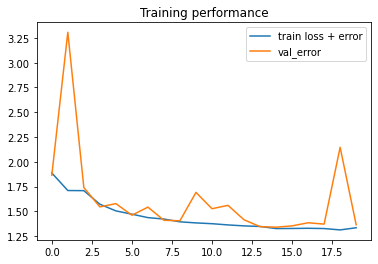

In [15]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

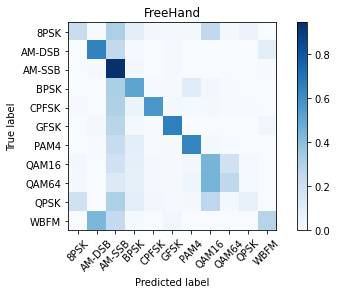

In [16]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08692421991084695


Overall Accuracy:  0.09279112754158965


Overall Accuracy:  0.0975609756097561


Overall Accuracy:  0.10892480674631061


Overall Accuracy:  0.1217485549132948


Overall Accuracy:  0.19727891156462585


Overall Accuracy:  0.3375134360444285


Overall Accuracy:  0.43931686046511625


Overall Accuracy:  0.503727369542066


Overall Accuracy:  0.5718907260963336


Overall Accuracy:  0.6477850399419027


Overall Accuracy:  0.6758023800937613


Overall Accuracy:  0.7180265654648956


Overall Accuracy:  0.7100746268656717


Overall Accuracy:  0.7006484149855908


Overall Accuracy:  0.7079839591687933


Overall Accuracy:  0.6886338393187709


Overall Accuracy:  0.6859721699887176


Overall Accuracy:  0.706337509211496


Overall Accuracy:  0.6953405017921147


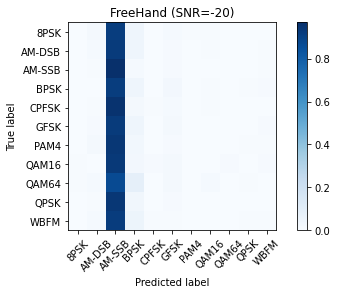

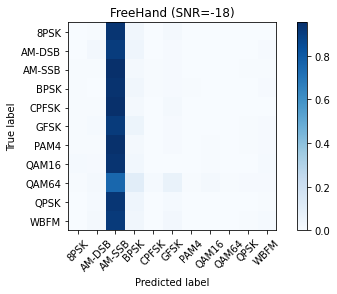

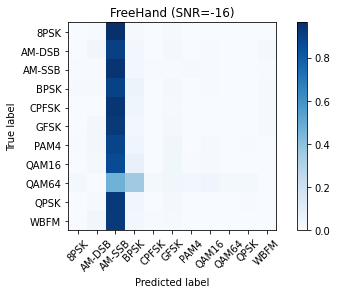

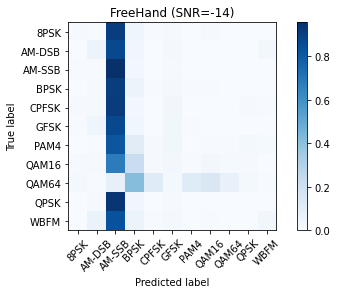

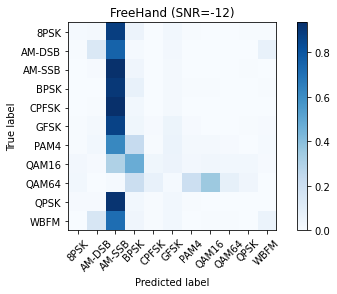

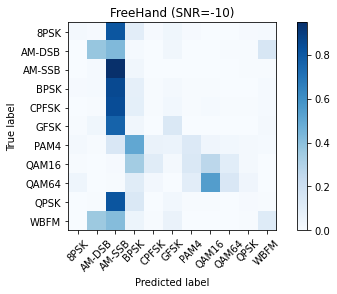

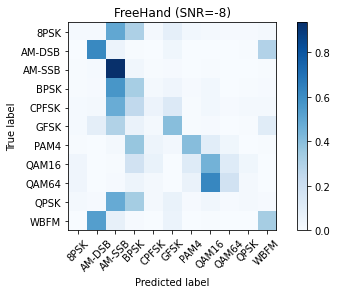

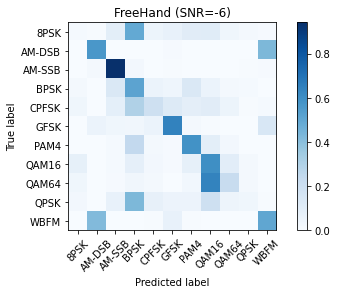

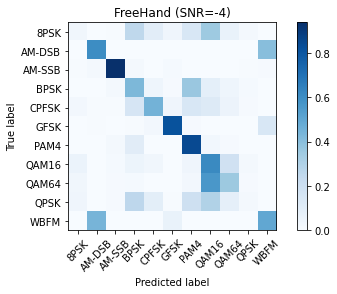

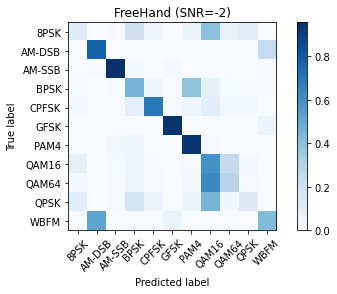

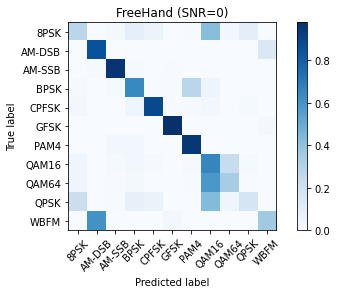

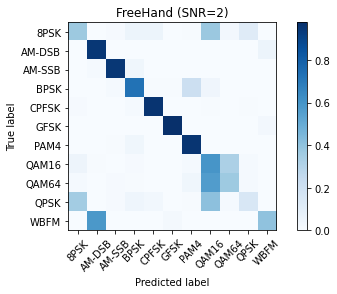

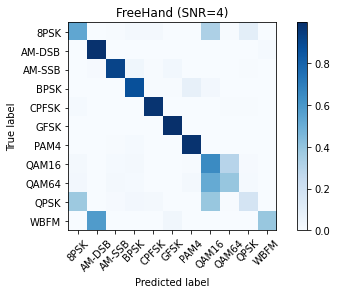

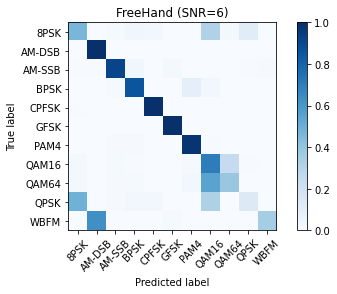

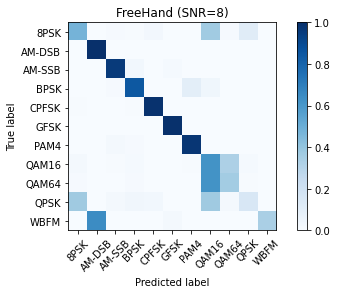

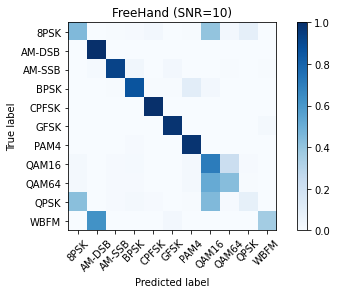

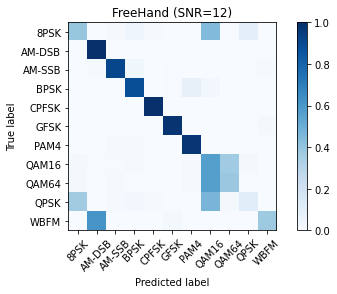

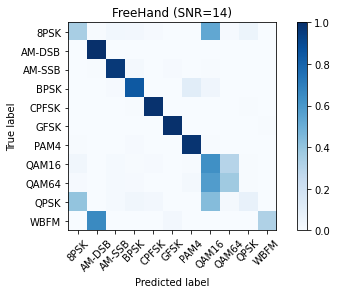

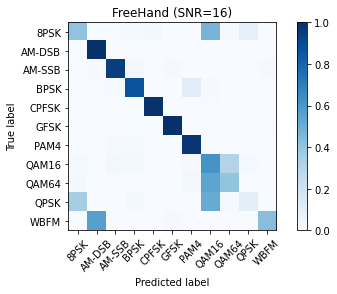

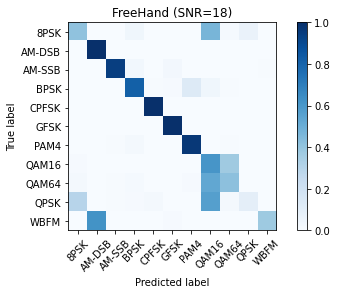

In [17]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [18]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,12,19,33,43,50,57,64,67,71,71,70,70,68,68,70,69


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

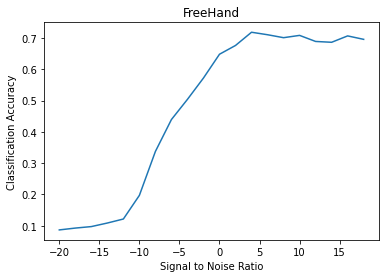

In [20]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)